In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.tree import DecisionTreeClassifier

from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
sb.set_style("whitegrid")

# Olist E-Commerce Seller Segmentation Analysis
---

## 1. Business Understanding

### Context
Olist adalah sebuah platform B2B2C e-commerce enabler asal Brasil yang membantu penjual (seller) mendistribusikan produknya ke berbagai marketplace besar di Brasil.
- Seller mengunggah produk mereka ke Olist.
- Olist kemudian mendistribusikan produk tersebut ke marketplace mitra dan mengelola sebagian aspek penjualan seperti promosi dan logistik.
- Dengan sistem ini, seller dapat menjangkau lebih banyak seller tanpa perlu mengatur sendiri banyak kanal distribusi.

Dalam ekosistem seperti ini, kinerja dan keberlangsungan seller menjadi faktor utama bagi kesuksesan Olist. Seller yang aktif menjaga kelancaran supply produk, meningkatkan variasi pilihan bagi pembeli, serta mendorong pertumbuhan pendapatan perusahaan. Sebaliknya, seller yang pasif atau berhenti berjualan dapat mengurangi daya tarik platform dan memengaruhi stabilitas ekosistem dan menurunkan reputasi perusahaan.

Untuk memahami perilaku seller dan mendukung pengambilan keputusan strategis, dilakukan RFM (Recency, Frequency, Monetary) + Rating Analysis:
- Recency (R): kapan terakhir kali seller menerima order.
- Frequency (F): seberapa sering seller menerima order.
- Monetary (M): total nilai transaksi.
- Rating : rata-rata rating setiap seller.

Analisis ini membantu Olist mengidentifikasi seller dengan kontribusi tinggi, seller baru, seller berisiko churn, hingga seller bernilai rendah.

### Stakeholder
1. Manajemen Olist (Strategi & Operasional)
    - Membutuhkan pemetaan perilaku seller untuk merumuskan strategi pertumbuhan jangka panjang.

2. Tim Business Development & Partnership
    - Memanfaatkan insight untuk mempertahankan seller existing dan menargetkan seller baru dengan lebih tepat.

3. Tim Seller Success / Account Manager
    - Menggunakan hasil segmentasi untuk memberikan pendekatan personal pada seller, seperti dukungan tambahan atau insentif.

4. Tim Data & Product
    - Menjadikan hasil RFM sebagai dasar untuk pengembangan model prediksi (contoh: churn prediction) dan membangun dashboard monitoring seller.

5. Seller (Indirect Stakeholder)
    - Mendapat manfaat dari program retensi, pelatihan, atau insentif yang dirancang berdasarkan hasil analisis.

### Problem Statements

1. Aktivitas dan kontribusi seller sangat bervariasi, dari yang sangat aktif hingga hampir tidak aktif.
2. Tanpa segmentasi berbasis data, sulit bagi Olist untuk menentukan seller mana yang harus diprioritaskan dalam program retensi.
3. Seller berisiko churn sulit terdeteksi dini, sehingga Olist bisa kehilangan kontribusi pendapatan penting.
4. Perlu metode yang sistematis untuk mengukur nilai dan keterlibatan seller dalam platform.

### Objectives
1. Melakukan RFM + Rating Analysis pada seller untuk mengukur aktivitas dan kontribusi mereka.
2. Mengelompokkan seller ke dalam segmen yang bermakna (Top Sellers, Steady Sellers, dan Casual Sellers).
3. Memberikan rekomendasi strategi yang dapat diterapkan Olist, misalnya program retensi kepada high performance sellers, dukungan khusus, atau insentif kepada low performance sellers sehingga kelompok ini dapat meningkat ke kelompok high performance sellers.
5. Menyediakan pondasi awal bagi pengembangan lebih lanjut, seperti model prediksi churn seller atau seller scoring untuk mendukung pengambilan keputusan berbasis data.

## 2. Analytical Approach

### 1. Analisis Manual

**Exploratory RFM + Review Analysis**
- Hitung Recency, Frequency, Monetary (RFM), serta Average Review Score untuk setiap seller.
- Buat distribusi dan deskriptif statistik (mean, median, quantile).
- Lakukan segmentasi manual dengan aturan berbasis kuartil atau threshold, misalnya:
  - Top Sellers: Recency rendah, Frequency tinggi, Monetary tinggi, Review Score tinggi.
  - At Risk Sellers: Recency tinggi, Frequency menurun, Review Score sedang/rendah.
  - Inactive Sellers: Recency sangat tinggi, Frequency rendah, Monetary rendah.
- Tujuan: mendapatkan gambaran awal tentang pola performa seller tanpa algoritma machine learning.

### 2. Analisis dengan Algoritma Machine Learning

**DBSCAN**
- Gunakan fitur RFM + Review yang sudah dinormalisasi.
- Parameter kunci:
  - eps: radius kedekatan antar titik.
  - min_samples: jumlah minimum seller dalam sebuah cluster.
- Kelebihan:
  - Dapat mendeteksi kelompok seller dengan pola tidak beraturan.
  - Menandai seller yang tidak cocok dengan cluster (noise/outliers).
- Kekurangan:
  - Sensitif terhadap pemilihan eps dan min_samples.
  - Sulit jika jarak antar cluster berdekatan.

**K-Means**
- Gunakan fitur RFM + Review yang sudah distandardisasi.
- Tentukan jumlah cluster dengan Elbow Method atau Silhouette Score.
- Kelebihan:
  - Algoritma sederhana, cepat, dan populer untuk segmentasi.
  - Hasil berupa centroid yang mudah diinterpretasi.
- Kekurangan:
  - Harus menentukan jumlah cluster di awal.
  - Tidak tahan terhadap outlier.

### 3. Metrik Evaluasi yang Digunakan
Karena clustering tidak memiliki “jawaban benar” seperti klasifikasi, maka hasilnya perlu dievaluasi dengan cara mengukur **apakah kelompok yang terbentuk benar-benar masuk akal**. Ada beberapa ukuran yang bisa dipakai:

- **Silhouette Score**  
  Ukuran ini melihat apakah seorang seller memang lebih dekat dengan kelompoknya dibanding dengan kelompok lain.
  $$
  s(i) = \frac{b(i) - a(i)}{\max \{a(i), b(i)\}}
  $$

      - a(i): average distance of point (i) to all other points in the **same cluster**  
      - b(i): minimum average distance of point (i) to points in **other clusters**

  - Jika nilainya tinggi (mendekati 1), artinya seller sudah berada dalam kelompok yang paling sesuai.  
  - Jika nilainya rendah atau negatif, berarti seller tersebut bisa saja lebih cocok di kelompok lain.  
  - Alasan dipakai: membantu mengecek apakah batas antar kelompok jelas atau masih tumpang tindih.  

- **Davies–Bouldin Index**  
  Ukuran ini membandingkan seberapa rapat seller dalam satu kelompok dengan seberapa jauh jarak kelompok itu terhadap kelompok lain.

  $$
  DBI = \frac{1}{k} \sum_{i=1}^{k} \max_{j \ne i}
  \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
  $$

      - k: number of clusters  
      - sigma_i: average distance of all points in cluster (i) to centroid (c_i)  
      - d(c_i, c_j): distance between centroids of clusters (i) and (j)

  - Nilai yang lebih kecil berarti kelompoknya sudah cukup rapat dan terpisah jelas.  
  - Alasan dipakai: cocok untuk tahu apakah ada kelompok yang terlalu mirip sehingga sebenarnya tidak perlu dipisah.  

- **Calinski–Harabasz Index**  
  Ukuran ini membandingkan seberapa terpisah antar kelompok dengan seberapa beragam seller di dalam kelompok.

  $$
  CHI = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{N - k}{k - 1}
  $$

      - N: total number of points  
      - k: number of clusters  
      - B_k: between-cluster dispersion matrix  
      - W_k: within-cluster dispersion matrix

  - Nilai lebih besar berarti kelompok-kelompok lebih jelas perbedaannya.  
  - Alasan dipakai: memberikan gambaran apakah segmentasi yang dibuat sudah bermanfaat atau justru terlalu kabur.  

### 4. Menemukan Ciri-ciri Berdasarkan RFM + Review
- Setelah cluster terbentuk, analisis nilai rata-rata R, F, M, dan Review Score per cluster.
- Berikan label sesuai karakteristik, misalnya:
  - Cluster 0: Recency rendah, Frequency tinggi, Review Score tinggi → Trusted Active Sellers
  - Cluster 1: Frequency rendah, Monetary rendah, Review Score sedang → Low Potential Sellers
  - Cluster 2: Recency tinggi, Frequency rendah, Review Score rendah → Inactive / Poor Performer Sellers


## 3. Business Flow

### Sebelum Menggunakan Analisis & Machine Learning  

1. **Analisis Manual**  
   - Tim bisnis membuat segmentasi seller secara manual, misalnya:  
     - Seller aktif (ada transaksi bulan ini).  
     - Seller tidak aktif (tidak ada transaksi >90 hari).  
     - Seller baru (bergabung ≤30 hari).  
   - Analisis dilakukan lewat Excel atau laporan statis.  

2. **Pengambilan Keputusan**  
   - Strategi dilakukan berbasis intuisi atau aturan sederhana, misalnya:  
     - Kirim email motivasi ke semua seller tidak aktif.  
     - Berikan promo ongkir hanya ke seller baru.  
   - Hasilnya kadang tidak tepat → biaya promosi tinggi, seller tetap tidak aktif, revenue stagnan.  

3. **Estimasi Biaya Jika Tidak Ada Treatment Seller**

    Dengan estimasi bahwa 33% dari total seller akan churn.

| Jenis Biaya                                                | Estimasi (BRL)|
| ---------------------------------------------------------- | ----------------------------------- |
| Kehilangan revenue dari seller churn (1021 seller x 49) | **50.029**     |
| Cost akuisisi seller baru (1021 seller × 375)           | **382.875**   |
| **TOTAL**                                             | **432.904**   |


---

### Sesudah Menggunakan Analisis & Machine Learning  
1. **Clustering / Seller Segmentation dengan ML**  
   - Algoritma ML (misalnya KMeans, DBSCAN) digunakan untuk mengelompokkan seller otomatis.  
   - Hasil cluster merepresentasikan tipe seller, misalnya:  
     - **Top Performer** → recency rendah, frequency tinggi, monetary tinggi, review bagus.  
     - **At Risk Seller** → recency tinggi, frequency menurun, review sedang/rendah.  
     - **Inactive Seller** → tidak ada transaksi lama, produk sedikit.  

3. **Actionable Insights**  
   - Strategi bisnis bisa lebih spesifik:  
     - Top Performer → diberikan insentif khusus (misalnya iklan gratis, campaign eksklusif).  
     - At Risk → diberikan dukungan operasional atau pelatihan agar performa meningkat.  
     - Inactive Seller → program reaktivasi dengan promo onboarding ulang.  
   - Efisiensi biaya promosi meningkat, karena intervensi sesuai kondisi seller.  

4. **Monitoring & Continuous Improvement**  
   - Performa seller dipantau terus-menerus.  
   - Feedback dari program masuk kembali ke sistem untuk update model ML.  
   - Model diperbarui berkala agar tetap sesuai tren bisnis dan perilaku seller.  

---

### Perbandingan Singkat  

| Tahap	                | Sebelum Analisis & ML	               | Sesudah Analisis & ML  |
|------------------------|--------------------------------------|-------------------------|
| Segmentasi Seller	    | Manual, aturan sederhana             | Otomatis, berbasis data & pola performa |
| Program Dukungan Seller| Mass campaign (semua diperlakukan sama) | Targeted campaign (khusus per cluster seller) |
| Efisiensi Biaya	    | Rendah (banyak program tidak efektif)| Tinggi (intervensi lebih tepat sasaran) |
| Pengambilan Keputusan	| Intuisi / aturan statis              | Data-driven, berbasis model prediktif/analitik |


### Terminologi Bisnis

**Olist :**  
Platform e-commerce enabler berbasis B2B2C asal Brasil yang membantu penjual (seller) mendistribusikan produk mereka ke berbagai marketplace besar di Brasil.  

**Seller :**  
Penjual yang bermitra dengan Olist. Seller mengunggah produk ke Olist, lalu Olist yang mendistribusikannya ke marketplace mitra.  

**Order :**  
Transaksi pembelian produk yang dilakukan oleh customer melalui marketplace yang terhubung dengan Olist dan dikaitkan dengan seller yang memasok produk.  

**Gross Revenue/Payment Values :**  
Nilai penjualan (dalam Real Brasil, BRL) yang didapatkan melalui transaksi yang difasilitasi Olist.

**Recency :**  
Ukuran seberapa lama waktu yang telah berlalu sejak seller terakhir kali menerima order.  

**Frequency :**  
Ukuran seberapa sering seller menerima order.  

**Monetary :**  
Ukuran nilai yang didapatkan dari suatu transaksi per seller.

**Rating :**
Rata-rata penilaian yang diberikan customer terhadap seller.

**RFM Analysis :**  
Metode segmentasi berbasis Recency, Frequency, dan Monetary untuk mengukur aktivitas, konsistensi, dan kontribusi seller terhadap platform.  

**RFM Segmentation :**  
Proses mengelompokkan seller berdasarkan skor RFM untuk menemukan seller dengan karakteristik berbeda, seperti:  
- **Top Sellers:** Seller paling aktif dan memberikan kontribusi besar.  
- **Steady Sellers:** Seller aktif tapi tidak selalu konsisten dan memberikan kontribusi bernilai sedang.
- **Casual Sellers:** Seller dengan kontribusi kecil dan aktivitas rendah.  

**Churn :**  
Kondisi ketika seller berhenti berjualan atau menjadi tidak aktif dalam jangka waktu tertentu.  

**Retention :**  
Upaya Olist untuk mempertahankan seller agar tetap aktif berjualan di platform.  

**Segmentation :**  
Proses mengelompokkan seller berdasarkan skor RFM untuk mendukung strategi bisnis yang lebih terarah.  

**Targeted Program :**  
Strategi khusus untuk segmen seller tertentu, misalnya program insentif untuk seller berisiko churn atau dukungan ekstra untuk seller berkontribusi tinggi.  

**Seller Success :**  
Pendekatan manajemen relasi yang bertujuan membantu seller tetap aktif, berkembang, dan menghasilkan penjualan yang konsisten di Olist.  

**Revenue Optimization :**  
Upaya mengalokasikan sumber daya (promosi, insentif, pendampingan) secara efektif agar kontribusi seller terhadap pendapatan Olist meningkat.

## 4. Data Understanding
Dataset yang digunakan berasal dari Olist Brazilian E-Commerce Public Dataset di [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).
- Sumber: Data asli dari transaksi e-commerce Brasil yang difasilitasi oleh Olist.
- Periode waktu: 2016 – 2018 (sekitar 2 tahun).
- Lokasi: Brasil.
- Tabel terkait seller:
    - olist_sellers_dataset.csv → berisi informasi identitas seller.
    - olist_orders_dataset.csv dan olist_order_items_dataset.csv → berisi detail order yang dikaitkan dengan seller.
    - Data ini dapat digabungkan untuk membentuk metrik RFM setiap seller.
- Terdapat 9 set tabel data yang terhubung seperti schema berikut

![data_schema](https://drive.google.com/uc?export=view&id=1CioWeNisdSzh0NkXXjuYzHSBSIXSB2qQ)

In [3]:
# Load dataset
customers = pd.read_csv("/content/drive/MyDrive/final_project/dataset/olist_customers_dataset.csv")
geolocation = pd.read_csv("/content/drive/MyDrive/final_project/dataset/olist_geolocation_dataset.csv")
orders = pd.read_csv("/content/drive/MyDrive/final_project/dataset/olist_orders_dataset.csv")
order_items = pd.read_csv("/content/drive/MyDrive/final_project/dataset/olist_order_items_dataset.csv")
order_payments = pd.read_csv("/content/drive/MyDrive/final_project/dataset/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("/content/drive/MyDrive/final_project/dataset/olist_order_reviews_dataset.csv")
products = pd.read_csv("/content/drive/MyDrive/final_project/dataset/olist_products_dataset.csv")
sellers = pd.read_csv("/content/drive/MyDrive/final_project/dataset/olist_sellers_dataset.csv")
translation = pd.read_csv("/content/drive/MyDrive/final_project/dataset/product_category_name_translation.csv")

### Order
Terdapat 99,441 order dan setiap baris mewakilkan order yang dilakukan customer

| Nama Kolom | Deskripsi | Tipe Data |
|----------|----------|----------|
| order_id    | Unique key untuk tabel data ini   | String  |
| customer_id    | Unique key customer setiap melakukan order   | String  |
| order status    | Status pengiriman produk  | String   |
| order_purchase_timestamp    | Waktu pembelian produk  | String   |
| order_approved_at    | Waktu pembayaran telah berhasil diklarifikasi | String   |
| order_delivered_carrier_date    | Waktu pemesanan saat pesanan diserahkan kepada kurir  | String  |
| order_delivered_customer_date    | Waktu pengiriman produk  | String   |
| order_estimated_delivery_date    | Waktu perkiraan pengiriman ke customer saat proses pemesanan  | String   |

### Order Payment
Terdapat 103,886 reviews dan setiap baris mewakilkan informasi pembayaran sebuah order

| Nama Kolom | Deskripsi | Tipe Data |
|----------|----------|----------|
| order_id   | Unique identifier dari sebuah order  | String   |
| payment_sequential    | Customer yang menggunakan beberapa metode pembayaran, dan sistem akan membuat urutannya  | Integer  |
| payment_type    | Metode pembayaran yang dipilih customer | String   |
| paymnet_installments    | Banyaknya pembayaran yang dilakukan berdasarkan pilihan customer | Integer   |
| payment_value    | Total yang perlu dibayar dalam suatu transaksi  | Float   |


### Product
Terdapat 32,951 produk yang dijual dan setiap baris mewakilkan informasi produk tersebut

| Nama Kolom | Deskripsi | Tipe Data |
|----------|----------|----------|
| product_id   | Unique key untuk produk  | String   |
| product_category_name    | Nama kategori dari produk   | String  |
| product_name_length    | Jumlah karakter dari nama produk  | Float   |
| product_descripion_length    | Jumlah karakter dari deskripsi produk  | Float   |
| product_photos_qty    | Jumlah foto produk yang diberikan  | Float  |
| product_weight_g    | Berat produk dalam gram  | Float   |
| product_length_cm    | Panjang dimensi produk dalam cm  | Float   |
| product_height_cm    | Tinggi dimensi produk dalam cm  | Float   |
| product_width_cm    | Lebar dimensi produk dalam cm  | Float   |


### Order Reviews
Terdapat 99,224 reviews dan setiap baris mewakilkan review yang diberikan terhadap barang yang dibeli.

| Nama Kolom | Deskripsi | Tipe Data |
|----------|----------|----------|
| review_id    | Unique key untuk tabel data ini  | String   |
| order_id    | Unique Identifier dari sebuah order   | String  |
| review_score    | Score produk yang diberikan oleh pembeli (1-5)  | Integer   |
| review_comment_title    | Judul dari review yang diberikan  | String   |
| review_comment_message    | Pesan review yang diberikan  | String   |
| review_creation_date    | Tanggal review dikirim ke pembeli | String  |
| review_answer_timestamp    | Waktu review dibuat  | String   |

### Order Item
Terdapat 112,650 order dan setiap baris mewakilkan pembelian produk

| Nama Kolom | Deskripsi | Tipe Data |
|----------|----------|----------|
| order_id    | Unique Identifier dari sebuah order   | String  |
| order_item_id    | Nomor urut yang mengidentifikasi jumlah item yang termasuk dalam pesanan yang sama  | Integer  |
| product_id   | Secondary key untuk produk  | String   |
| seller_id    | Secondary key untuk seller  | String   |
| shipping_limit_date    | Batas waktu penjual untuk memberikan produk ke logistic  | String   |
| price    | Harga produk per unit (BRL) | Float  |
| freight_value    | Biaya pengiriman per unit  | Float  |


### Seller
Terdapat 3095 penjual dan setiap baris mewakilkan informasi penjual

| Nama Kolom | Deskripsi | Tipe Data |
|----------|----------|----------|
| seller_id    | Unique key untuk Seller  | String   |
| seller_zip_code_prefix   | 5 angka pertama untuk zip code penjual   | Integer |
| seller_city    | Kota penjual berada  | String  |
| seller_state   | Provinsi penjual berada  | String   |

### Customer
Terdapat 99441 baris dan setiap baris mewakilkan informasi costumer untuk setiap pembelian

| Nama Kolom | Deskripsi | Tipe Data |
|----------|----------|----------|
| customer_id    | Secondary key untuk menghubungkan ke tabel order   | String  |
| customer_unique_id    | Unique identidier untuk customer  | String  |
| customer_zip_code_prefix   | 5 angka pertama zip code milik customer  | Integer   |
| customer_city    | Kota customer berada  | String   |
| customer_state    | Provinsi customer berada  | String   |

### Geolocation
Terdapat 1,000,163 lokasi dan setiap baris mewakilkan informasi lokasi

| Nama Kolom | Deskripsi | Tipe Data |
|----------|----------|----------|
| geolocation_zip_code_prefix    | 5 angka pertama zip code   | Integer  |
| geolocation_lat    | Latitude sebuah lokasi  | Float |
| geolocation_lng   | Longitude sebuah lokasi  | Float   |
| geolocation_city    | Nama kota  | String   |
| geolocation_state    | Nama provinsi  | String   |

## 5. Data Cleaning


In [4]:
# Helper Function
def info(df, df_name, key):
    # menampilkan missing value, tipe data dan duplikat berdasarkan key tertentu
    print(f"Menunjukkan dataset dari {df_name}\n")
    print("Cek missing value:\n")
    print(df.isna().sum())
    print("\n")
    df.info()
    print("\n --------------------------------- \n")
    print(f"Terdapat {len(df) - df[key].nunique()} duplicate {key} dalam {df_name} dataset")
    print("\n --------------------------------- \n")

### Customer

In [5]:
customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [6]:
# Check info tabel customers
info(customers, "customers", "customer_unique_id")

Menunjukkan dataset dari customers

Cek missing value:

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB

 --------------------------------- 

Terdapat 3345 duplicate customer_unique_id dalam customers dataset

 --------------------------------- 



In [7]:
# Mengecheck customers yang memiliki customer_unique_id yang sama
customers[customers["customer_unique_id"].duplicated(keep=False)].sort_values("customer_unique_id")

customer_id                customer_unique_id  \
35608  24b0e2bd287e47d54d193e7bbb51103f  00172711b30d52eea8b313a7f2cced02   
19299  1afe8a9c67eec3516c09a8bdcc539090  00172711b30d52eea8b313a7f2cced02   
20023  1b4a75b3478138e99902678254b260f4  004288347e5e88a27ded2bb23747066c   
22066  f6efe5d5c7b85e12355f9d5c3db46da2  004288347e5e88a27ded2bb23747066c   
72451  49cf243e0d353cd418ca77868e24a670  004b45ec5c64187465168251cd1c9c2f   
...                                 ...                               ...   
75057  1ae563fdfa500d150be6578066d83998  ff922bdd6bafcdf99cb90d7f39cea5b3   
27992  bec0bf00ac5bee64ce8ef5283051a70c  ff922bdd6bafcdf99cb90d7f39cea5b3   
79859  d064be88116eb8b958727aec4cf56a59  ff922bdd6bafcdf99cb90d7f39cea5b3   
64323  4b231c90751c27521f7ee27ed2dc3b8f  ffe254cc039740e17dd15a5305035928   
12133  0088395699ea0fcd459bfbef084997db  ffe254cc039740e17dd15a5305035928   

       customer_zip_code_prefix customer_city customer_state  
35608                     45200        jequie             BA  
19299                     45200        jequie             BA  
20023                     26220   nova iguacu             RJ  
22066                     26220   nova iguacu             RJ  
72451                     57055        maceio             AL  
...                         ...           ...            ...  
75057                     17340  barra bonita             SP  
27992                     17340  barra bonita             SP  
79859                     17340  barra bonita             SP  
64323                     37640       extrema             MG  
12133                     37640       extrema             MG  

[6342 rows x 5 columns]

Insight:

Untuk dataset customer, "customer_unique_id" digunakan untuk membedakan setiap customer dan "customer_id" digunakan sebagai unique key dari sebuah order (dalam tabel order), sehingga data yang memiliki "customer_unique_id" duplikat dapat kita pertahankan.

### Order Items

In [8]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [9]:
print(f'Jumlah baris dan kolom adalah: {order_items.shape}')
order_items.info()

Jumlah baris dan kolom adalah: (112650, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [10]:
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [11]:
# Mengecek order_item_id
order_items[order_items.drop("order_item_id",axis=1).duplicated(keep=False)].sort_values("order_id")

order_id  order_item_id  \
13      0008288aa423d2a3f00fcb17cd7d8719              1   
14      0008288aa423d2a3f00fcb17cd7d8719              2   
32      00143d0f86d6fbd9f9b38ab440ac16f5              1   
33      00143d0f86d6fbd9f9b38ab440ac16f5              2   
34      00143d0f86d6fbd9f9b38ab440ac16f5              3   
...                                  ...            ...   
112634  fff8287bbae429a99bb7e8c21d151c41              1   
112641  fffb9224b6fc7c43ebb0904318b10b5f              2   
112642  fffb9224b6fc7c43ebb0904318b10b5f              3   
112640  fffb9224b6fc7c43ebb0904318b10b5f              1   
112643  fffb9224b6fc7c43ebb0904318b10b5f              4   

                              product_id                         seller_id  \
13      368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
14      368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
32      e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
33      e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
34      e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
...                                  ...                               ...   
112634  bee2e070c39f3dd2f6883a17a5f0da45  4e922959ae960d389249c378d1c939f5   
112641  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   
112642  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   
112640  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   
112643  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   

        shipping_limit_date   price  freight_value  
13      2018-02-21 02:55:52   49.90          13.37  
14      2018-02-21 02:55:52   49.90          13.37  
32      2017-10-20 16:07:52   21.33          15.10  
33      2017-10-20 16:07:52   21.33          15.10  
34      2017-10-20 16:07:52   21.33          15.10  
...                     ...     ...            ...  
112634  2018-03-27 12:29:22  180.00          48.14  
112641  2017-11-03 02:55:58   55.00          34.19  
112642  2017-11-03 02:55:58   55.00          34.19  
112640  2017-11-03 02:55:58   55.00          34.19  
112643  2017-11-03 02:55:58   55.00          34.19  

[17313 rows x 7 columns]

Insight:

Filter order_item_id terbesar per order_id. Hal ini dikarenakan dalam dataset order_item, terjadi duplikat untuk setiap order_id sebanyak maksimum order_item_id.

In [12]:
# Mengambil baris per order_id dengan nilai order_item_id yang paling besar
order_items_max = order_items.loc[
    order_items.groupby("order_id")["order_item_id"].idxmax()
].reset_index(drop=True)

order_items_max.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

#### Identify Outliers

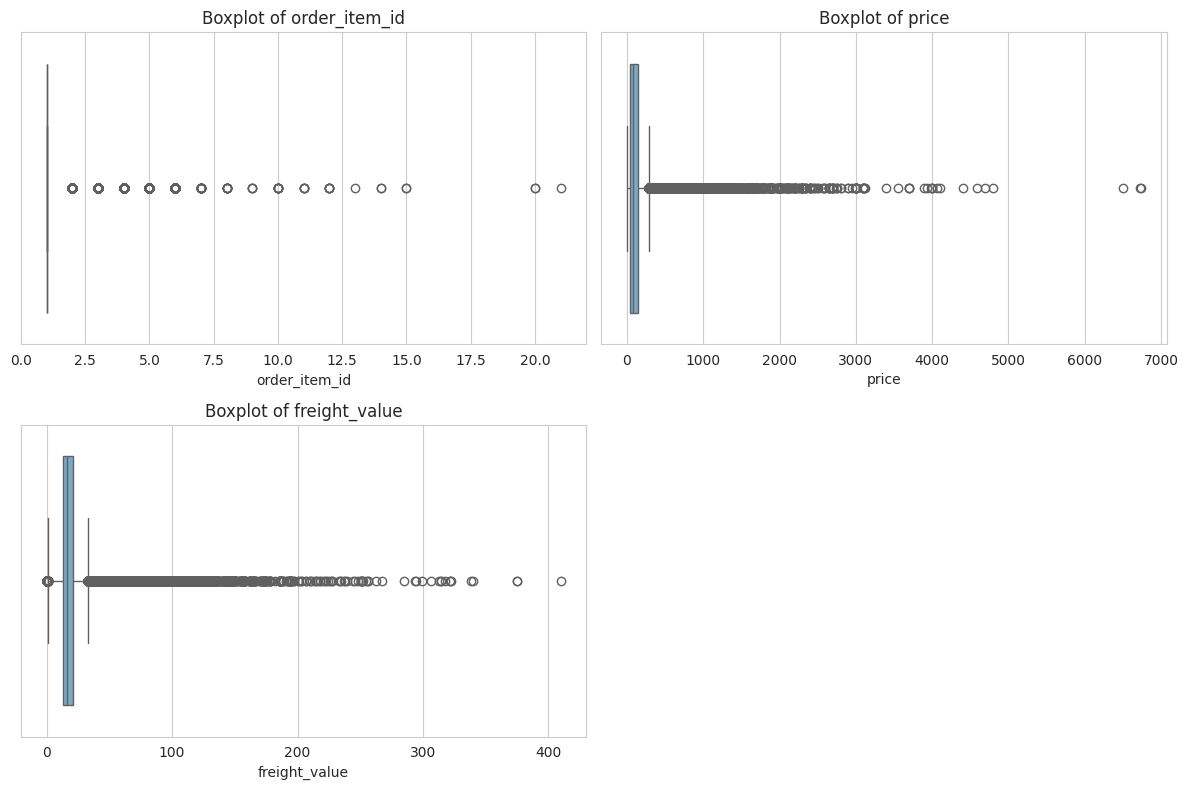

In [13]:
# Daftar kolom numerik yang ingin ditinjau
num_cols = ['order_item_id', 'price', 'freight_value']

# Plot boxplot untuk setiap kolom
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sb.boxplot(x=order_items_max[col],
               palette = "Blues")
    plt.title(f'Boxplot of {col}')
plt.tight_layout()

In [14]:
# Mengecek order_item_id di atas 18
order_items_max[order_items_max["order_item_id"] > 18]

order_id  order_item_id  \
10459  1b15974a0141d54e36626dca3fdc731a             20   
50137  8272b63d03f5f79c56e9e4120aec44ef             21   
65715  ab14fdcfbe524636d65ee38360e22ce8             20   

                             product_id                         seller_id  \
10459  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
50137  79ce45dbc2ea29b22b5a261bbb7b7ee7  2709af9587499e95e803a6498a5a56e9   
65715  9571759451b1d780ee7c15012ea109d4  ce27a3cc3c8cc1ea79d11e561e9bebb6   

       shipping_limit_date  price  freight_value  
10459  2018-03-01 02:50:48  100.0          10.12  
50137  2017-07-21 18:25:23    7.8           6.57  
65715  2017-08-30 14:30:23   98.7          14.44

In [15]:
# Mengecek price di atas 6000
order_items_max[order_items_max["price"] > 6000]

order_id  order_item_id  \
3130   0812eb902a67711a1cb742b3cdaa65ae              1   
94439  f5136e38d1a14a4dbd87dff67da82701              1   
98298  fefacc66af859508bf1a7934eab1e97f              1   

                             product_id                         seller_id  \
3130   489ae2aa008f021502940f251d4cce7f  e3b4998c7a498169dc7bce44e6bb6277   
94439  1bdf5e6731585cf01aa8169c7028d6ad  ee27a8f15b1dded4d213a468ba4eb391   
98298  69c590f7ffc7bf8db97190b6cb6ed62e  80ceebb4ee9b31afb6c6a916a574a1e2   

       shipping_limit_date   price  freight_value  
3130   2017-02-16 20:37:36  6735.0         194.31  
94439  2017-06-15 02:45:17  6499.0         227.66  
98298  2018-08-02 04:05:13  6729.0         193.21

In [16]:
# Mengecek freight_value di atas 300
order_items_max[order_items_max["freight_value"] > 300]

order_id  order_item_id  \
2893   076d1555fb53a89b0ef4d529e527a0f6              1   
3154   0822bcde10bb5d023755a71bc8f7797f              1   
4424   0b6230647ed16f4b3e70282dc4b5b87f              1   
5510   0e4672661531addf3fa0f55961e55242              1   
14693  264a7e199467906c0727394df82d1a6a              1   
23787  3dd5626c63f493f8b8f8788c2be24baa              1   
24519  3fde74c28a3d5d618c00f26d51baafa0              1   
26035  43bdbd9dc0931d72befdf4765af6c442              1   
42311  6ddfbf514959b49b6410c01ad93054bb              1   
61062  9f49bd16053df810384e793386312674              1   
64304  a77e1550db865202c56b19ddc6dc4d53              1   
76964  c7a07ddd52bbe18b61da49a8d89853d3              1   
97946  fe12e676fd493885d417a34bc3917411              1   

                             product_id                         seller_id  \
2893   a3cd9517ebf5a50dca25acce54f3b171  6fa9202c10491e472dffd59a3e82b2a3   
3154   363a9f5b97bf194da23858be722a7aa5  9596c870880d900012f2e8e6e30d06d7   
4424   46e24ce614899e36617e37ea1e4aa6ff  17f51e7198701186712e53a39c564617   
5510   dc861f18267cce21f3b70f9f7990b8ce  17f51e7198701186712e53a39c564617   
14693  97c948ebc8c04b26b7bbb095d4228f2a  17f51e7198701186712e53a39c564617   
23787  3a1855685a49813f60e6193864f7215e  c510bc1718f0f2961eaa42a23330681a   
24519  a3cd9517ebf5a50dca25acce54f3b171  6fa9202c10491e472dffd59a3e82b2a3   
26035  7e53e051875b2a0c9f22acd8a9a29a20  eeb6de78f79159600292e314a77cbd18   
42311  363a9f5b97bf194da23858be722a7aa5  9596c870880d900012f2e8e6e30d06d7   
61062  256a9c364b75753b97bee410c9491ad8  5c030029b5916fed0986310385ec9009   
64304  ec31d2a17b299511e7c8627be9337b9b  257e61d3251fb5efb9daadddbc2cf7ca   
76964  97c948ebc8c04b26b7bbb095d4228f2a  17f51e7198701186712e53a39c564617   
97946  1d16c0509e7011656e03c6a582ff6667  17f51e7198701186712e53a39c564617   

       shipping_limit_date    price  freight_value  
2893   2018-08-07 04:35:22  2338.08         375.28  
3154   2018-05-10 23:52:39   990.00         321.46  
4424   2018-06-01 19:14:24  1050.00         321.88  
5510   2017-07-12 04:03:18   990.00         314.02  
14693  2018-04-23 17:15:10  1050.00         338.30  
23787  2018-05-04 19:50:59  2699.00         306.06  
24519  2018-08-22 03:15:09  2338.08         375.28  
26035  2018-07-12 08:35:21  3089.00         317.47  
42311  2017-11-30 15:10:57  1045.00         314.40  
61062  2018-08-02 03:44:28  1149.00         339.59  
64304  2018-04-25 06:55:13   979.00         409.68  
76964  2018-07-31 10:45:11  1050.00         322.10  
97946  2017-06-06 18:35:15   760.00         312.41

Insight:
- Alasan **order_item_id** tidak didrop outlier dikarenakan dalam satu transaksi, customer bisa membeli barang yang sama dengan jumlah yang banyak.
- Alasan **price** tidak didrop outlier dikarenakan harga barang beragam, dan harga dasarnya ditentukan oleh seller (jika ada perubahan oleh olist), dan memang ada suatu barang dengan harga yang mahal sendiri.
- Alasan **freight_value** tidak didrop outlier dikarenakan ada kemungkinan di mana lokasi pengiriman barang bisa sangat jauh, ukuran dan berat barang, serta jumlahnya tidak sedikit.

### Order Payments Dataset

In [17]:
order_payments.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [18]:
print(f'Jumlah baris dan kolom adalah: {order_payments.shape}')
order_payments.info()

Jumlah baris dan kolom adalah: (103886, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [19]:
order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

#### Identify Outliers

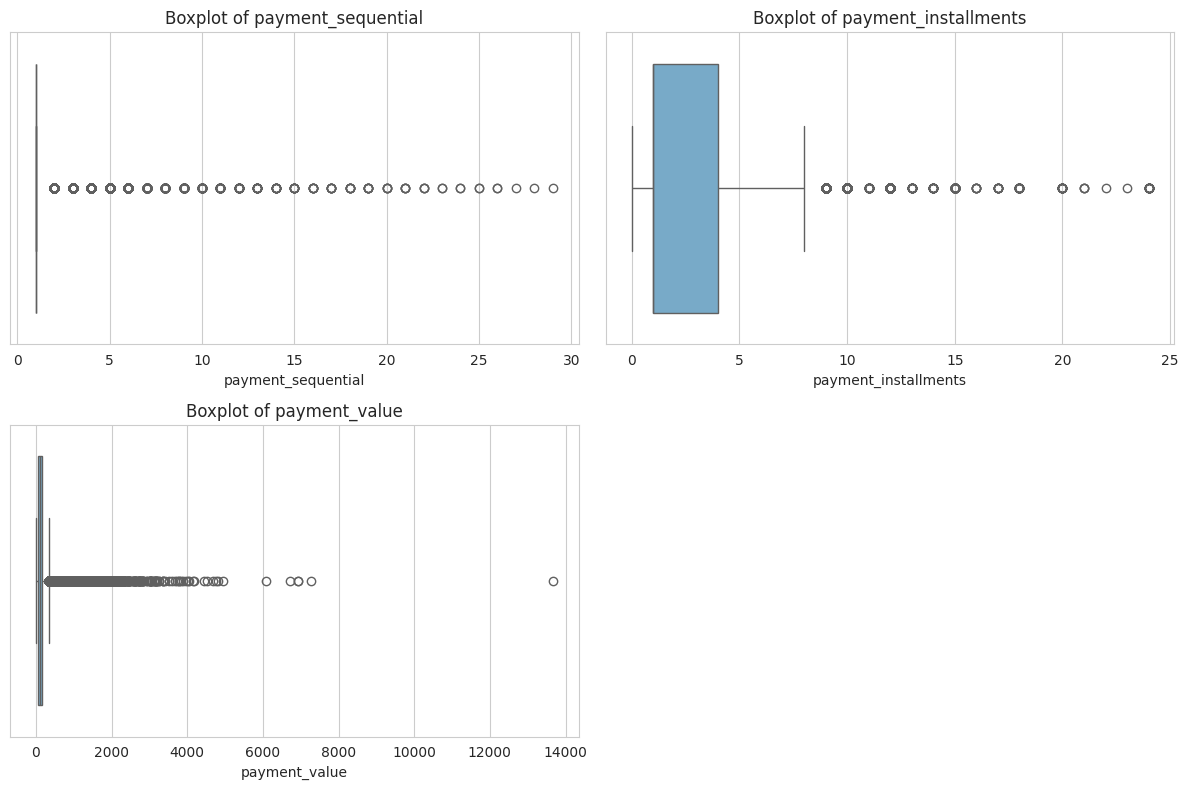

In [20]:
# Daftar kolom numerik yang ingin ditinjau
num_cols = ['payment_sequential', 'payment_installments', 'payment_value']

# Plot boxplot untuk setiap kolom
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sb.boxplot(x=order_payments[col],
               palette = "Blues")
    plt.title(f'Boxplot of {col}')
plt.tight_layout()

In [21]:
# Mengecek payment_value di atas 12000
order_payments[order_payments["payment_value"]>12000]

order_id  payment_sequential payment_type  \
52107  03caa2c082116e1d31e67e9ae3700499                   1  credit_card   

       payment_installments  payment_value  
52107                     1       13664.08

In [22]:
order_items_max[order_items_max["order_id"] == "03caa2c082116e1d31e67e9ae3700499"]

order_id  order_item_id  \
1455  03caa2c082116e1d31e67e9ae3700499              8   

                            product_id                         seller_id  \
1455  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   

      shipping_limit_date   price  freight_value  
1455  2017-10-06 15:28:20  1680.0          28.01

Insight:

Alasan tidak didrop outlier **payment_value** dikarenakan satu customer bisa saja membeli barang yang harganya mahal dengan jumlah lebih dari satu, yang menyebabkan total pembayarannya jadi semakin besar.

### Review

Kita hanya akan menggunakan kolom:
- review_id sebagai unique key
- order_id sebagai secondary key
- review_score

Kita akan menghapus data dari kolom lainnya

In [23]:
info(order_reviews, "review", "review_id")

Menunjukkan dataset dari review

Cek missing value:

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB

 --------------------------------- 

Terdapat 814 duplicate revie

In [24]:
# Mengecek duplikat
order_reviews[order_reviews["review_id"].duplicated(keep=False)].sort_values("review_id")

review_id                          order_id  \
46678  00130cbe1f9d422698c812ed8ded1919  dfcdfc43867d1c1381bfaf62d6b9c195   
29841  00130cbe1f9d422698c812ed8ded1919  04a28263e085d399c97ae49e0b477efa   
90677  0115633a9c298b6a98bcbe4eee75345f  78a4201f58af3463bdab842eea4bc801   
63193  0115633a9c298b6a98bcbe4eee75345f  0c9850b2c179c1ef60d2855e2751d1fa   
92876  0174caf0ee5964646040cd94e15ac95e  f93a732712407c02dce5dd5088d0f47b   
...                                 ...                               ...   
31120  fe5c833752953fed3209646f1f63b53c  4863e15fa53273cc7219c58f5ffda4fb   
7870   ff2fc9e68f8aabfbe18d710b83aabd30  2da58e0a7dcfa4ce1e00fad9d03ca3b5   
82521  ff2fc9e68f8aabfbe18d710b83aabd30  1078d496cc6ab9a8e6f2be77abf5091b   
73951  ffb8cff872a625632ac983eb1f88843c  c44883fc2529b4aa03ca90e7e09d95b6   
1985   ffb8cff872a625632ac983eb1f88843c  c88b1d1b157a9999ce368f218a407141   

       review_score review_comment_title  \
46678             1                  NaN   
29841             1                  NaN   
90677             5                  NaN   
63193             5                  NaN   
92876             1                  NaN   
...             ...                  ...   
31120             1                  NaN   
7870              2                  NaN   
82521             2                  NaN   
73951             3                  NaN   
1985              3                  NaN   

                                  review_comment_message review_creation_date  \
46678  O cartucho "original HP" 60XL não é reconhecid...  2018-03-07 00:00:00   
29841  O cartucho "original HP" 60XL não é reconhecid...  2018-03-07 00:00:00   
90677                                                NaN  2017-09-21 00:00:00   
63193                                                NaN  2017-09-21 00:00:00   
92876  Produto entregue dentro de embalagem do fornec...  2018-03-07 00:00:00   
...                                                  ...                  ...   
31120  Comprei dois produtos e ambos, mesmo enviados ...  2018-02-28 00:00:00   
7870                                                 NaN  2018-03-17 00:00:00   
82521                                                NaN  2018-03-17 00:00:00   
73951                                                NaN  2017-07-22 00:00:00   
1985                                                 NaN  2017-07-22 00:00:00   

      review_answer_timestamp  
46678     2018-03-20 18:08:23  
29841     2018-03-20 18:08:23  
90677     2017-09-26 03:27:47  
63193     2017-09-26 03:27:47  
92876     2018-03-08 03:00:53  
...                       ...  
31120     2018-02-28 13:57:52  
7870      2018-03-19 11:44:15  
82521     2018-03-19 11:44:15  
73951     2017-07-26 13:41:07  
1985      2017-07-26 13:41:07  

[1603 rows x 7 columns]

Insight:

Terdapat 1603 baris yang memiliki review_id yang sama namun memiliki order id yang berbeda. Ini dikarenakan pembeli membuat beberapa order dalam satu kali pembelanjaan, sehingga ketika pembeli memberikan review, review tersebut akan dikirimkan untuk setiap order.

In [25]:
# Mengecek review_score
order_reviews["review_score"].value_counts().reset_index().sort_values("review_score",ascending = True)

review_score  count
2             1  11424
4             2   3151
3             3   8179
1             4  19142
0             5  57328

Insight:

Tidak ada nilai review score di luar 1 - 5.

In [26]:
# Mengambil kolom yang hanya diperlukan dari tabel order_reviews
order_reviews = order_reviews[["review_id", "order_id", "review_score"]]
order_reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score  
0             4  
1             5  
2             5  
3             5  
4             5

### Product

Kita hanya akan menggunakan kolom:
- product_id sebagai unique key
- product_category_name

Kita akan menghapus data dari kolom lainnya.

In [27]:
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [28]:
# Check info tabel product
info(products, "product", "product_id")

Menunjukkan dataset dari product

Cek missing value:

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7  

In [29]:
# Mengecek nilai kosong pada kolom product_category_name
products[products["product_category_name"].isna()]

product_id product_category_name  \
105    a41e356c76fab66334f36de622ecbd3a                   NaN   
128    d8dee61c2034d6d075997acef1870e9b                   NaN   
145    56139431d72cd51f19eb9f7dae4d1617                   NaN   
154    46b48281eb6d663ced748f324108c733                   NaN   
197    5fb61f482620cb672f5e586bb132eae9                   NaN   
...                                 ...                   ...   
32515  b0a0c5dd78e644373b199380612c350a                   NaN   
32589  10dbe0fbaa2c505123c17fdc34a63c56                   NaN   
32616  bd2ada37b58ae94cc838b9c0569fecd8                   NaN   
32772  fa51e914046aab32764c41356b9d4ea4                   NaN   
32852  c4ceee876c82b8328e9c293fa0e1989b                   NaN   

       product_name_lenght  product_description_lenght  product_photos_qty  \
105                    NaN                         NaN                 NaN   
128                    NaN                         NaN                 NaN   
145                    NaN                         NaN                 NaN   
154                    NaN                         NaN                 NaN   
197                    NaN                         NaN                 NaN   
...                    ...                         ...                 ...   
32515                  NaN                         NaN                 NaN   
32589                  NaN                         NaN                 NaN   
32616                  NaN                         NaN                 NaN   
32772                  NaN                         NaN                 NaN   
32852                  NaN                         NaN                 NaN   

       product_weight_g  product_length_cm  product_height_cm  \
105               650.0               17.0               14.0   
128               300.0               16.0                7.0   
145               200.0               20.0               20.0   
154             18500.0               41.0               30.0   
197               300.0               35.0                7.0   
...                 ...                ...                ...   
32515            1800.0               30.0               20.0   
32589             800.0               30.0               10.0   
32616             200.0               21.0                8.0   
32772            1300.0               45.0               16.0   
32852             700.0               28.0                3.0   

       product_width_cm  
105                12.0  
128                20.0  
145                20.0  
154                41.0  
197                12.0  
...                 ...  
32515              70.0  
32589              23.0  
32616              16.0  
32772              45.0  
32852              43.0  

[610 rows x 9 columns]

Insight:

Terdapat 610 baris yang product_category_namenya bernilai kosong. Saat ini dibiarkan terlebih dahulu karena akan dilakukan imputasi manual.

In [30]:
translation.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [31]:
# mengubah dataframe menjadi dictionary
translation_dict = dict(zip(translation["product_category_name"], translation["product_category_name_english"]))

# Melakukan translate kepada product_category_name yang belum mempunyai product_category_name_english
translation_dict["pc_gamer"] = "pc_gamer"
translation_dict["portateis_cozinha_e_preparadores_de_alimentos"] = "portable kitchen and food processors"

# menambah kategori produk dalam english ke dalam tabel product
products["product_category_name_english"] = products["product_category_name"].map(translation_dict)

products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             225.0               16.0               10.0              14.0   
1            1000.0               30.0               18.0              20.0   
2             154.0               18.0                9.0              15.0   
3             371.0               26.0                4.0              26.0   
4             625.0               20.0               17.0              13.0   

  product_category_name_english  
0                     perfumery  
1                           art  
2                sports_leisure  
3                          baby  
4                    housewares

In [32]:
# product yang tidak memiliki category di dalam bahasa inggris
products[(products["product_category_name_english"].isna()) & (products["product_category_name"].notna())]

Empty DataFrame
Columns: [product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm, product_category_name_english]
Index: []

In [33]:
# mengisi missing value kategori produk
products["product_category_name"].fillna("None", inplace=True)
products["product_category_name_english"].fillna("None", inplace=True)

In [34]:
products.isna().sum()

product_id                         0
product_category_name              0
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english      0
dtype: int64

In [35]:
# mengambil kolom yang akan digunakan
products = products[["product_id", "product_category_name", "product_category_name_english"]]

In [36]:
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

  product_category_name_english  
0                     perfumery  
1                           art  
2                sports_leisure  
3                          baby  
4                    housewares

### Orders

In [37]:
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [38]:
# Check info tabel orders
info(orders, "orders", "order_id")

Menunjukkan dataset dari orders

Cek missing value:

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-nu

In [39]:
orders["order_status"].value_counts()


order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [40]:
# Mengecek nilai kosong
orders[orders["order_delivered_customer_date"].isna()]

order_id                       customer_id  \
6      136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44     ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103    0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128    15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
154    6942b8da583c2f9957e990d028607019  52006a9383bf149a4fb24226b173106f   
...                                 ...                               ...   
99283  3a3cddda5a7c27851bd96c3313412840  0b0d6095c5555fe083844281f6b093bb   
99313  e9e64a17afa9653aacf2616d94c005b8  b4cd0522e632e481f8eaf766a2646e86   
99347  a89abace0dcc01eeb267a9660b5ac126  2f0524a7b1b3845a1a57fcf3910c4333   
99348  a69ba794cc7deb415c3e15a0a3877e69  726f0894b5becdf952ea537d5266e543   
99415  5fabc81b6322c8443648e1b21a6fef21  32c9df889d41b0ee8309a5efb6855dcb   

      order_status order_purchase_timestamp    order_approved_at  \
6         invoiced      2017-04-11 12:22:08  2017-04-13 13:25:17   
44         shipped      2018-06-04 16:44:48  2018-06-05 04:31:18   
103       invoiced      2018-08-03 17:44:42  2018-08-07 06:15:14   
128     processing      2017-09-03 14:22:03  2017-09-03 14:30:09   
154        shipped      2018-01-10 11:33:07  2018-01-11 02:32:30   
...            ...                      ...                  ...   
99283     canceled      2018-08-31 16:13:44                  NaN   
99313   processing      2018-01-05 23:07:24  2018-01-09 07:18:05   
99347     canceled      2018-09-06 18:45:47                  NaN   
99348  unavailable      2017-08-23 16:28:04  2017-08-28 15:44:47   
99415  unavailable      2017-10-10 10:50:03  2017-10-14 18:35:57   

      order_delivered_carrier_date order_delivered_customer_date  \
6                              NaN                           NaN   
44             2018-06-05 14:32:00                           NaN   
103                            NaN                           NaN   
128                            NaN                           NaN   
154            2018-01-11 19:39:23                           NaN   
...                            ...                           ...   
99283                          NaN                           NaN   
99313                          NaN                           NaN   
99347                          NaN                           NaN   
99348                          NaN                           NaN   
99415                          NaN                           NaN   

      order_estimated_delivery_date  
6               2017-05-09 00:00:00  
44              2018-06-28 00:00:00  
103             2018-08-21 00:00:00  
128             2017-10-03 00:00:00  
154             2018-02-07 00:00:00  
...                             ...  
99283           2018-10-01 00:00:00  
99313           2018-02-06 00:00:00  
99347           2018-09-27 00:00:00  
99348           2017-09-15 00:00:00  
99415           2017-10-23 00:00:00  

[2965 rows x 8 columns]

In [41]:
# Mengecek nilai kosong pada kolom order_delivered_customer_date dari masing-masing order_status
orders[orders["order_delivered_customer_date"].isna()]["order_status"].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

Insight:

Kolom order_delivered_customer_date kosong dikarenakan barangnya belum terkirim, namun ada 8 barang yang terkirim tapi masih kosong.

In [42]:
# Mengecek nilai kosong pada kolom order_delivered_customer_date dengan order_status = delivered
orders[(orders["order_delivered_customer_date"].isna()) & (orders["order_status"] == "delivered")]

order_id                       customer_id  \
3002   2d1e2d5bf4dc7227b3bfebb81328c15f  ec05a6d8558c6455f0cbbd8a420ad34f   
20618  f5dd62b788049ad9fc0526e3ad11a097  5e89028e024b381dc84a13a3570decb4   
43834  2ebdfc4f15f23b91474edf87475f108e  29f0540231702fda0cfdee0a310f11aa   
79263  e69f75a717d64fc5ecdfae42b2e8e086  cfda40ca8dd0a5d486a9635b611b398a   
82868  0d3268bad9b086af767785e3f0fc0133  4f1d63d35fb7c8999853b2699f5c7649   
92643  2d858f451373b04fb5c984a1cc2defaf  e08caf668d499a6d643dafd7c5cc498a   
97647  ab7c89dc1bf4a1ead9d6ec1ec8968a84  dd1b84a7286eb4524d52af4256c0ba24   
98038  20edc82cf5400ce95e1afacc25798b31  28c37425f1127d887d7337f284080a0f   

      order_status order_purchase_timestamp    order_approved_at  \
3002     delivered      2017-11-28 17:44:07  2017-11-28 17:56:40   
20618    delivered      2018-06-20 06:58:43  2018-06-20 07:19:05   
43834    delivered      2018-07-01 17:05:11  2018-07-01 17:15:12   
79263    delivered      2018-07-01 22:05:55  2018-07-01 22:15:14   
82868    delivered      2018-07-01 21:14:02  2018-07-01 21:29:54   
92643    delivered      2017-05-25 23:22:43  2017-05-25 23:30:16   
97647    delivered      2018-06-08 12:09:39  2018-06-08 12:36:39   
98038    delivered      2018-06-27 16:09:12  2018-06-27 16:29:30   

      order_delivered_carrier_date order_delivered_customer_date  \
3002           2017-11-30 18:12:23                           NaN   
20618          2018-06-25 08:05:00                           NaN   
43834          2018-07-03 13:57:00                           NaN   
79263          2018-07-03 13:57:00                           NaN   
82868          2018-07-03 09:28:00                           NaN   
92643                          NaN                           NaN   
97647          2018-06-12 14:10:00                           NaN   
98038          2018-07-03 19:26:00                           NaN   

      order_estimated_delivery_date  
3002            2017-12-18 00:00:00  
20618           2018-07-16 00:00:00  
43834           2018-07-30 00:00:00  
79263           2018-07-30 00:00:00  
82868           2018-07-24 00:00:00  
92643           2017-06-23 00:00:00  
97647           2018-06-26 00:00:00  
98038           2018-07-19 00:00:00

Insight:

Kemungkinan barang sudah dikirim kurir tapi customer belum melakukan konfirmasi barang sampai.

In [43]:
# mengubah data kolom yang mengandung tanggal dari object ke datatime

orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"])
orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])


orders["order_purchase_timestamp"] = orders["order_purchase_timestamp"].dt.date
orders["order_delivered_carrier_date"] = orders["order_delivered_carrier_date"].dt.date
orders["order_approved_at"] = orders["order_approved_at"].dt.date
orders["order_delivered_customer_date"] = orders["order_delivered_customer_date"].dt.date
orders["order_estimated_delivery_date"] = orders["order_estimated_delivery_date"].dt.date

### Seller

In [44]:
sellers.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

In [45]:
# Check info tabel sellers
info(sellers, "sellers", "seller_id")

Menunjukkan dataset dari sellers

Cek missing value:

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB

 --------------------------------- 

Terdapat 0 duplicate seller_id dalam sellers dataset

 --------------------------------- 



Insight:

Tidak terdapat nilai kosong dan data duplikat pada tabel Seller.

In [46]:
sellers["seller_city"].value_counts()

seller_city
sao paulo                                 694
curitiba                                  127
rio de janeiro                             96
belo horizonte                             68
ribeirao preto                             52
                                         ... 
ipua                                        1
muqui                                       1
timoteo                                     1
pouso alegre                                1
rio de janeiro, rio de janeiro, brasil      1
Name: count, Length: 611, dtype: int64

In [47]:
sellers["seller_state"].value_counts()

seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
MS       5
RN       5
MT       4
RO       2
SE       2
AC       1
PI       1
MA       1
AM       1
PA       1
Name: count, dtype: int64

Insight:

- SP menjadi seller_state dengan seller terbanyak dengan jumlah 1849.
- Seller terdistribusi di berbagai kota, kota terbanyak memiliki seller adalah Sao Paulo dengan jumlah 694.

## 6. EDA

### Seller

In [48]:
sellers.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

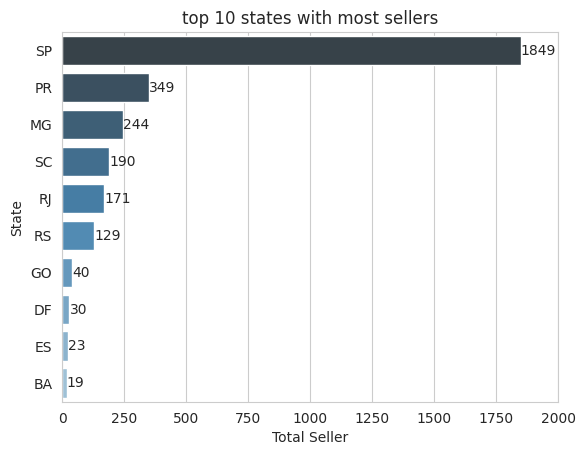

In [49]:
# Set global variable PALETTE
PALETTE = sb.color_palette("Blues_d",10)[::-1]

ax = sb.countplot(data=sellers, y = "seller_state",
             order = sellers["seller_state"].value_counts().index[:10],
                  palette = PALETTE)

for label in ax.containers:
  ax.bar_label(label)

plt.xlabel("Total Seller")
plt.ylabel("State")
plt.xlim(0, 2000)
plt.title("top 10 states with most sellers")
plt.show()

In [50]:
print(f"Persentase jumlah penjual di state SP: {len(sellers[sellers["seller_state"]=="SP"])/len(sellers) *100:.0f} %")

Persentase jumlah penjual di state SP: 60 %


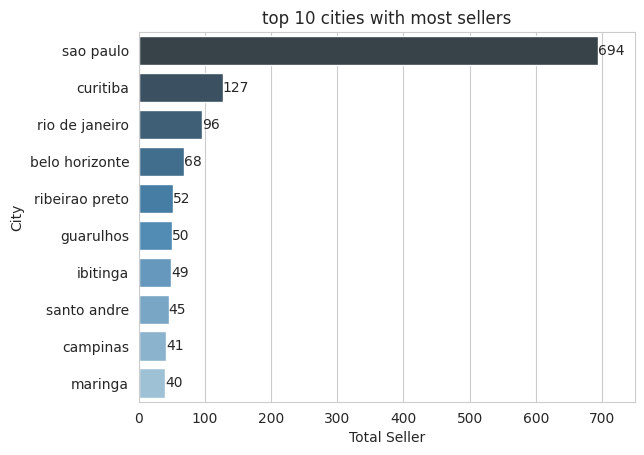

In [51]:
ax = sb.countplot(data=sellers, y = "seller_city",
             order = sellers["seller_city"].value_counts().index[:10],
                  palette = PALETTE)

for label in ax.containers:
  ax.bar_label(label)

plt.xlabel("Total Seller")
plt.ylabel("City")
plt.xlim(0, 750)
plt.title("top 10 cities with most sellers")
plt.show()

In [52]:
print(f"persentase jumlah penjual di Sao Paulo: {len(sellers[sellers["seller_city"]=="sao paulo"])/len(sellers[sellers["seller_state"] == "SP"]) *100:.0f} %")

persentase jumlah penjual di Sao Paulo: 38 %


Insight:

Mayoritas penjual sebanyak 60% (1849) dari total penjual terdapat di provinsi SP, dan di provinsi tersebut, kota sao paulo memiliki penjual terbanyak dengan 30% (694) dari total penjual di provinsi SP.

In [53]:
# Menggabungkan tabel yang digunakan untuk analisis dan machine learning

dfnew = pd.merge(orders, order_items_max, how='left', on='order_id')
dfnew = pd.merge(dfnew, order_reviews, how='left', on='order_id')
dfnew = pd.merge(dfnew, products, how = "left", on="product_id")

# Mengambil baris yang memiliki order_status == delivered
dfnew = dfnew[dfnew["order_status"] == "delivered"]

In [54]:
# Membuat kolom baru untuk payment_values, total_price dan total_freight
# serta mengubah tipe data order_purchase_timestamp dari object ke datetime

dfnew['payment_values'] = ((dfnew['order_item_id']) * (dfnew['price'])) + ((dfnew['order_item_id']) * (dfnew['freight_value']))
dfnew["total_price"] = ((dfnew['order_item_id']) * (dfnew['price']))
dfnew["total_freight"] = ((dfnew['order_item_id']) * (dfnew['freight_value']))
dfnew["order_purchase_timestamp"] = pd.to_datetime(dfnew["order_purchase_timestamp"])

In [55]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97007 entries, 0 to 99991
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97007 non-null  object        
 1   customer_id                    97007 non-null  object        
 2   order_status                   97007 non-null  object        
 3   order_purchase_timestamp       97007 non-null  datetime64[ns]
 4   order_approved_at              96993 non-null  object        
 5   order_delivered_carrier_date   97005 non-null  object        
 6   order_delivered_customer_date  96999 non-null  object        
 7   order_estimated_delivery_date  97007 non-null  object        
 8   order_item_id                  97007 non-null  float64       
 9   product_id                     97007 non-null  object        
 10  seller_id                      97007 non-null  object        
 11  shipping_limit_date 

In [56]:
# Mengecheck data duplikat
dfnew.duplicated().sum()

np.int64(0)

### Total Penjualan per Bulan

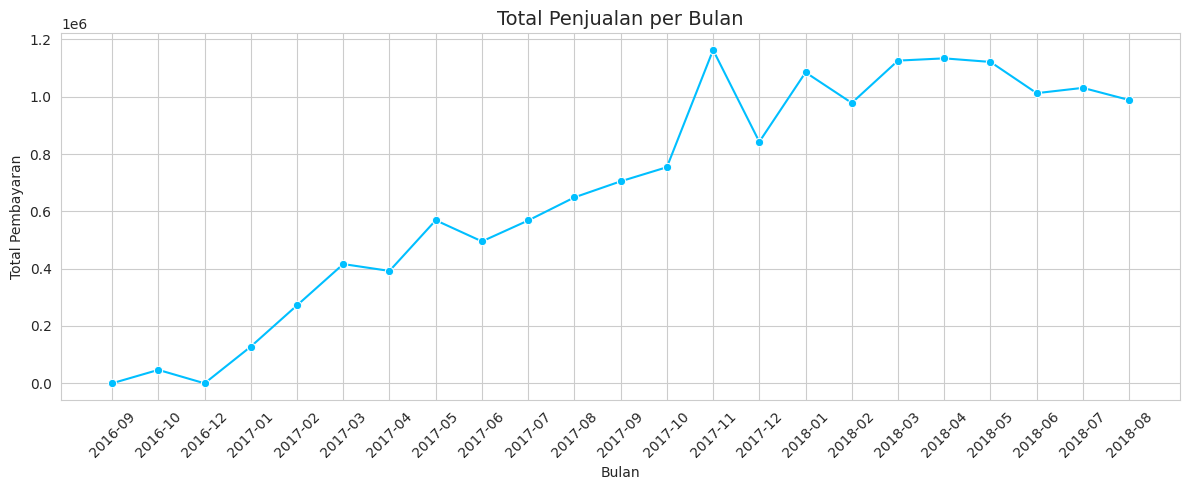

In [57]:
dfnew['order_month'] = dfnew['order_purchase_timestamp'].dt.to_period('M').astype(str)
monthly_sales = dfnew.groupby('order_month')['payment_values'].sum().reset_index()

plt.figure(figsize=(12, 5))
sb.lineplot(data=monthly_sales, x='order_month', y='payment_values', marker='o', color='deepskyblue')

plt.title('Total Penjualan per Bulan', fontsize=14)
plt.xlabel('Bulan')
plt.ylabel('Total Pembayaran')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
monthly_sales

order_month  payment_values
0      2016-09          143.46
1      2016-10        46940.08
2      2016-12           19.62
3      2017-01       128195.81
4      2017-02       272157.96
5      2017-03       416045.90
6      2017-04       392138.90
7      2017-05       568874.48
8      2017-06       495144.97
9      2017-07       568133.63
10     2017-08       648720.21
11     2017-09       704680.80
12     2017-10       753956.90
13     2017-11      1162867.63
14     2017-12       842645.53
15     2018-01      1084801.38
16     2018-02       978144.77
17     2018-03      1125837.72
18     2018-04      1133708.06
19     2018-05      1121205.52
20     2018-06      1012304.95
21     2018-07      1030775.20
22     2018-08       988401.21

Insight:
- Pendapatan terbanyak terdapat pada bulan November 2017 sebanyak R$ 1162867.63.
- Dari bulan Desember 2016 hingga November 2017 terjadi peningkatan pendapatan.
- Bulan Januari 2018 hingga Agustus 2018 cenderung stabil.

### Seller Dengan Gross Revenue Tertinggi

In [59]:
# Menggabungkan dataset seller dengan dfnew
dfnew_seller = pd.merge(sellers, dfnew, how='left', on='seller_id')

In [60]:
# mengecheck seller yang memiliki total pembelian produk terbesar
top_seller = dfnew_seller.groupby('seller_id')['total_price'].sum().sort_values(ascending=False).reset_index()
top_seller.head()

seller_id  total_price
0  4869f7a5dfa277a7dca6462dcf3b52b2    226477.12
1  53243585a1d6dc2643021fd1853d8905    217940.44
2  4a3ca9315b744ce9f8e9374361493884    198341.62
3  fa1c13f2614d7b5c4749cbc52fecda94    191248.85
4  7c67e1448b00f6e969d365cea6b010ab    188786.19

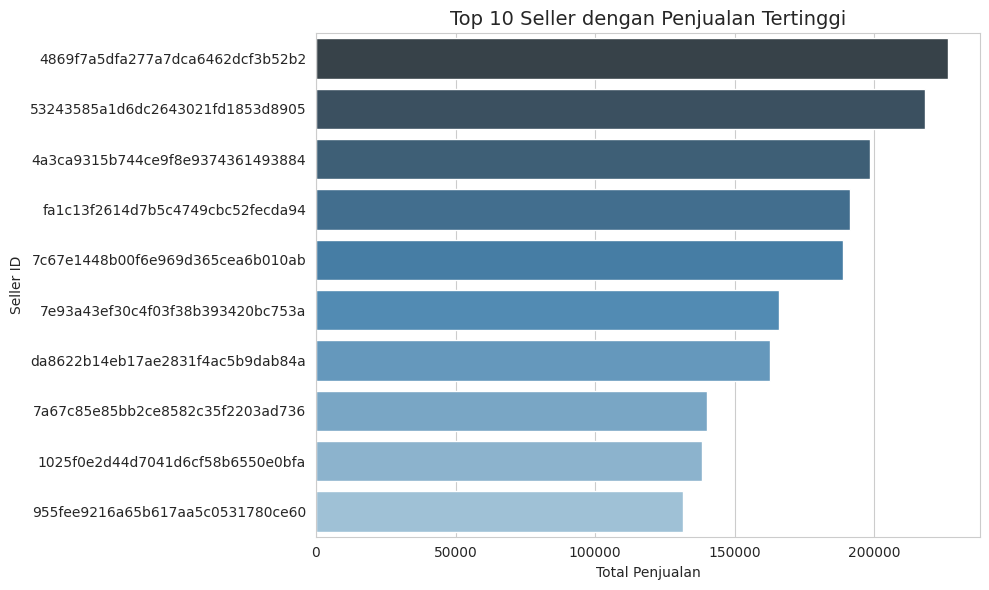

In [61]:
plt.figure(figsize=(10, 6))
sb.barplot(data=top_seller[:10], y='seller_id', x='total_price',
           palette = PALETTE)

plt.title("Top 10 Seller dengan Penjualan Tertinggi", fontsize=14)
plt.xlabel("Total Penjualan")
plt.ylabel("Seller ID")
plt.tight_layout()
plt.show()

Insight:
- Seller dengan ID 4869f7a5dfa277a7dca6462dcf3b52b2 menjadi Seller dengan pendapatan kotor terbanyak dengan angka R$ 226477.12

### State Dengan Penjualan Terbanyak

In [62]:
state_counts = dfnew_seller['seller_state'].value_counts().reset_index()

In [63]:
state_counts.head()

seller_state  count
0           SP  68919
1           MG   7693
2           PR   7501
3           RJ   4195
4           SC   3578

Text(0.5, 1.0, 'Jumlah Transaksi per State')

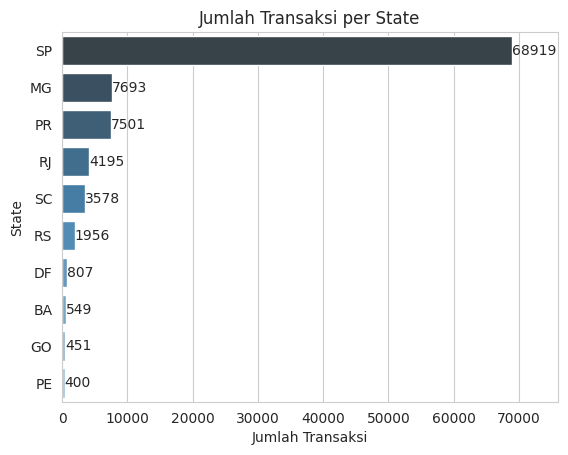

In [64]:
ax = sb.barplot(x=state_counts['count'][:10], y=state_counts['seller_state'][:10],
           palette = PALETTE)

for label in ax.containers:
  ax.bar_label(label)

plt.xlabel("Jumlah Transaksi")
plt.ylabel("State")
plt.xlim(0,76000)
plt.title("Jumlah Transaksi per State")

In [65]:
print(round(state_counts["count"].loc[0]/state_counts['count'].sum() * 100, 2))

70.94


Insight:
- Seller yang provinsinya SP menjadi Seller dengan transaksi terbanyak, terdapat 68830 transaksi, proporsinya sekitar 70.9%.

In [66]:
ref_date = dfnew_seller["order_purchase_timestamp"].max() + pd.Timedelta(days=1)

# Membuat datafram unutk RFM + Rt Analysis dan Machine Learning
df_seller_grouped = dfnew_seller.groupby('seller_id').agg(
    recency=('order_purchase_timestamp', lambda x: (ref_date - x.max()).days),  # Ambil timestamp paling akhir
    frequency=('order_id', 'nunique'),  # Menghitung jumlah order_id unik (frequency)
    monetary=('payment_values', "sum"),  # Total pembayaran (monetary)
    average_rating=('review_score', 'mean'), # Average rating
    total_price =("total_price", "sum"), # Menghitung total transaksi produk
    total_freight = ("total_freight", "sum") # menghitung total ongkir transaksi
).reset_index()

df_seller_grouped.head(10)

seller_id  recency  frequency  monetary  \
0  0015a82c2db000af6aaaf3ae2ecb0532    316.0          3   2748.06   
1  001cca7ae9ae17fb1caed9dfb1094831     49.0        195  33307.42   
2  001e6ad469a905060d959994f1b41e4f      NaN          0      0.00   
3  002100f778ceb8431b7a1020ff7ab48f    140.0         49   1984.75   
4  003554e2dce176b5555353e4f3555ac8    258.0          1    139.38   
5  004c9cd9d87a3c30c522c48c4fc07416    119.0        156  24014.94   
6  00720abe85ba0859807595bbf045a33b     27.0         13   1318.82   
7  00ab3eff1b5192e5f1a63bcecfee11c8    530.0          1    110.08   
8  00d8b143d12632bad99c0ad66ad52825    162.0          1    137.10   
9  00ee68308b45bc5e2660cd833c3f81cc     21.0        132  23522.71   

   average_rating  total_price  total_freight  
0        3.666667      2685.00          63.06  
1        4.062500     24616.93        8690.49  
2             NaN         0.00           0.00  
3        4.020000      1210.50         774.25  
4        5.000000       120.00          19.38  
5        4.150000     20343.19        3671.75  
6        3.615385      1021.10         297.72  
7        5.000000        98.00          12.08  
8        5.000000        86.00          51.10  
9        4.340909     20312.00        3210.71

In [67]:
df_seller_grouped.isna().sum()

seller_id           0
recency           139
frequency           0
monetary            0
average_rating    144
total_price         0
total_freight       0
dtype: int64

In [68]:
# mengisi missing value
df_seller_grouped["average_rating"].fillna(0, inplace=True)
df_seller_grouped["recency"].fillna(df_seller_grouped["recency"].max() + 1, inplace=True)

In [69]:
df_seller_grouped.isna().sum()

seller_id         0
recency           0
frequency         0
monetary          0
average_rating    0
total_price       0
total_freight     0
dtype: int64

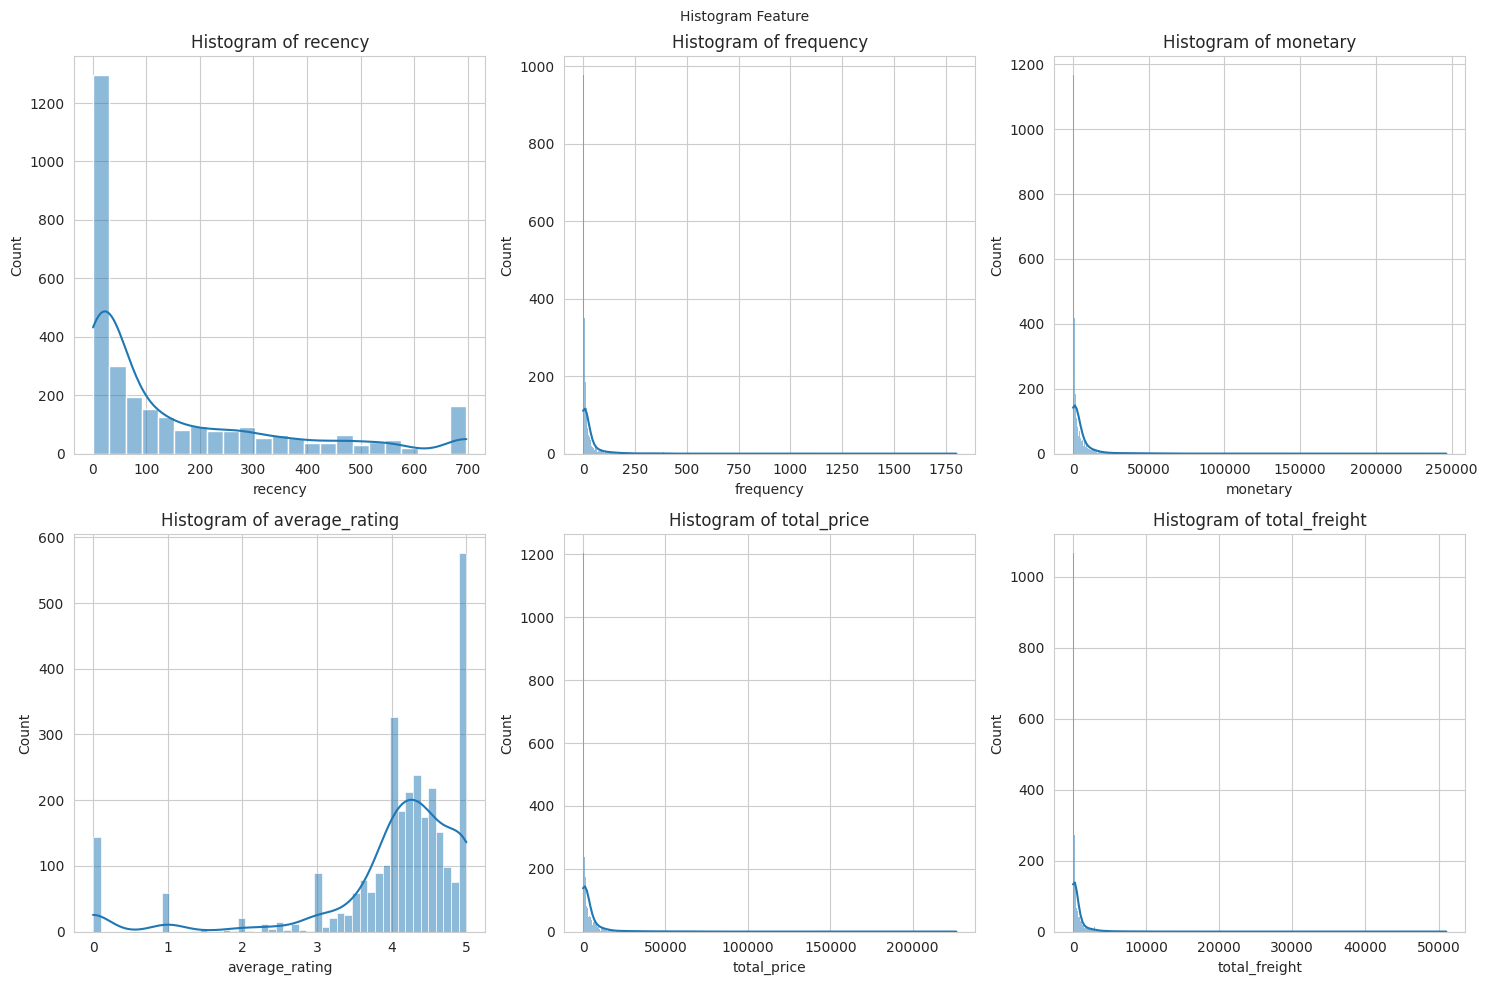

In [70]:
# Daftar kolom numerik yang ingin ditinjau
num_cols = ['recency', 'frequency', 'monetary', 'average_rating', "total_price", "total_freight"]

plt.figure(figsize=(15, 10))

i = 0
for feature in num_cols:
  i += 1
  plt.subplot(2, 3, i)
  sb.histplot(data=df_seller_grouped, x=feature, kde=True,
              palette = PALETTE)
  plt.title(f"Histogram of {feature}")

plt.suptitle("Histogram Feature", fontsize = 10)
plt.tight_layout()
plt.show()

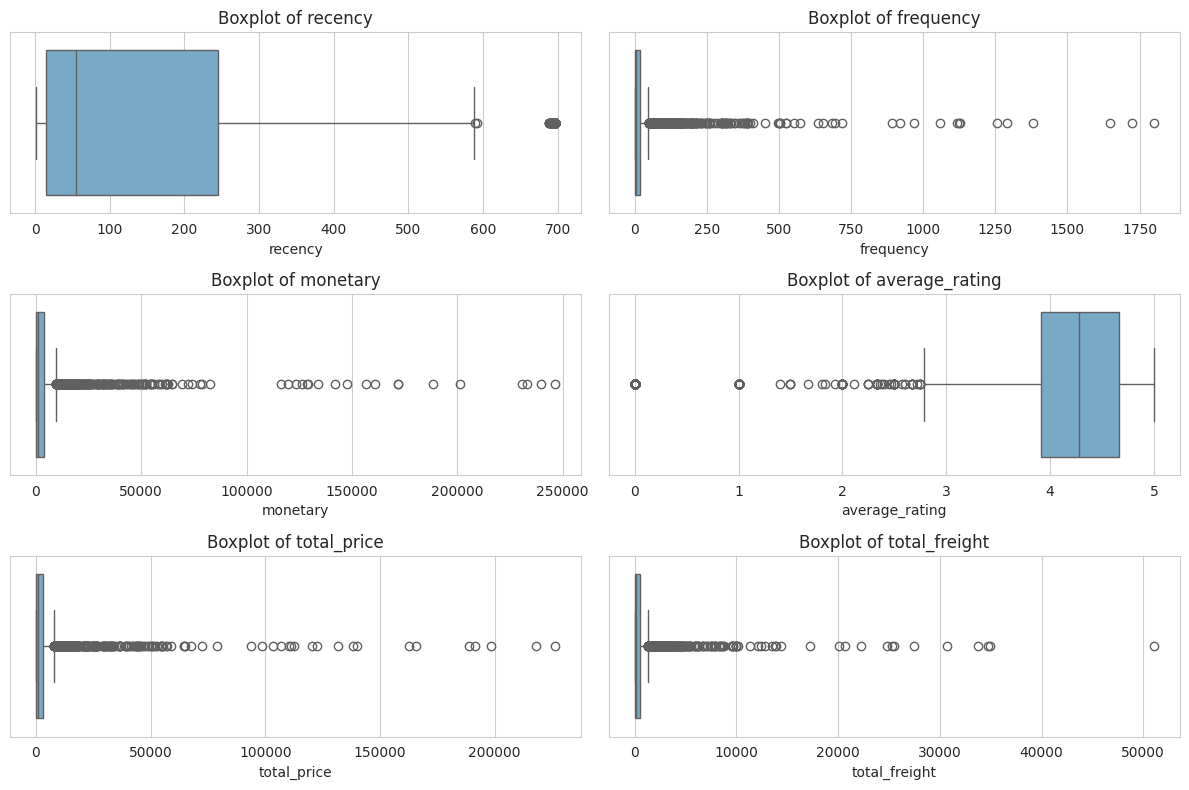

In [71]:
# Daftar kolom numerik yang ingin ditinjau
num_cols = ['recency', 'frequency', 'monetary', 'average_rating', "total_price", "total_freight"]

# Plot boxplot untuk setiap kolom
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sb.boxplot(x=df_seller_grouped[col],
               palette = "Blues")
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Insight:

distribusi recency, frequency, dan monetary dari setiap seller terlihat right skewed. Menunjukkan bahwa majoritas seller memiliki frequency pembelian yang rendah dan juga total monetary yang rendah, namun dapat terlihat bahwa majoritas seller melakukan transaksi terakhir dalam kurun waktu 0-60 hari.

berdasarkan average_rating, banyak seller yang mendapatkan rating berkisar 4 - 5. Hal ini menunjukkan bahwa majoritas seller memberikan pelayanan yang cukup bagus.

In [72]:
# Set global parameter COLORS
COLORS = ["#1446a0", "#db3069", "#f58f29"]

# helper function untuk visualisasi
def plot(df, hue=None, colors = COLORS):
    plt.figure(figsize=(20,15))

    features = ["recency", "frequency", "monetary", "average_rating"]

    i = 0
    for f1, f2 in combinations(features, 2):
      plt.subplot(2, 3, i+1)
      sb.scatterplot(data=df, x=f1, y=f2, hue=hue, palette=colors)
      plt.title(f"{f1} vs {f2}")
      i += 1

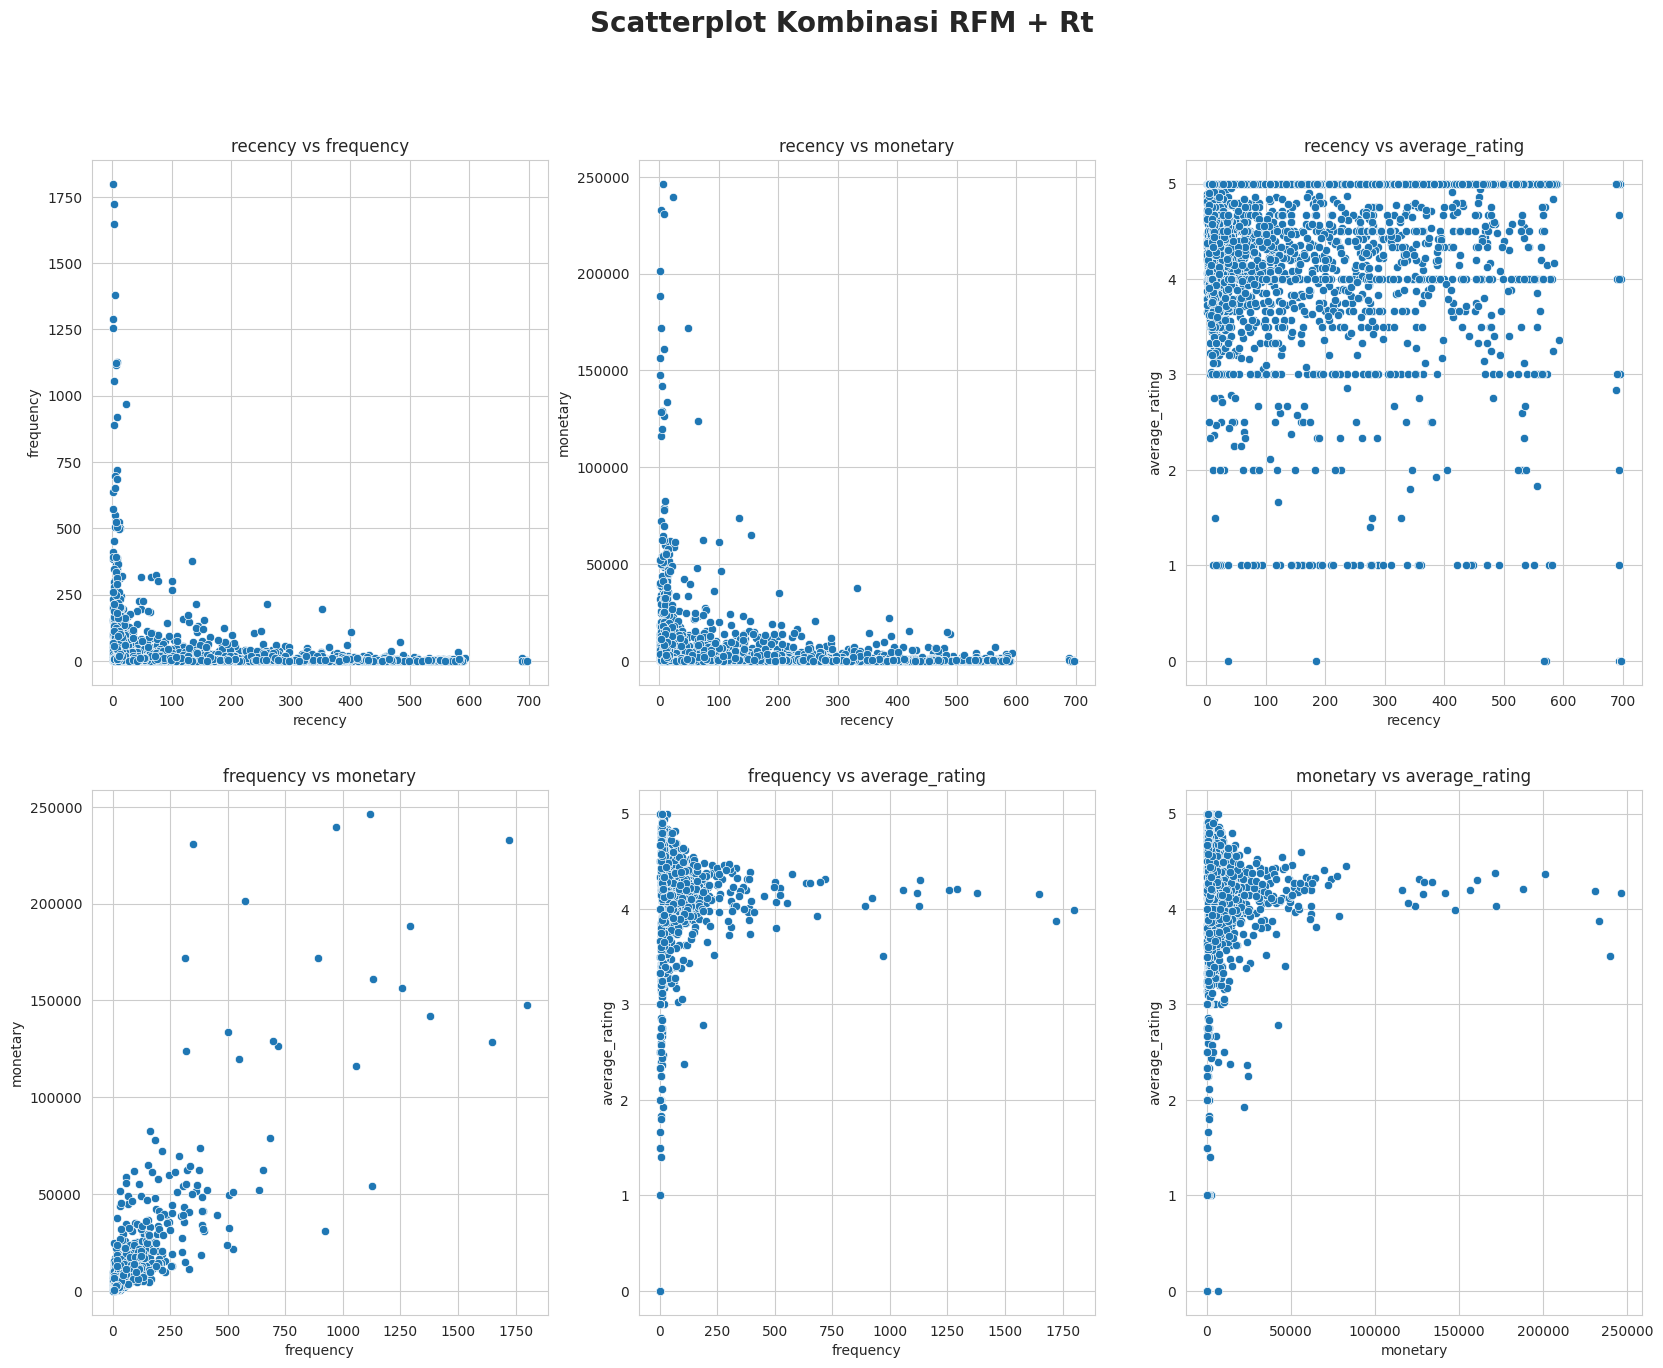

In [73]:
plot(df_seller_grouped, colors = "Blues")
plt.suptitle("Scatterplot Kombinasi RFM + Rt", fontsize = 20,
             weight = "bold")
plt.show()

In [74]:
df_seller_grouped.drop(["seller_id","total_price","total_freight"], axis=1).corr()

recency  frequency  monetary  average_rating
recency         1.000000  -0.178278 -0.174740       -0.490788
frequency      -0.178278   1.000000  0.836850        0.038744
monetary       -0.174740   0.836850  1.000000        0.037761
average_rating -0.490788   0.038744  0.037761        1.000000

insight:
- Frequency dan monetary memiliki korelasi positif yang tinggi (0.8), terdapat pola di scatterplot mendukung korelasi ini
- relasi feature lainnya terlihat tidak memiliki korelasi yang signifikant
- terlihat bahwa semakin meningkatnya nilai recency (semakin lama produk dari seller tersebut tidak dibeli) maka frequency dan monetary nya cenderung kecil, namun memiliki recency rendah tidak menentukan bahwa seller memiliki frequency dan monetary tinggi
- seller yang memiliki rating berkisar 4 - 4.5 berpotensi untuk memiliki frequency dan monetary yang tinggi
- tidak terlihat adanya pola yang signifikan antara rating dan recency dari seller

### product

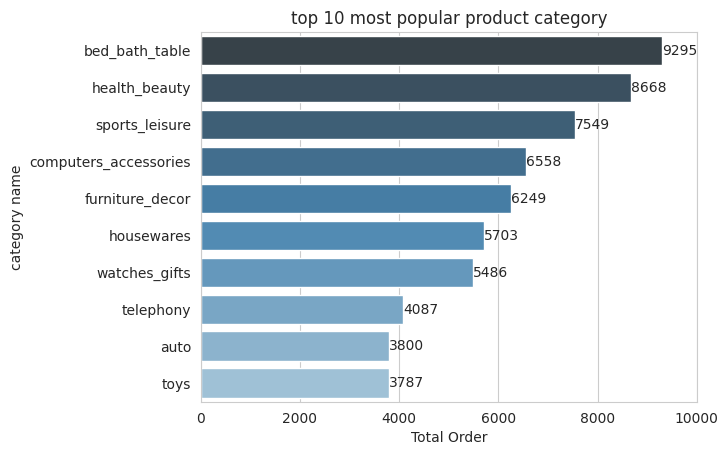

In [75]:
ax = sb.countplot(data = dfnew,
             y = "product_category_name_english",
             order = dfnew["product_category_name_english"].value_counts().index[:10],
                  palette = PALETTE)

for label in ax.containers:
  ax.bar_label(label)

plt.ylabel("category name")
plt.xlabel("Total Order")
plt.xlim(0, 10000)
plt.title("top 10 most popular product category")
plt.show()

### Payment method


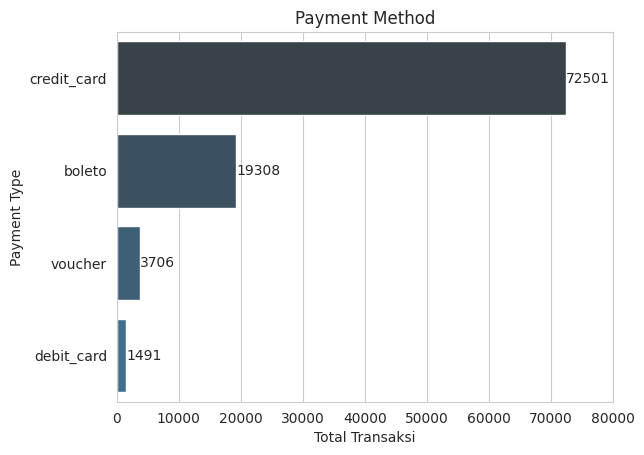

In [76]:
# memilih baris dengan payment_sequential maksimum per order_id
order_payments_max = order_payments.loc[
    order_payments.groupby("order_id")["payment_sequential"].idxmax()
].reset_index(drop=True)

# menggabungkan dfnew dengan dorder_payments_max
payment_df = pd.merge(dfnew, order_payments_max, how='left', on='order_id')

ax = sb.countplot(data = payment_df,
             y = "payment_type",
             order = payment_df["payment_type"].value_counts().index,
                  palette = PALETTE)

for label in ax.containers:
  ax.bar_label(label)

plt.xlabel("Total Transaksi")
plt.ylabel("Payment Type")
plt.xlim(0, 80000)
plt.title("Payment Method")
plt.show()

## 7. Modeling

### Rule-based

#### Segmentasi Seller Berdasarkan RFM + Rt (Scoring Method)

#### Skema Scoring
Setiap parameter diberi skor sesuai level:

- **Recency (R)**
  - R1 (Buruk, >360 hari) = 1
  - R2 (Sedang, 121–360 hari) = 2
  - R3 (Baik, ≤120 hari) = 3

- **Frequency (F)**
  - F1 (Rendah, 1–20 transaksi) = 1
  - F2 (Sedang, 21–100 transaksi) = 2
  - F3 (Tinggi, >100 transaksi) = 3

- **Monetary (M)**
  - M1 (Rendah, ≤150 BRL) = 1
  - M2 (Sedang, 151–600 BRL) = 2
  - M3 (Tinggi, >600 BRL) = 3

- **Rating (Rt)**
  - Rt1 (Buruk, <3.0) = 1
  - Rt2 (Sedang, 3.0 – 4.4) = 2
  - Rt3 (Baik, ≥4.5) = 3

**Total Skor = R + F + M + Rt (rentang 4–12).**

---

#### Kategori Segmentasi

#### 1. Top Sellers
- **Total Skor:** 10 – 12
- **Ciri-ciri:**  
  - Baru saja bertransaksi (Recency bagus)  
  - Frekuensi tinggi  
  - Nilai transaksi tinggi  
  - Rating baik  
- **Interpretasi:** Seller paling berharga dan konsisten.  
- **Strategi:** Pertahankan dengan loyalty program, benefit eksklusif, dan dukungan prioritas.  

---

#### 2. Steady Sellers
- **Total Skor:** 7 – 9
- **Ciri-ciri:**  
  - Aktif tapi tidak selalu konsisten  
  - Frekuensi atau nilai masih sedang  
  - Rating cukup baik  
- **Interpretasi:** Seller berpotensi naik kelas menjadi Top Sellers bila didorong.  
- **Strategi:** Dorong transaksi dengan promo, edukasi seller, dan campaign peningkatan penjualan.  

---

#### 3. Casual Sellers
- **Total Skor:** 4 – 6
- **Ciri-ciri:**  
  - Jarang transaksi  
  - Nilai transaksi rendah  
  - Rating buruk  
- **Interpretasi:** Seller kontribusinya rendah, beberapa bahkan tidak aktif.  
- **Strategi:** Evaluasi apakah masih perlu difokuskan, lakukan program reaktivasi, atau biarkan non-aktif.


#### Treatment Seller Berdasarkan Segmentasi RFM + Rt

#### 1. Top Sellers Seller
| Strategi                          | Deskripsi                                      | Estimasi Biaya / Seller (BRL) |
|-----------------------------------|------------------------------------------------|--------------------------|
| Loyalty Program                   | Poin reward, cashback, hadiah eksklusif        |  120                  |
| Insentif Transaksi                | Potongan komisi/bonus tiap pencapaian target   | 80                   |
| Promosi VIP                       | Eksposur lebih tinggi di platform              | 50                   |
| **Total per Seller (Top Sellers)** |                                                | **250**              |

#### 2. Steady Sellers Seller
| Strategi                          | Deskripsi                                      | Estimasi Biaya / Seller (BRL) |
|-----------------------------------|------------------------------------------------|--------------------------|
| Training & Edukasi                | Webinar, workshop, modul online                | 40                   |
| Subsidi Promosi                   | Diskon iklan & biaya campaign                  | 60                   |
| Reward Target                     | Insentif jika naik ke kategori Top Sellers      | 30                   |
| **Total per Seller (Steady Sellers)** |                                              | **130**              |

#### 3. Casual Sellers Seller
| Strategi                          | Deskripsi                                      | Estimasi Biaya / Seller (BRL) |
|-----------------------------------|------------------------------------------------|--------------------------|
| Reaktivasi Marketing              | Email, SMS, push notification khusus           | 20                   |
| Voucher Transaksi                  | Kupon diskon untuk memicu transaksi pertama    | 30                   |
| Seleksi & Evaluasi                 | Monitoring, potensi offboarding seller pasif   | 10                   |
| **Total per Seller (Casual Sellers)**   |                                                | **60**               |


In [77]:
# ----- fungsi scoring -----
def r_score(x):
    # Recency: <=120 -> 3, 121-360 -> 2, >360 -> 1
    if pd.isna(x):
        return 1
    if x <= 120:
        return 3
    elif x <= 360:
        return 2
    else:
        return 1

def f_score(x):
    # Frequency: 1-20 -> 1, 21-100 -> 2, >100 -> 3
    if pd.isna(x):
        return 1
    if x > 100:
        return 3
    elif x >= 21:
        return 2
    else:
        return 1

def m_score(x):
    # Monetary (BRL): <=150 -> 1, 151-600 -> 2, >600 -> 3
    if pd.isna(x):
        return 1
    if x > 600:
        return 3
    elif x >= 151:
        return 2
    else:
        return 1

def rating_score(x):
    # Rating: <3.0 -> 1, 3.0-4.4 -> 2, >=4.5 -> 3
    if pd.isna(x):
        return 1
    if x >= 4.5:
        return 3
    elif x >= 3.0:
        return 2
    else:
        return 1

# ----- terapkan scoring ke DataFrame -----
df = df_seller_grouped.copy()

df['R_score'] = df['recency'].apply(r_score)
df['F_score'] = df['frequency'].apply(f_score)
df['M_score'] = df['monetary'].apply(m_score)
df['Rating_score'] = df['average_rating'].apply(rating_score)

# Total skor (range 4 - 12)
df['Total_score'] = df[['R_score','F_score','M_score','Rating_score']].sum(axis=1)

# ----- assign segment berdasarkan Total_score -----
def assign_segment(total):
    if total >= 10:
        return "Top Sellers"
    elif total >= 7:
        return "Steady Sellers"
    else:
        return "Casual Sellers"

df['Cluster'] = df['Total_score'].apply(assign_segment)

# Lihat distribusi segmen
print(df['Cluster'].value_counts())
# (opsional) lihat contoh hasil kolom skor per seller
print(df[['R_score','F_score','M_score','Rating_score','Total_score','Cluster']].head())

Cluster
Steady Sellers    1734
Top Sellers        945
Casual Sellers     416
Name: count, dtype: int64
   R_score  F_score  M_score  Rating_score  Total_score         Cluster
0        2        1        3             2            8  Steady Sellers
1        3        3        3             2           11     Top Sellers
2        1        1        1             1            4  Casual Sellers
3        2        2        3             2            9  Steady Sellers
4        2        1        1             3            7  Steady Sellers


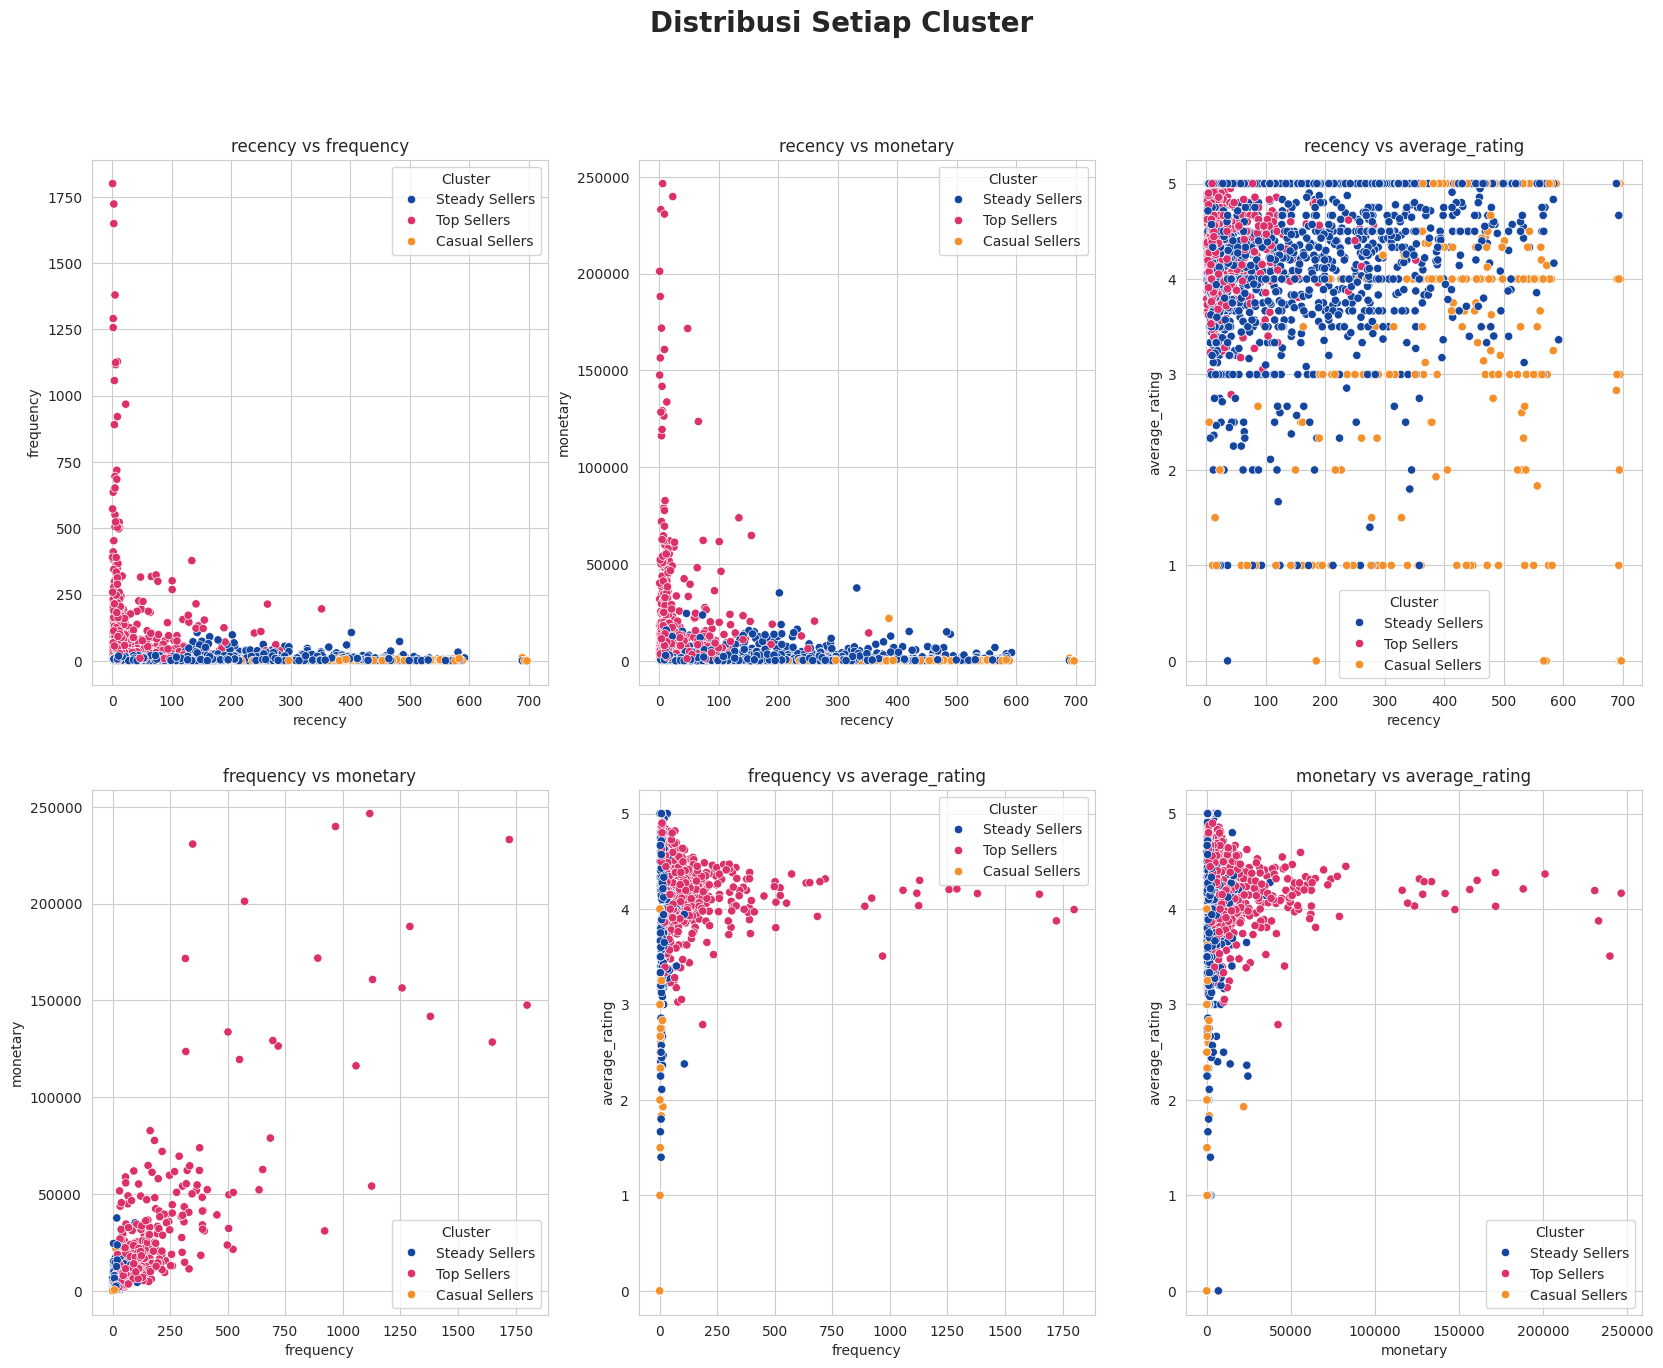

In [78]:
plot(df, hue = "Cluster")
plt.suptitle("Distribusi Setiap Cluster", fontsize = 20,
             weight = "bold")
plt.show()

In [79]:
# Ambil kolom numerik yang diperlukan
X = df_seller_grouped[['recency','frequency','monetary','average_rating']]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label cluster dari rule-based
labels = df['Cluster']

# Hitung metrik evaluasi
silhouette = silhouette_score(X_scaled, labels)
dbi = davies_bouldin_score(X_scaled, labels)
chi = calinski_harabasz_score(X_scaled, labels)


# memunculkan hasilnya
df_result = pd.DataFrame()
df_result["Analysis"] = ["Rule-based"]
df_result["Silhouette Score"] = [silhouette]
df_result["Davies-Bouldin Index"] = [dbi]
df_result["Calinksi-Harabasz Index"] = [chi]
df_result

Analysis  Silhouette Score  Davies-Bouldin Index  Calinksi-Harabasz Index
0  Rule-based           0.16291              1.545813               644.776833

In [80]:
df["Cluster"].value_counts()

Cluster
Steady Sellers    1734
Top Sellers        945
Casual Sellers     416
Name: count, dtype: int64

#### Perhitungan cost

Top Sellers : R\$ 250 * 945 = R\$ 236.250

Steady Sellers : R\$ 130 * 1734 = R\$ 225.420

Casual Sellers : R\$ 60 * 277 = R\$ 16.620

Total cost = R\$ 478.290

## Machine Learning

### DBSCAN

In [81]:
df_train = RobustScaler().fit_transform(df_seller_grouped[['recency', 'frequency', 'monetary', 'average_rating']])
df_train

array([[ 1.1372549 , -0.16666667,  0.49708177, -0.80882031],
       [-0.02614379, 10.5       ,  8.90425498, -0.28402518],
       [ 2.79738562, -0.33333333, -0.2589359 , -5.67008056],
       ...,
       [ 0.23093682,  0.44444444,  0.36268799, -0.08278794],
       [-0.22222222,  2.77777778,  2.88179779, -0.48741468],
       [ 2.30065359,  0.11111111, -0.12843767, -1.36123625]])

In [82]:
# Parameter yang tertulis adalah parameter yang telah dituning.
# Kita telah mencoba dengan range nilai epsilon dan min_samples yang lebih besar
# dan DBSCAN menghasilkan 1 cluster dan noise.
# Hal ini dikarenakan jarak antara 1 cluster dengan cluster lainnya berdekatan.
epsilon = np.arange(0.1,1,0.1)
min_samples = range(5,8)
tuning_result = []

for eps in epsilon:
    for sam in min_samples:
        model = DBSCAN(eps=eps, min_samples=sam, n_jobs=-1)
        result = model.fit_predict(df_train)
        tuning_result.append((eps, sam, silhouette_score(df_train, result),
                              davies_bouldin_score(df_train, result), calinski_harabasz_score(df_train, result),
                              len(np.unique(result))))

dbscan_result = pd.DataFrame(tuning_result, columns=['eps', 'min_samples', 'silhouette_score',
                                                 "davies_bouldin_score", "calinski_harabasz_score", "total_cluster"])
dbscan_result = dbscan_result[dbscan_result["total_cluster"] > 2]

# based on davies_boulding_score
dbscan_result.sort_values(by="silhouette_score", ascending=False).head(10)

eps  min_samples  silhouette_score  davies_bouldin_score  \
26  0.9            7          0.573975              0.830584   
24  0.9            5          0.530808              1.267084   
25  0.9            6          0.526996              1.200086   
21  0.8            5          0.521447              1.456380   
20  0.7            7          0.497357              1.414053   
19  0.7            6          0.448323              1.332704   
16  0.6            6          0.427412              1.445099   
17  0.6            7          0.420333              1.622813   
13  0.5            6          0.397732              1.635644   
12  0.5            5          0.334846              1.360045   

    calinski_harabasz_score  total_cluster  
26              1030.534316              3  
24               557.741964              5  
25               552.168084              5  
21               404.217183              6  
20               511.329173              4  
19               407.279933              5  
16               353.864466              5  
17               271.536844              6  
13               232.906882              6  
12               244.459254              6

In [83]:
model = DBSCAN(eps=0.9, min_samples=7)
result = model.fit_predict(df_train)
df_seller_grouped['cluster'] = result
df_seller_grouped.head()

seller_id  recency  frequency  monetary  \
0  0015a82c2db000af6aaaf3ae2ecb0532    316.0          3   2748.06   
1  001cca7ae9ae17fb1caed9dfb1094831     49.0        195  33307.42   
2  001e6ad469a905060d959994f1b41e4f    697.0          0      0.00   
3  002100f778ceb8431b7a1020ff7ab48f    140.0         49   1984.75   
4  003554e2dce176b5555353e4f3555ac8    258.0          1    139.38   

   average_rating  total_price  total_freight  cluster  
0        3.666667      2685.00          63.06        0  
1        4.062500     24616.93        8690.49       -1  
2        0.000000         0.00           0.00        1  
3        4.020000      1210.50         774.25        0  
4        5.000000       120.00          19.38        0

In [84]:
df_seller_grouped["cluster"].value_counts()

cluster
 0    2760
-1     193
 1     142
Name: count, dtype: int64

In [85]:
df_result

Analysis  Silhouette Score  Davies-Bouldin Index  Calinksi-Harabasz Index
0  Rule-based           0.16291              1.545813               644.776833

In [86]:
dbscan_sil = silhouette_score(df_train, result)
dbscan_dbi = davies_bouldin_score(df_train, result)
dbscan_chi = calinski_harabasz_score(df_train, result)

# memasukkan hasil metric ke df_result
df_result.loc[len(df_result)] = ["DBSCAN", dbscan_sil, dbscan_dbi, dbscan_chi]
df_result

Analysis  Silhouette Score  Davies-Bouldin Index  Calinksi-Harabasz Index
0  Rule-based          0.162910              1.545813               644.776833
1      DBSCAN          0.573975              0.830584              1030.534316

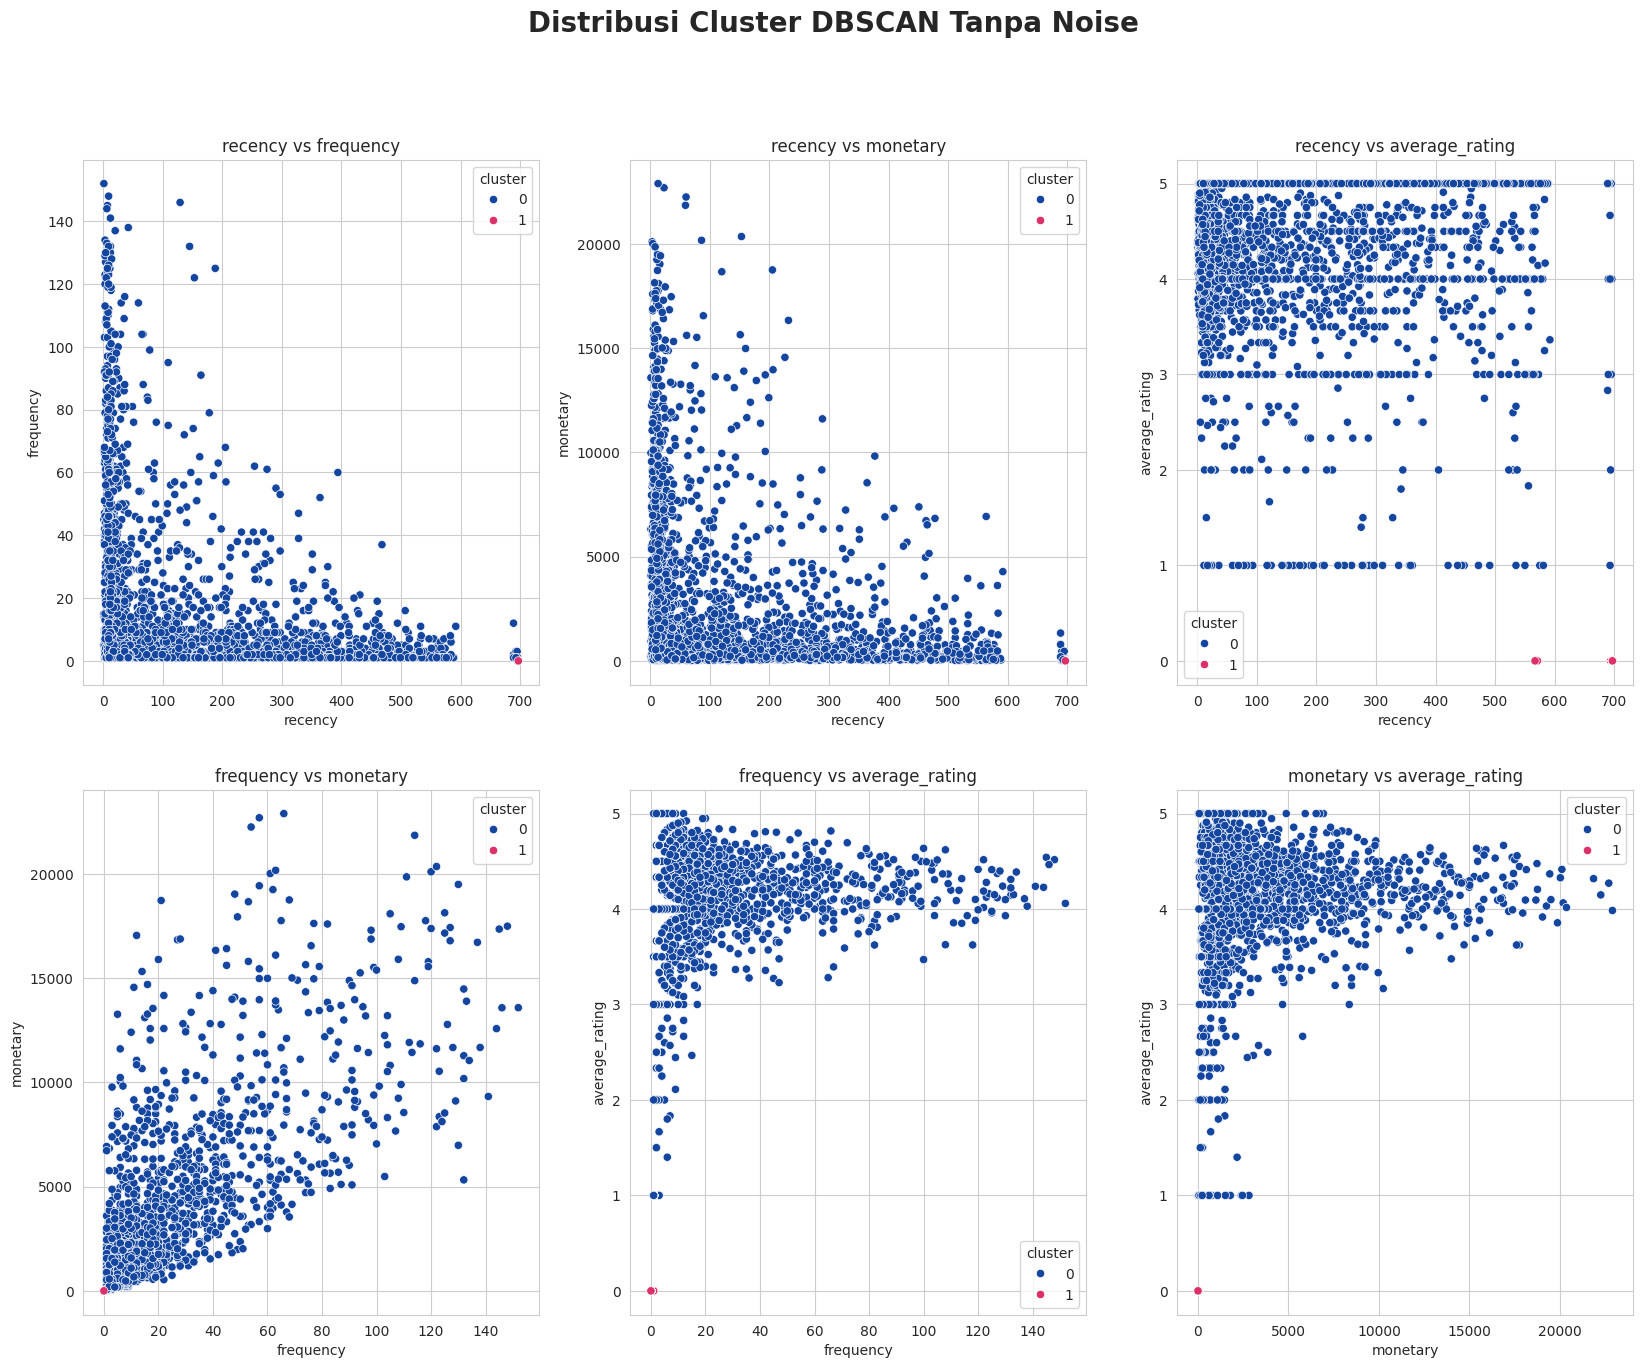

In [87]:
plot(df_seller_grouped[df_seller_grouped["cluster"] != -1], hue = "cluster")
plt.suptitle("Distribusi Cluster DBSCAN Tanpa Noise", fontsize = 20,
             weight = "bold")
plt.show()

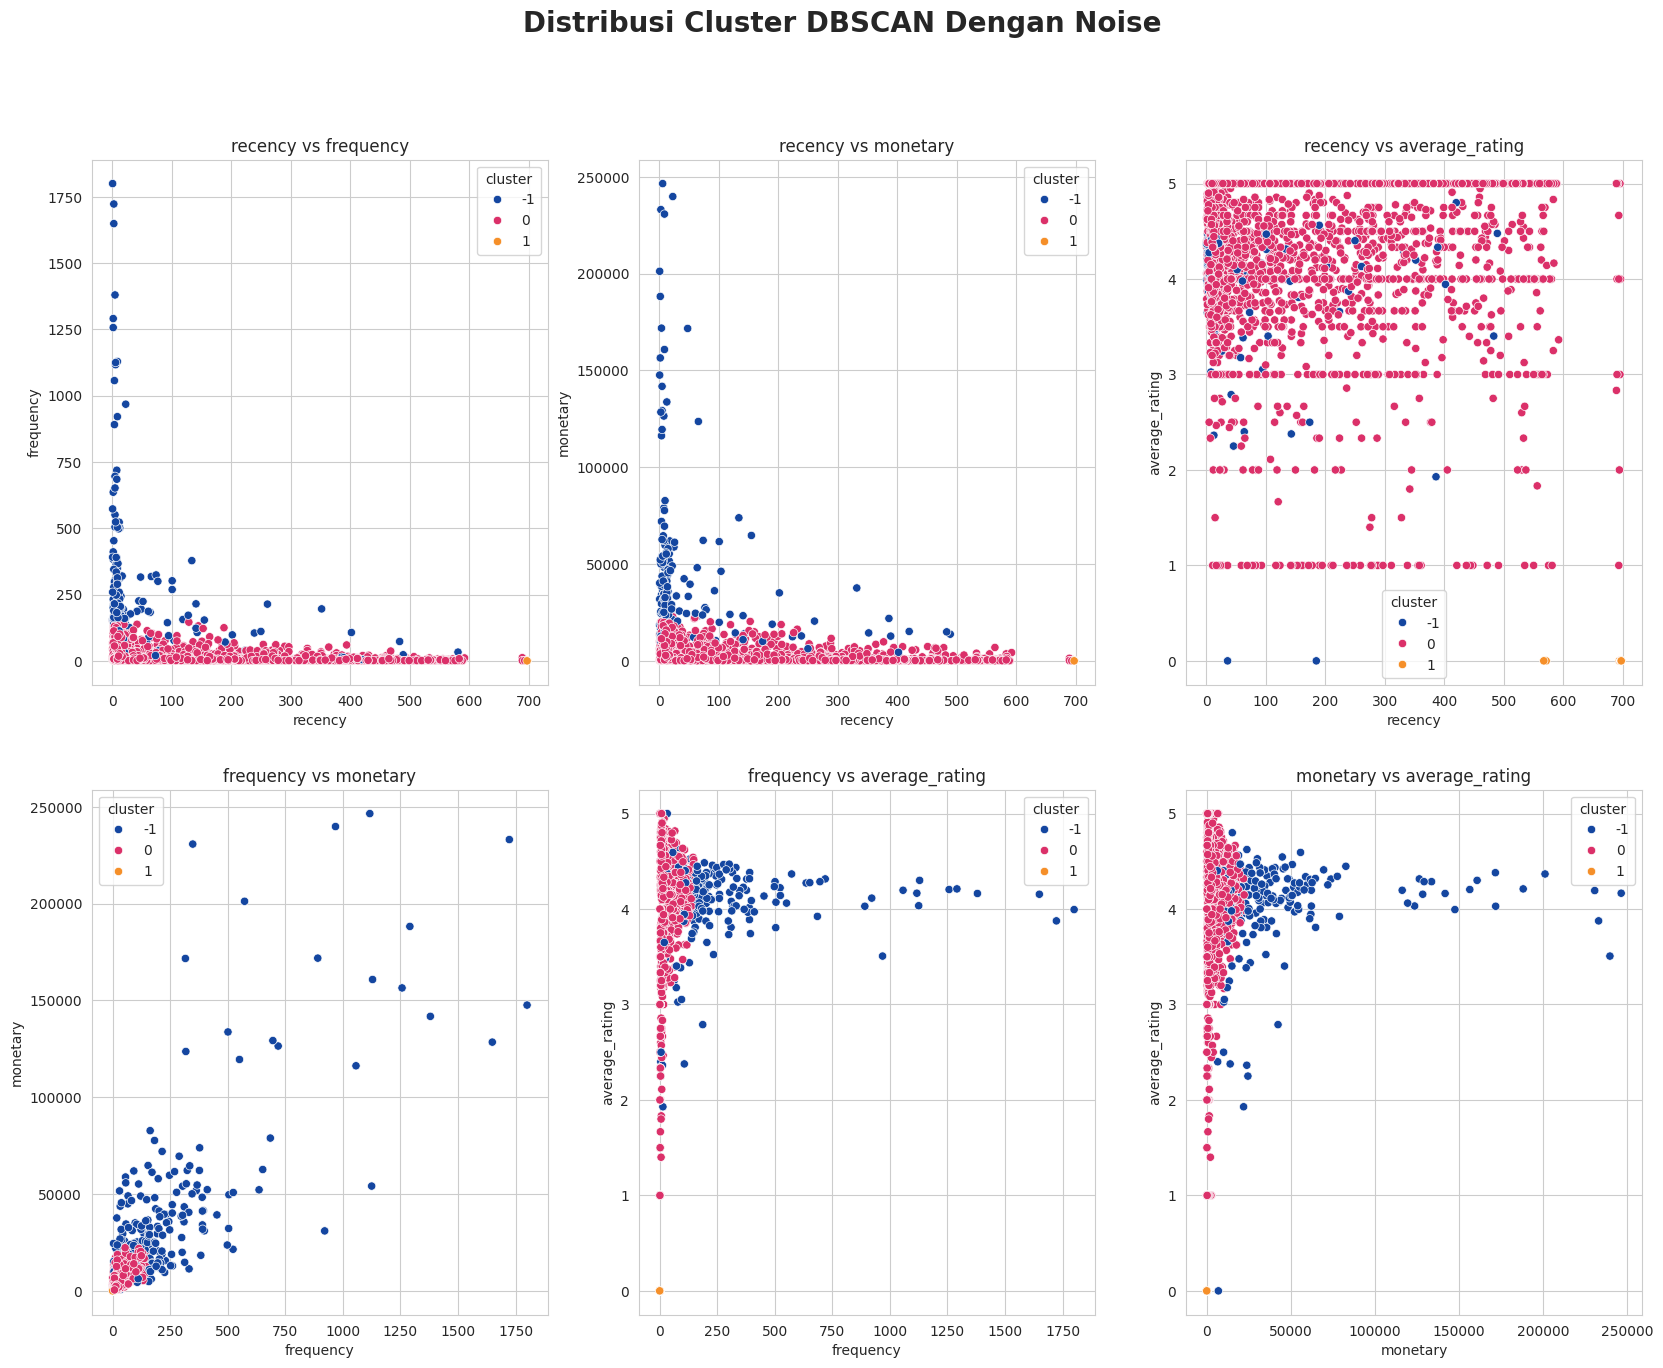

In [88]:
plot(df_seller_grouped, hue = "cluster")
plt.suptitle("Distribusi Cluster DBSCAN Dengan Noise", fontsize = 20,
             weight = "bold")
plt.show()

### KMeans

#### Define X

In [89]:
X = df_seller_grouped[['recency', 'frequency', 'monetary', 'average_rating']]
X.head()

recency  frequency  monetary  average_rating
0    316.0          3   2748.06        3.666667
1     49.0        195  33307.42        4.062500
2    697.0          0      0.00        0.000000
3    140.0         49   1984.75        4.020000
4    258.0          1    139.38        5.000000

#### Pipeline Model

In [90]:
kmeans_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('kmeans', KMeans(random_state=0))
])

#### Modeling

In [91]:
listInertia= []
listJumlahCluster = []
listSilhouette = []
listDBI = []
listCHI = []

for i in range(2, 20, 1):
    kmeans_pipeline.set_params(kmeans__n_clusters=i)
    kmeans_pipeline.fit(X)
    listInertia.append(kmeans_pipeline.named_steps["kmeans"].inertia_)
    listJumlahCluster.append(i)
    listSilhouette.append(silhouette_score(X, kmeans_pipeline.named_steps["kmeans"].labels_))
    listDBI.append(davies_bouldin_score(X, kmeans_pipeline.named_steps["kmeans"].labels_))
    listCHI.append(calinski_harabasz_score(X, kmeans_pipeline.named_steps["kmeans"].labels_))

In [92]:
df_best_kmeans = pd.DataFrame()
df_best_kmeans['JumlahCluster'] = listJumlahCluster
df_best_kmeans['Inertia'] = listInertia
df_best_kmeans['Silhouette'] = listSilhouette
df_best_kmeans['DBI'] = listDBI
df_best_kmeans['CHI'] = listCHI

In [93]:
df_best_kmeans

JumlahCluster       Inertia  Silhouette        DBI          CHI
0               2  71693.871540    0.949395   0.372446  4816.961838
1               3  44604.200683    0.853399   0.535755  5040.082335
2               4  34886.282103    0.741998   0.669892  4565.970298
3               5  28329.261998    0.737286   4.569733  4557.338602
4               6  22186.736337   -0.188741   4.145145  3660.651914
5               7  19551.570793   -0.096577   2.649467  3335.935409
6               8  18366.577115   -0.180645   1.409975  3369.209128
7               9  16189.259040   -0.117104   1.535221  3274.109169
8              10  14140.340139   -0.116589   3.411261  2895.519907
9              11  12464.917334   -0.097562   4.197414  3149.256304
10             12  11389.264049   -0.098123   6.978139  2959.829457
11             13  10901.066577   -0.097865   6.944027  2667.411597
12             14   9999.605974   -0.024740   6.373070  2680.289888
13             15   9218.785047   -0.065918   8.285071  2481.215897
14             16   8697.468030   -0.060791   7.609030  2556.921872
15             17   7789.937112   -0.060536   5.606645  3193.453185
16             18   7288.737500   -0.050033  10.175459  3069.008190
17             19   6869.511470   -0.066116   7.439544  3287.288995

In [94]:
df_best_kmeans["JumlahCluster"]

0      2
1      3
2      4
3      5
4      6
5      7
6      8
7      9
8     10
9     11
10    12
11    13
12    14
13    15
14    16
15    17
16    18
17    19
Name: JumlahCluster, dtype: int64

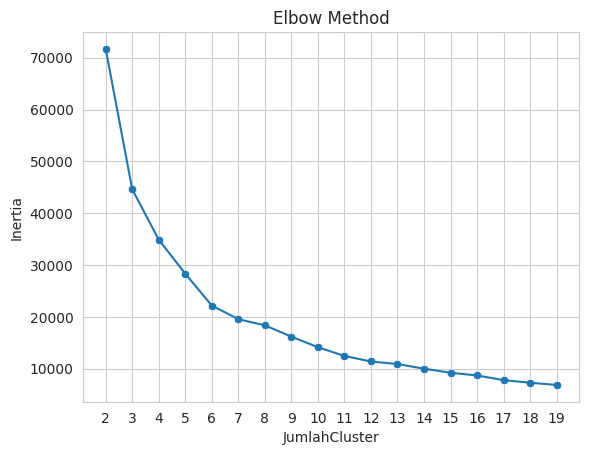

In [95]:
# Elbow Method
sb.scatterplot(data=df_best_kmeans, x='JumlahCluster', y='Inertia')
sb.lineplot(data=df_best_kmeans, x='JumlahCluster', y='Inertia')
plt.title('Elbow Method')

plt.xticks(df_best_kmeans['JumlahCluster'])
plt.show()

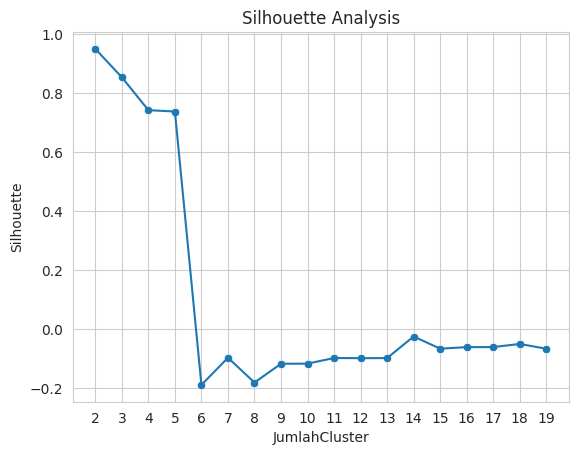

In [96]:
# Silhouette Analysis
sb.scatterplot(data=df_best_kmeans, x='JumlahCluster', y='Silhouette')
sb.lineplot(data=df_best_kmeans, x='JumlahCluster', y='Silhouette')
plt.title('Silhouette Analysis')

plt.xticks(df_best_kmeans['JumlahCluster'])
plt.show()

Berdasarkan Elbow Method dan Silhouette Analysis, kita memilih untuk membagi seller menjadi 3 cluster. Dengan 3 cluster, hasil cluster masih memiliki silhouette score, DBI dan CHI yang cukup bagus dan didukung dengan elbow method yang mendekati nilai lebih ideal dibandingkan dengan 2 cluster.

In [97]:
# dengan best parameter
kmeans_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=0))
])

# fit
kmeans_pipeline.fit(X)

Pipeline(steps=[('scaler', RobustScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=0))])

In [98]:
# kmeans memberi nama cluster pada tiap data point
kmeans_pipeline.named_steps["kmeans"].labels_

array([0, 2, 0, ..., 0, 0, 0], dtype=int32)

In [99]:
df_seller_grouped['k_means_cluster'] = kmeans_pipeline.named_steps["kmeans"].labels_
df_seller_grouped.head()

seller_id  recency  frequency  monetary  \
0  0015a82c2db000af6aaaf3ae2ecb0532    316.0          3   2748.06   
1  001cca7ae9ae17fb1caed9dfb1094831     49.0        195  33307.42   
2  001e6ad469a905060d959994f1b41e4f    697.0          0      0.00   
3  002100f778ceb8431b7a1020ff7ab48f    140.0         49   1984.75   
4  003554e2dce176b5555353e4f3555ac8    258.0          1    139.38   

   average_rating  total_price  total_freight  cluster  k_means_cluster  
0        3.666667      2685.00          63.06        0                0  
1        4.062500     24616.93        8690.49       -1                2  
2        0.000000         0.00           0.00        1                0  
3        4.020000      1210.50         774.25        0                0  
4        5.000000       120.00          19.38        0                0

In [100]:
df_seller_grouped["k_means_cluster"].value_counts()

k_means_cluster
0    2952
2     127
1      16
Name: count, dtype: int64

In [101]:
kmeans_sil = silhouette_score(X, kmeans_pipeline.named_steps["kmeans"].labels_)
kmeans_dbi = davies_bouldin_score(X, kmeans_pipeline.named_steps["kmeans"].labels_)
kmeans_chi = calinski_harabasz_score(X, kmeans_pipeline.named_steps["kmeans"].labels_)

# Menambah hasilnya ke df_Result
df_result.loc[len(df_result)] = ["KMeans", kmeans_sil, kmeans_dbi, kmeans_chi]
df_result

Analysis  Silhouette Score  Davies-Bouldin Index  Calinksi-Harabasz Index
0  Rule-based          0.162910              1.545813               644.776833
1      DBSCAN          0.573975              0.830584              1030.534316
2      KMeans          0.853399              0.535755              5040.082335

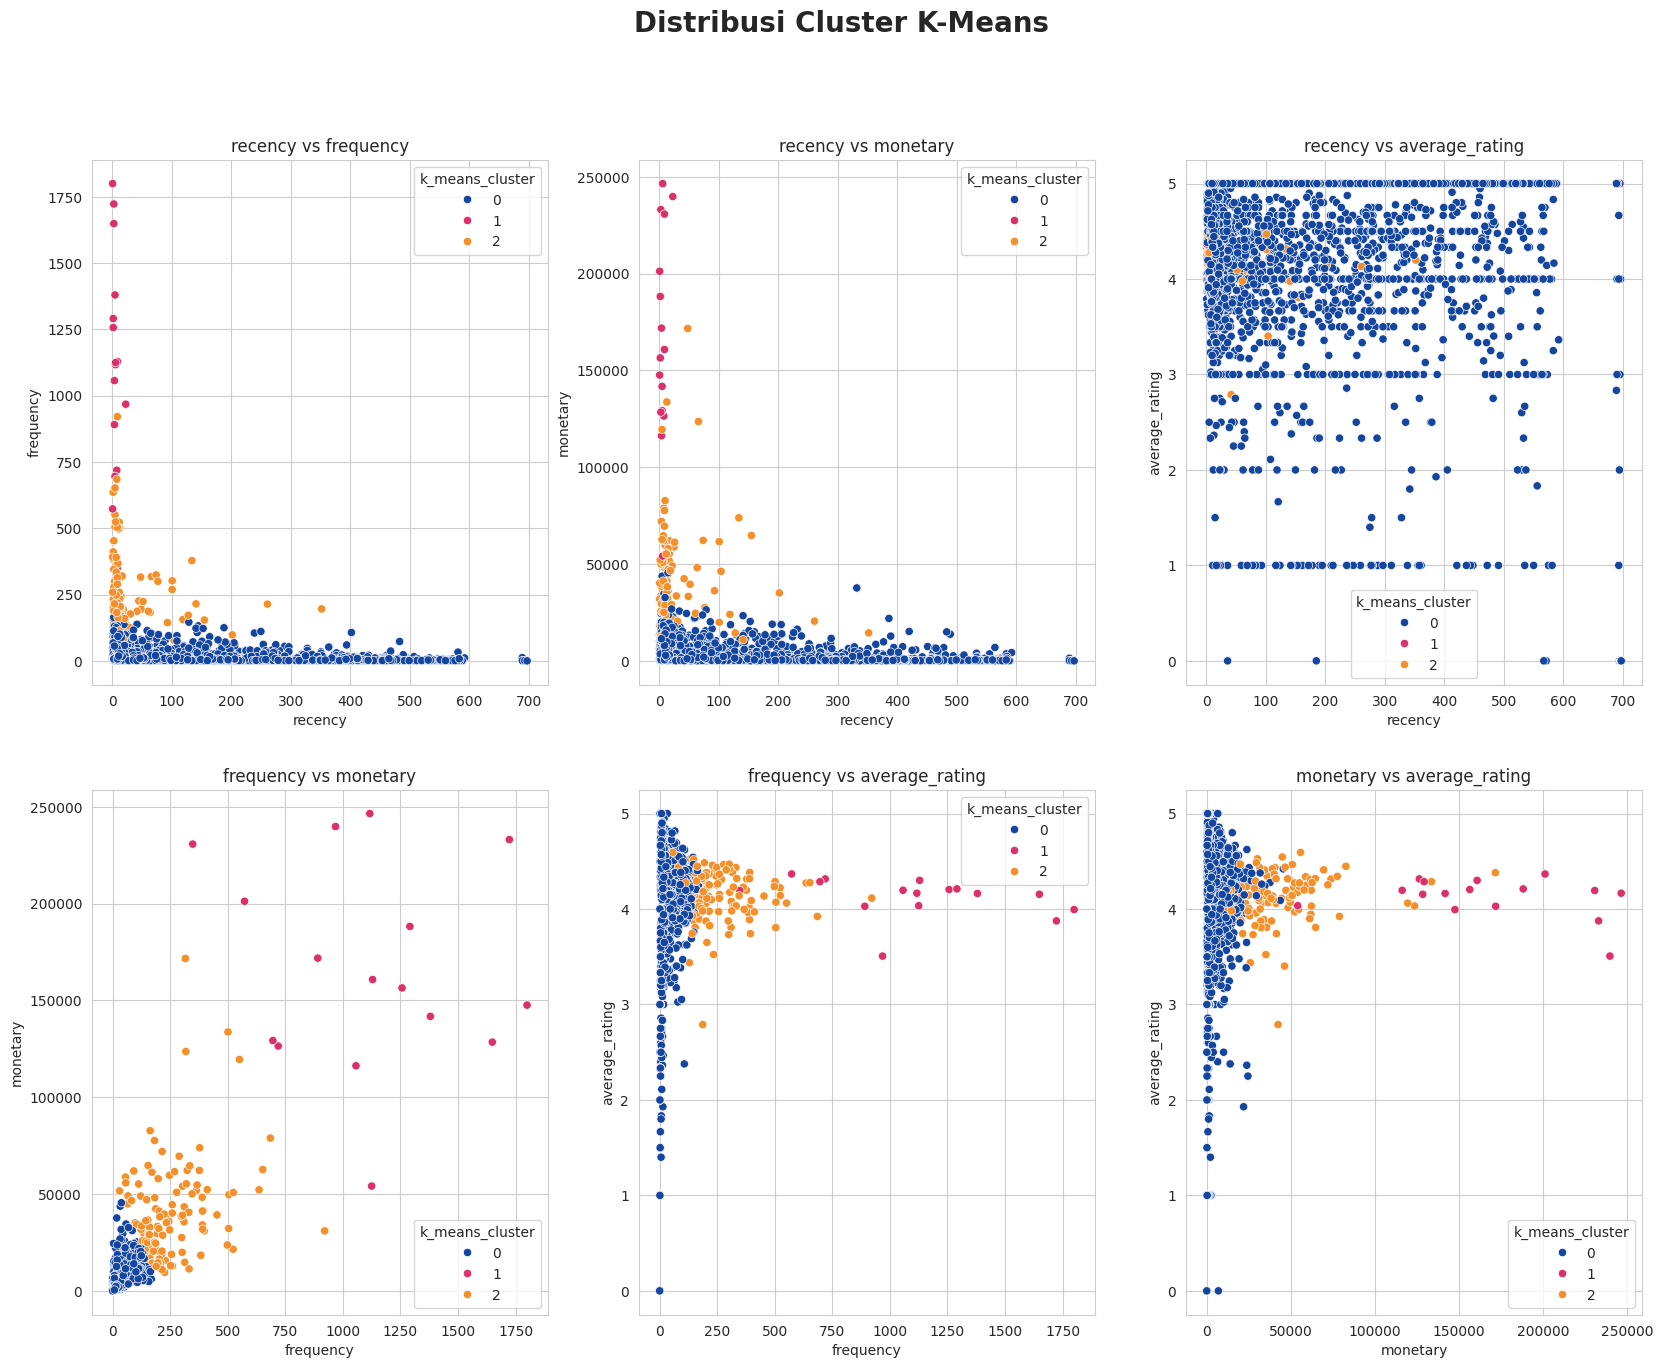

In [102]:
plot(df_seller_grouped, hue = "k_means_cluster")
plt.suptitle("Distribusi Cluster K-Means", fontsize = 20,
             weight = "bold")
plt.show()

Cluster 0 -> Casual Sellers

Cluster 1 -> Top Sellers

Cluster 2 -> Steady Sellers

Casual Sellers : 2815 * 60 = R\$ 168,900

Steady Sellers : 125 * 130 = R\$ 16,250

Top Sellers : 16 * 250 = R\$ 4,000

Total Cost : R\$ 189,150

## Pemilihan Strategi

In [103]:
df_result

Analysis  Silhouette Score  Davies-Bouldin Index  Calinksi-Harabasz Index
0  Rule-based          0.162910              1.545813               644.776833
1      DBSCAN          0.573975              0.830584              1030.534316
2      KMeans          0.853399              0.535755              5040.082335

Methode KMeans menghasilkan cluster yang lebih bagus berdasarkan Silhouette score, DBI dan CHI, dan juga mengurasi cost yang akan dikeluarkan (BRL 189.150) dibandingkan dengan rule-based analysis (BRL 478.290). Sehingga kita akan menggunakan Hasil cluster KMeans.

## Tentang KMeans

KMeans adalah algoritma unsupervised learning untuk melakukan clustering data. Cara kerja Kmeans sebagai berikut:

**1. Tentukan jumlah cluster (K)**
- Misalnya kita ingin membagi data menjadi 3 kelompok (K=3).

**2. Inisialisasi centroid awal**
- K titik awal (centroid) dipilih secara acak dari data (dengan metode khusus seperti k-means++).

**3. Hitung jarak setiap data ke centroid**
- Menghitung jarak dapat menggunakan methode seperti Euclidean distance.
- Setiap data ditempatkan ke cluster dengan centroid terdekat.

**4. Update centroid**
- Setelah semua data ditempatkan, hitung rata-rata posisi semua titik dalam cluster untuk mendapatkan titik baru centroid.

**5. Ulangi langkah 3-4**
- Ulangi langkah 3-4 sampai centroid tidak berubah banyak atau sudah konvergen.

**6. Hasil akhir**
- Data terbagi ke dalam K cluster.
- Setiap cluster punya centroid sebagai representasi pusatnya.

 Adapun beberapa kelebihan dan kekurangan dari KMeans.

 **Kelebihan**
  - Algoritma sederhana, cepat, dan populer untuk segmentasi.
  - Hasil berupa centroid yang mudah diinterpretasi.

 **Kekurangan**
  - Harus menentukan jumlah cluster di awal.
  - Sensitif terhadap outlier.

### Decision Boundary

In [104]:
def plot_boundary_from_labels(X, labels, f1, f2):
    X_2d = X[[f1, f2]].values
    y = labels.values

    # fit classifier untuk mendekati cluster asli
    clf = DecisionTreeClassifier(max_depth = 4).fit(X_2d, y)

    # grid
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="viridis", s=30, label=y)

    plt.legend(*scatter.legend_elements(), loc="best", title="Cluster")
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"{f1} vs {f2}")

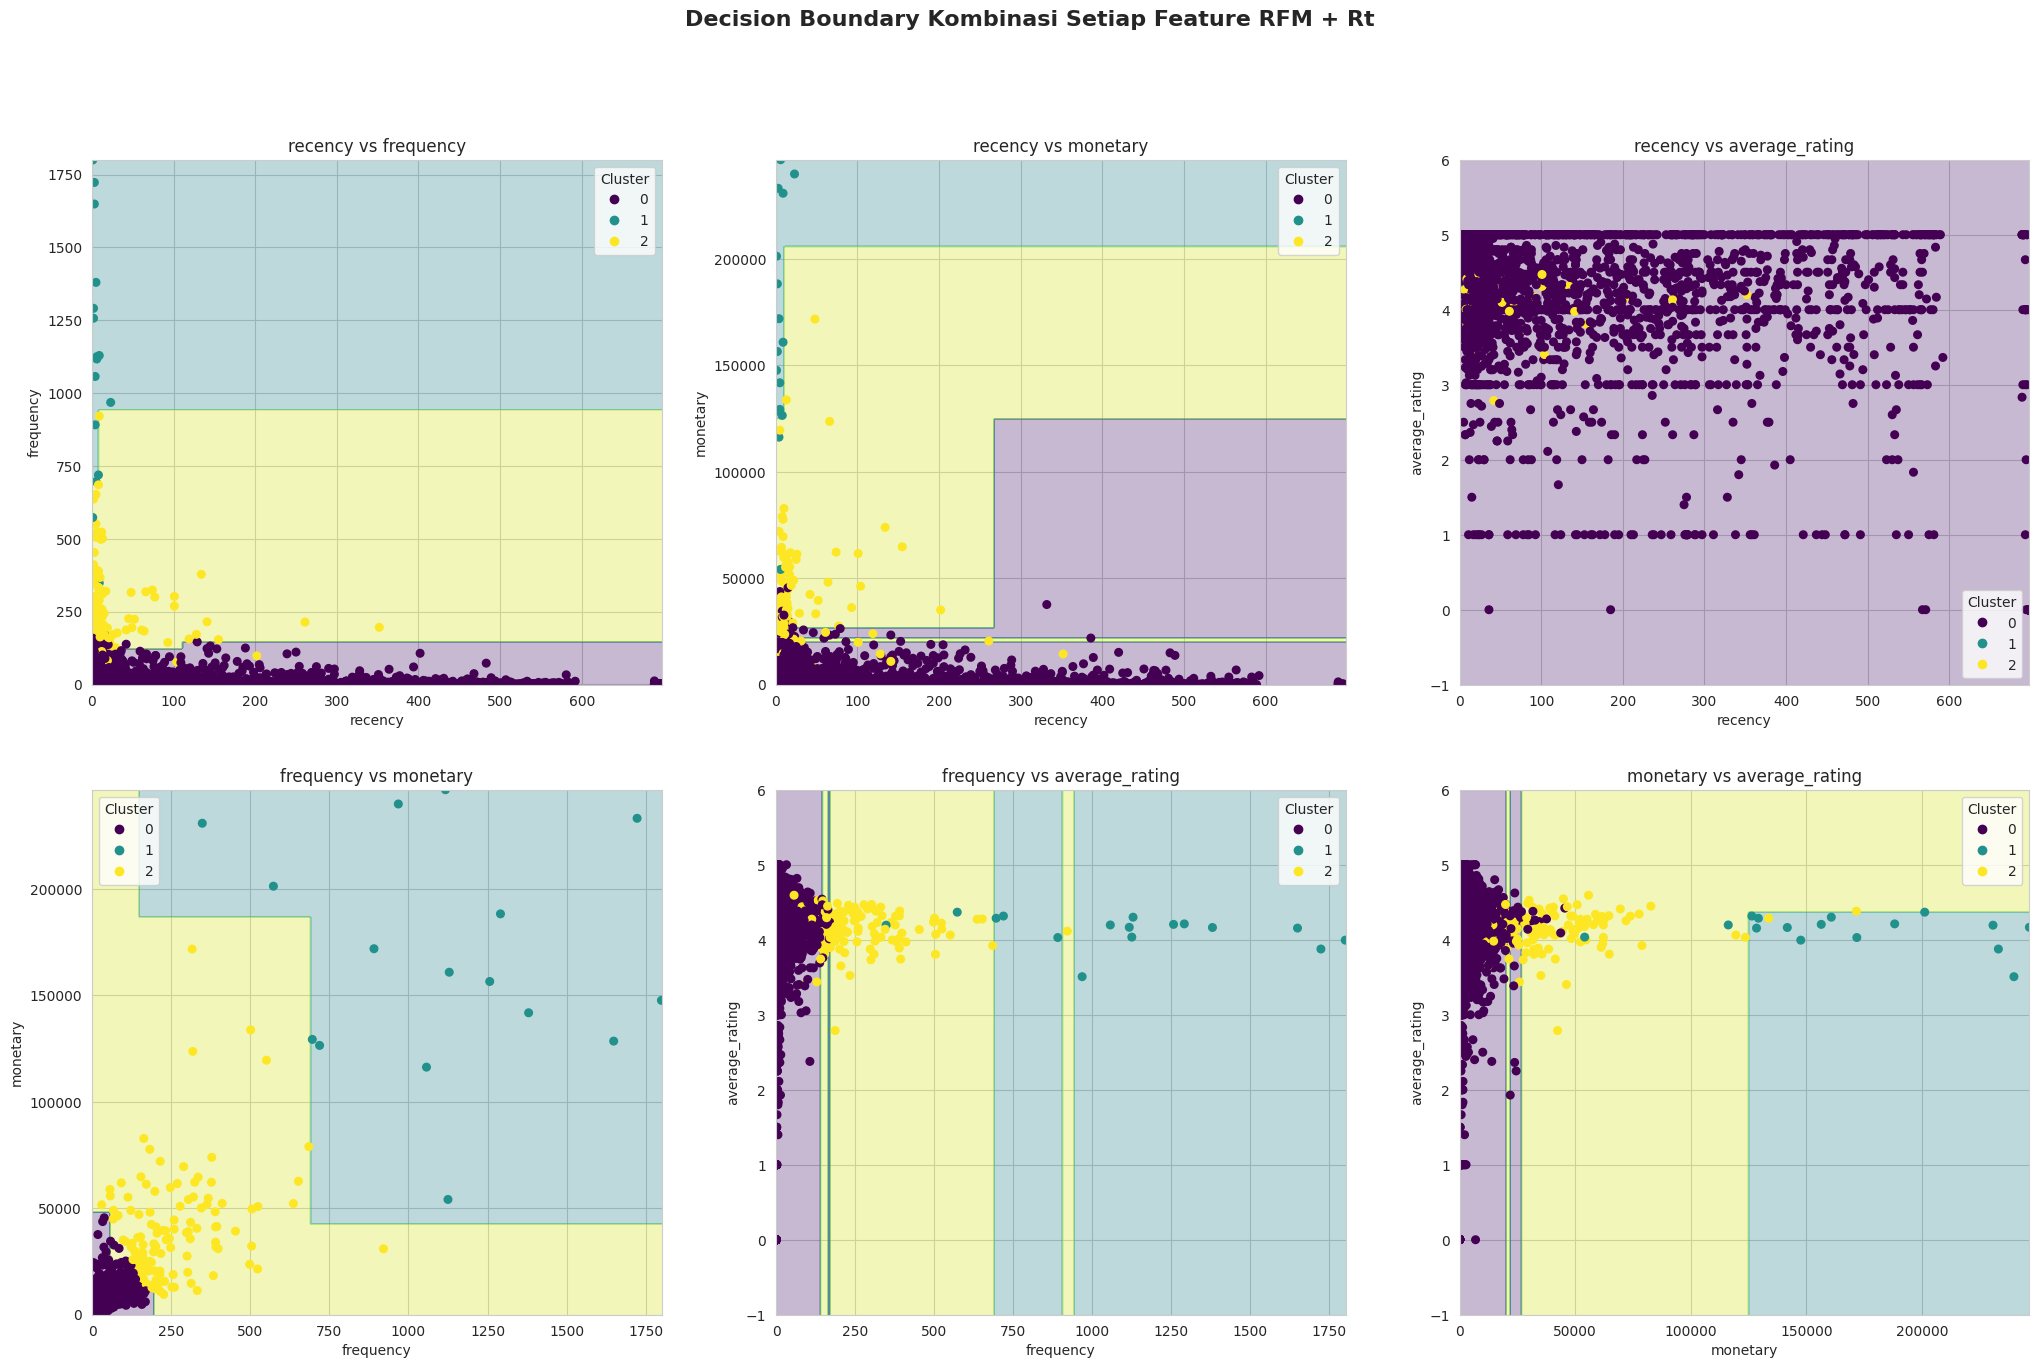

In [105]:
features = ["recency", "frequency", "monetary", "average_rating"]

plt.figure(figsize=(25, 15))
i = 0
for f1, f2 in combinations(features, 2):
  plt.subplot(2, 3, i+1)
  plot_boundary_from_labels(df_seller_grouped, df_seller_grouped["k_means_cluster"], f1, f2)
  i += 1

plt.suptitle("Decision Boundary Kombinasi Setiap Feature RFM + Rt", fontsize=16, weight="bold")
plt.show()

Insight:

- Terdapat tiga segmen seller:
  - Cluster 0 (Casual Sellers): frekuensi rendah, revenue rendah, rating bervariasi.
  - Cluster 1 (Steady Sellers): frekuensi, recency, revenue sedang, rating cukup baik.
  - Cluster 2 (Top Sellers): recency yang rendah (popular) dengan frekuensi dan monetary tinggi, rating cenderung baik.

- Rating (Rt) kurang berpengaruh dibandingkan RFM dalam memisahkan cluster sehingga pemisahan utama lebih banyak ditentukan oleh recency, frequency, dan monetary.

- Seller dalam cluster Top Sellers terlihat jelas pada kombinasi frequency-monetary. Hal ini menunjukkan loyalitas tinggi dan sangat menguntungkan bagi bisnis.

In [106]:
# mengganti nama hasil cluster
def rename_cluster(x):
    if x == 0:
        return "Casual Sellers"
    elif x == 1:
        return "Top Sellers"
    else:
        return "Steady Sellers"

df_seller_grouped['cluster_name'] = df_seller_grouped['k_means_cluster'].apply(rename_cluster)
df_seller_grouped.head()

seller_id  recency  frequency  monetary  \
0  0015a82c2db000af6aaaf3ae2ecb0532    316.0          3   2748.06   
1  001cca7ae9ae17fb1caed9dfb1094831     49.0        195  33307.42   
2  001e6ad469a905060d959994f1b41e4f    697.0          0      0.00   
3  002100f778ceb8431b7a1020ff7ab48f    140.0         49   1984.75   
4  003554e2dce176b5555353e4f3555ac8    258.0          1    139.38   

   average_rating  total_price  total_freight  cluster  k_means_cluster  \
0        3.666667      2685.00          63.06        0                0   
1        4.062500     24616.93        8690.49       -1                2   
2        0.000000         0.00           0.00        1                0   
3        4.020000      1210.50         774.25        0                0   
4        5.000000       120.00          19.38        0                0   

     cluster_name  
0  Casual Sellers  
1  Steady Sellers  
2  Casual Sellers  
3  Casual Sellers  
4  Casual Sellers

## Analysis

### EDA After RFM Analysis

In [107]:
order_cluster = ["Casual Sellers","Steady Sellers", "Top Sellers"]

In [108]:
# --- 2. Merge dengan hasil segmentasi (df_seller_grouped) ---
df_merged = pd.merge(
    dfnew,
    df_seller_grouped,
    on="seller_id",
    how="right"  # hanya seller yang muncul di kedua dataset
)

# --- 3. Cek hasil ---
df_merged.head()

order_id                       customer_id  \
0  9dc8d1a6f16f1b89874c29c9d8d30447  d9442164acf4b03109425633efaa0cfc   
1  d455a8cb295653b55abda06d434ab492  944b72539d7e1f7f7fc6e46639ef1fe3   
2  7f39ba4c9052be115350065d07583cac  d7fc82cbeafea77bd0a8fbbf6296e387   
3  e6ce16cb79ec1d90b1da9085a6118aeb  494dded5b201313c64ed7f100595b95c   
4  6ebaec694d7025e2ad4a05dba887c032  4f28355e5c17a4a42d3ce2439a1d4501   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered               2017-10-12        2017-10-12   
1    delivered               2017-09-26        2017-09-27   
2    delivered               2017-10-18        2017-10-18   
3    delivered               2017-05-16        2017-05-16   
4    delivered               2017-05-18        2017-05-18   

  order_delivered_carrier_date order_delivered_customer_date  \
0                   2017-10-17                    2017-10-24   
1                   2017-09-29                    2017-10-07   
2                   2017-10-20                    2017-10-27   
3                   2017-05-18                    2017-05-29   
4                   2017-05-19                    2017-05-29   

  order_estimated_delivery_date  order_item_id  \
0                    2017-11-06            1.0   
1                    2017-10-30            1.0   
2                    2017-11-09            1.0   
3                    2017-06-07            2.0   
4                    2017-06-09            1.0   

                         product_id  ... order_month recency  frequency  \
0  a2ff5a97bf95719e38ea2e3b4105bce8  ...     2017-10   316.0          3   
1  a2ff5a97bf95719e38ea2e3b4105bce8  ...     2017-09   316.0          3   
2  a2ff5a97bf95719e38ea2e3b4105bce8  ...     2017-10   316.0          3   
3  08574b074924071f4e201e151b152b4e  ...     2017-05    49.0        195   
4  e251ebd2858be1aa7d9b2087a6992580  ...     2017-05    49.0        195   

   monetary average_rating  total_price_y total_freight_y cluster  \
0   2748.06       3.666667        2685.00           63.06       0   
1   2748.06       3.666667        2685.00           63.06       0   
2   2748.06       3.666667        2685.00           63.06       0   
3  33307.42       4.062500       24616.93         8690.49      -1   
4  33307.42       4.062500       24616.93         8690.49      -1   

   k_means_cluster    cluster_name  
0                0  Casual Sellers  
1                0  Casual Sellers  
2                0  Casual Sellers  
3                2  Steady Sellers  
4                2  Steady Sellers  

[5 rows x 31 columns]

In [109]:
# --- Jumlah seller unik per cluster ---
seller_count = df_seller_grouped['cluster_name'].value_counts()

# --- Jumlah transaksi (order items) per cluster ---
order_count = df_merged.groupby('cluster_name')['order_id'].nunique()

# --- Jumlah item terjual per cluster ---
item_count = df_merged.groupby('cluster_name')['order_item_id'].count()

# --- Total revenue (price + freight) per cluster ---
revenue_per_cluster = df_merged.groupby('cluster_name').agg({
    'price': 'sum',
    'freight_value': 'sum'
})
revenue_per_cluster['total_revenue'] = revenue_per_cluster['price'] + revenue_per_cluster['freight_value']

# --- Gabungkan semua hasil jadi satu tabel ringkasan ---
cluster_summary = pd.DataFrame({
    "seller_count": seller_count,
    "order_count": order_count,
    "item_count": item_count
}).join(revenue_per_cluster)

print(cluster_summary)

                seller_count  order_count  item_count       price  \
cluster_name                                                        
Casual Sellers          2952        46922       47123  6144119.34   
Steady Sellers           127        31833       32054  3952560.18   
Top Sellers               16        17723       17830  2031753.98   

                freight_value  total_revenue  
cluster_name                                  
Casual Sellers      983507.58     7127626.92  
Steady Sellers      620076.86     4572637.04  
Top Sellers         348930.34     2380684.32  


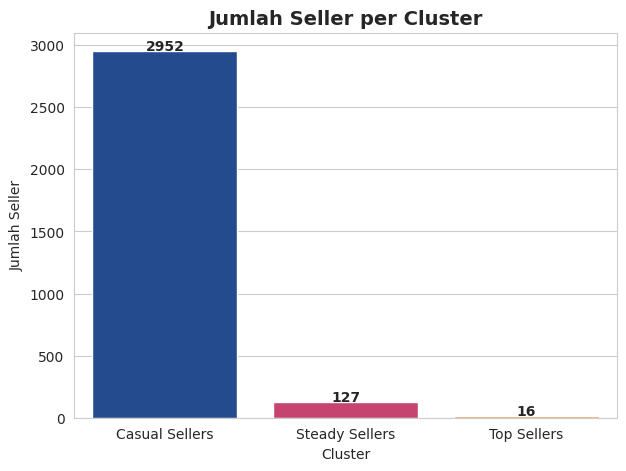

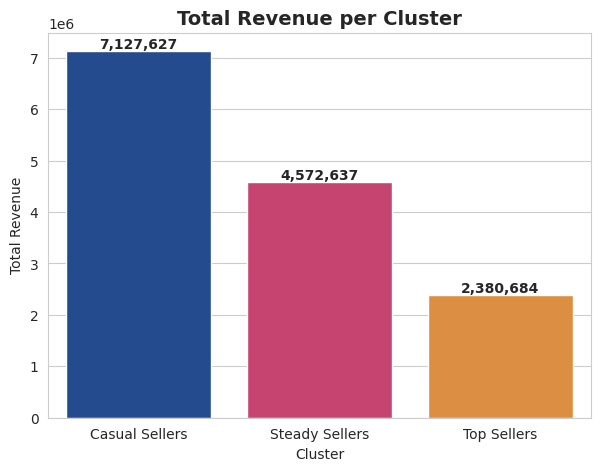

In [110]:
# --- 1. Distribusi Seller per Cluster ---
plt.figure(figsize=(7,5))
ax = sb.barplot(x=seller_count.index, y=seller_count.values, palette=COLORS,
                order=order_cluster)
plt.title("Jumlah Seller per Cluster", fontsize=14, fontweight="bold")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Seller")

for i, v in enumerate(seller_count.values):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.show()

# --- 2. Distribusi Revenue per Cluster ---
plt.figure(figsize=(7,5))
ax = sb.barplot(
    x=revenue_per_cluster.index,
    y=revenue_per_cluster["total_revenue"],
    palette=COLORS,
    order=order_cluster
)
plt.title("Total Revenue per Cluster", fontsize=14, fontweight="bold")
plt.xlabel("Cluster")
plt.ylabel("Total Revenue")

revenue_per_cluster = revenue_per_cluster.sort_values(by="total_revenue", ascending=False)
for i, v in enumerate(revenue_per_cluster["total_revenue"]):
    plt.text(i, v, f"{v:,.0f}", ha='center', va='bottom', fontweight='bold')

plt.show()

### Jumlah Seller per Cluster
- Casual Sellers seller mendominasi dengan jumlah seller yang sangat besar (2.952 seller).
- Steady Sellers seller hanya memiliki 127 seller, sedangkan Top Sellers seller paling sedikit dengan 16 seller.
- Distribusi seller sangat timpang, mayoritas seller terkonsentrasi di Casual Sellers seller.

### Total Revenue per Cluster
- Casual Sellers seller menyumbang revenue terbesar (±7 juta).
- Steady Sellers seller, meski jumlah sellernya jauh lebih sedikit, mampu menghasilkan revenue yang cukup tinggi (±4,5 juta).
- Top Sellers seller dengan seller paling sedikit (16 seller) masih bisa menghasilkan revenue signifikan (±2,4 juta).

### Insight Utama
- Casual Sellers seller memiliki jumlah seller terbanyak, namun kontribusi revenue per seller relatif rendah.
- Medium and Top Sellers seller walaupun jumlah sellernya kecil, justru memberikan kontribusi revenue per seller yang jauh lebih tinggi. Hal ini menunjukkan adanya seller dengan performa unggul di seller ini.
- Perlu adanya treatment retensi yang diberlakukan kepada Medium dan Top Sellers seller dan pelatihan untuk meningkatkan revenue Casual Sellers seller.

In [111]:
# Statistik dasar per cluster
cluster_stats = df_merged.groupby("cluster_name").agg({
    "recency": ["mean", "median"],
    "frequency": ["mean", "median"],
    "monetary": ["mean", "median"],
    "average_rating": ["mean", "median"],
    "price": ["mean", "median"],
    "freight_value": ["mean", "median"]
}).round(2)

print(cluster_stats)

               recency        frequency           monetary             \
                  mean median      mean  median       mean     median   
cluster_name                                                            
Casual Sellers   67.77   18.0     56.87    48.0    7574.27    6105.65   
Steady Sellers   23.42    9.0    330.19   302.0   42885.82   36585.86   
Top Sellers       5.10    4.0   1251.79  1257.0  164606.38  156485.60   

               average_rating          price        freight_value         
                         mean median    mean median          mean median  
cluster_name                                                              
Casual Sellers           4.18   4.23  130.38  78.75         20.87  16.67  
Steady Sellers           4.14   4.14  123.31  75.00         19.34  16.11  
Top Sellers              4.10   4.16  113.95  79.99         19.57  16.32  


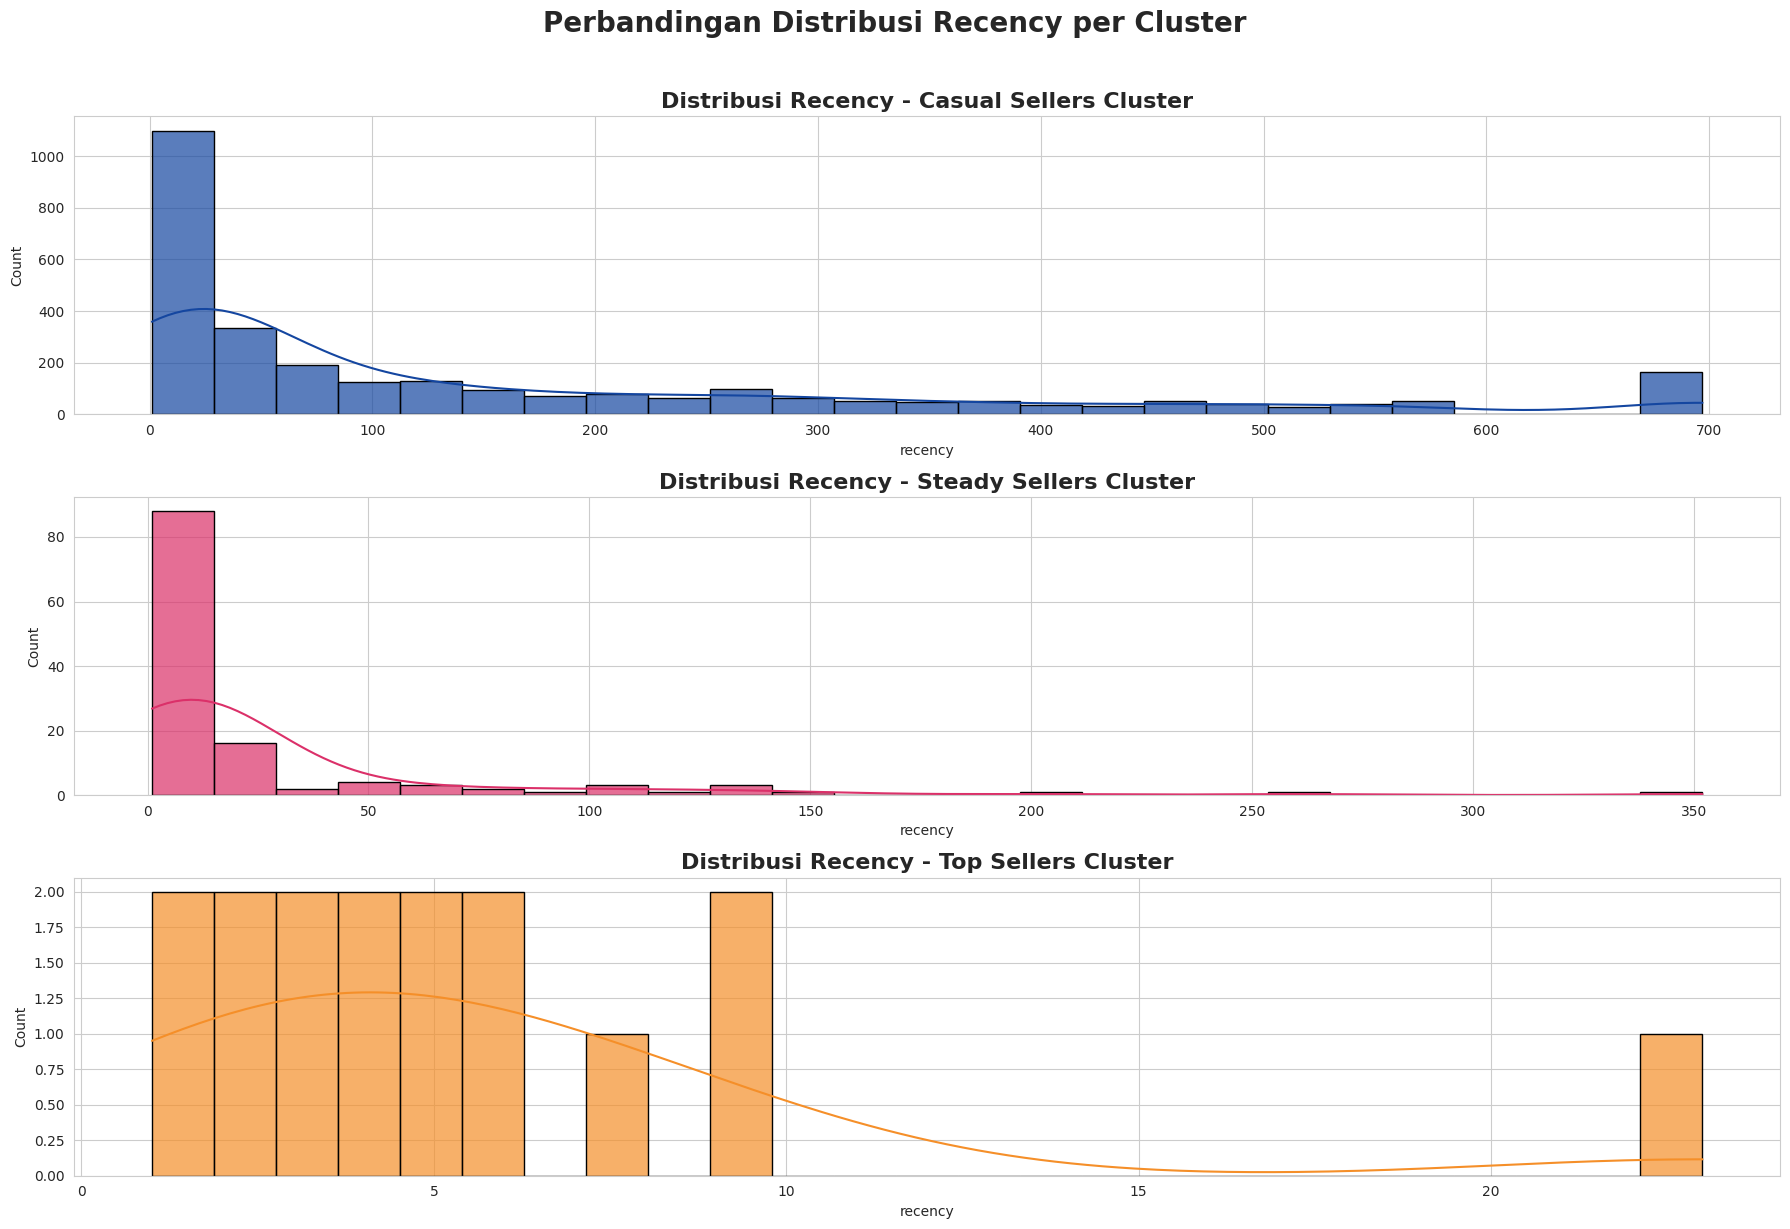

In [112]:
cluster_0 = df_seller_grouped[df_seller_grouped["k_means_cluster"] == 0]
cluster_1 = df_seller_grouped[df_seller_grouped["k_means_cluster"] == 1]
cluster_2 = df_seller_grouped[df_seller_grouped["k_means_cluster"] == 2]

plt.figure(figsize=(18, 12))

# Cluster 0
ax1 = plt.subplot(3, 1, 1)
sb.histplot(data=cluster_0, x="recency", bins=25, kde=True,
            color=COLORS[0], edgecolor="black", alpha=0.7)
ax1.set_title("Distribusi Recency - Casual Sellers Cluster", fontsize=16, weight="bold")

# Cluster 2
ax2 = plt.subplot(3, 1, 2)
sb.histplot(data=cluster_2, x="recency", bins=25, kde=True,
            color=COLORS[1], edgecolor="black", alpha=0.7)
ax2.set_title("Distribusi Recency - Steady Sellers Cluster", fontsize=16, weight="bold")

# Cluster 1
ax3 = plt.subplot(3, 1, 3)
sb.histplot(data=cluster_1, x="recency", bins=25, kde=True,
            color=COLORS[2], edgecolor="black", alpha=0.7)
ax3.set_title("Distribusi Recency - Top Sellers Cluster", fontsize=16, weight="bold")

plt.suptitle("Perbandingan Distribusi Recency per Cluster", fontsize=20, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

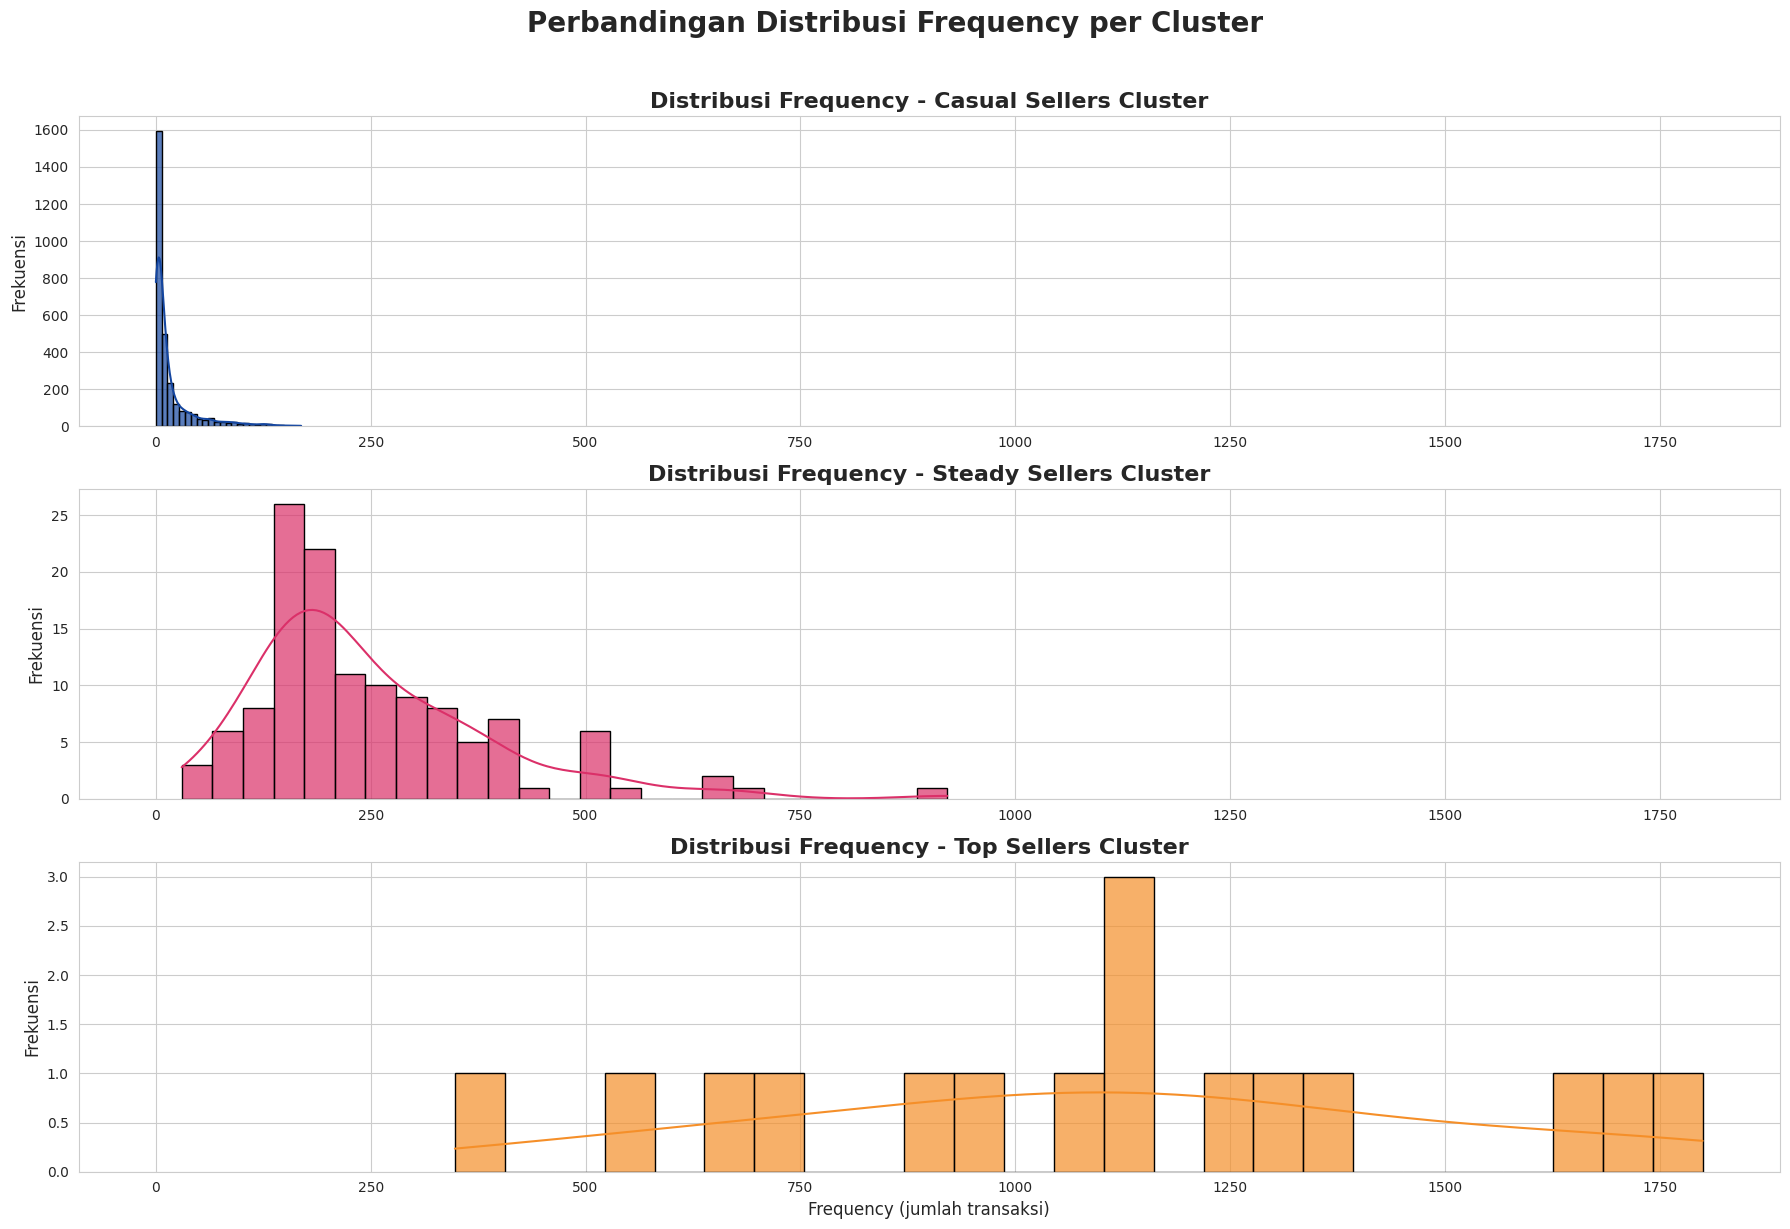

In [113]:
plt.figure(figsize=(18, 12))

# Cluster 0
ax1 = plt.subplot(3, 1, 1)
sb.histplot(data=cluster_0, x="frequency", bins=25, kde=True,
            color=COLORS[0], edgecolor="black", alpha=0.7)
ax1.set_title("Distribusi Frequency - Casual Sellers Cluster", fontsize=16, weight="bold")
ax1.set_ylabel("Frekuensi", fontsize=12)
ax1.set_xlabel("")

# Cluster 1
ax2 = plt.subplot(3, 1, 2, sharex = ax1)
sb.histplot(data=cluster_2, x="frequency", bins=25, kde=True,
            color=COLORS[1], edgecolor="black", alpha=0.7)
ax2.set_title("Distribusi Frequency - Steady Sellers Cluster", fontsize=16, weight="bold")
ax2.set_ylabel("Frekuensi", fontsize=12)
ax2.set_xlabel("")

# Cluster 2
ax3 = plt.subplot(3, 1, 3, sharex = ax1)
sb.histplot(data=cluster_1, x="frequency", bins=25, kde=True,
            color=COLORS[2], edgecolor="black", alpha=0.7)
ax3.set_title("Distribusi Frequency - Top Sellers Cluster", fontsize=16, weight="bold")
ax3.set_ylabel("Frekuensi", fontsize=12)
ax3.set_xlabel("Frequency (jumlah transaksi)", fontsize=12)

# Judul besar
plt.suptitle("Perbandingan Distribusi Frequency per Cluster", fontsize=20, weight="bold", y=1.02)

plt.tight_layout()
plt.show()

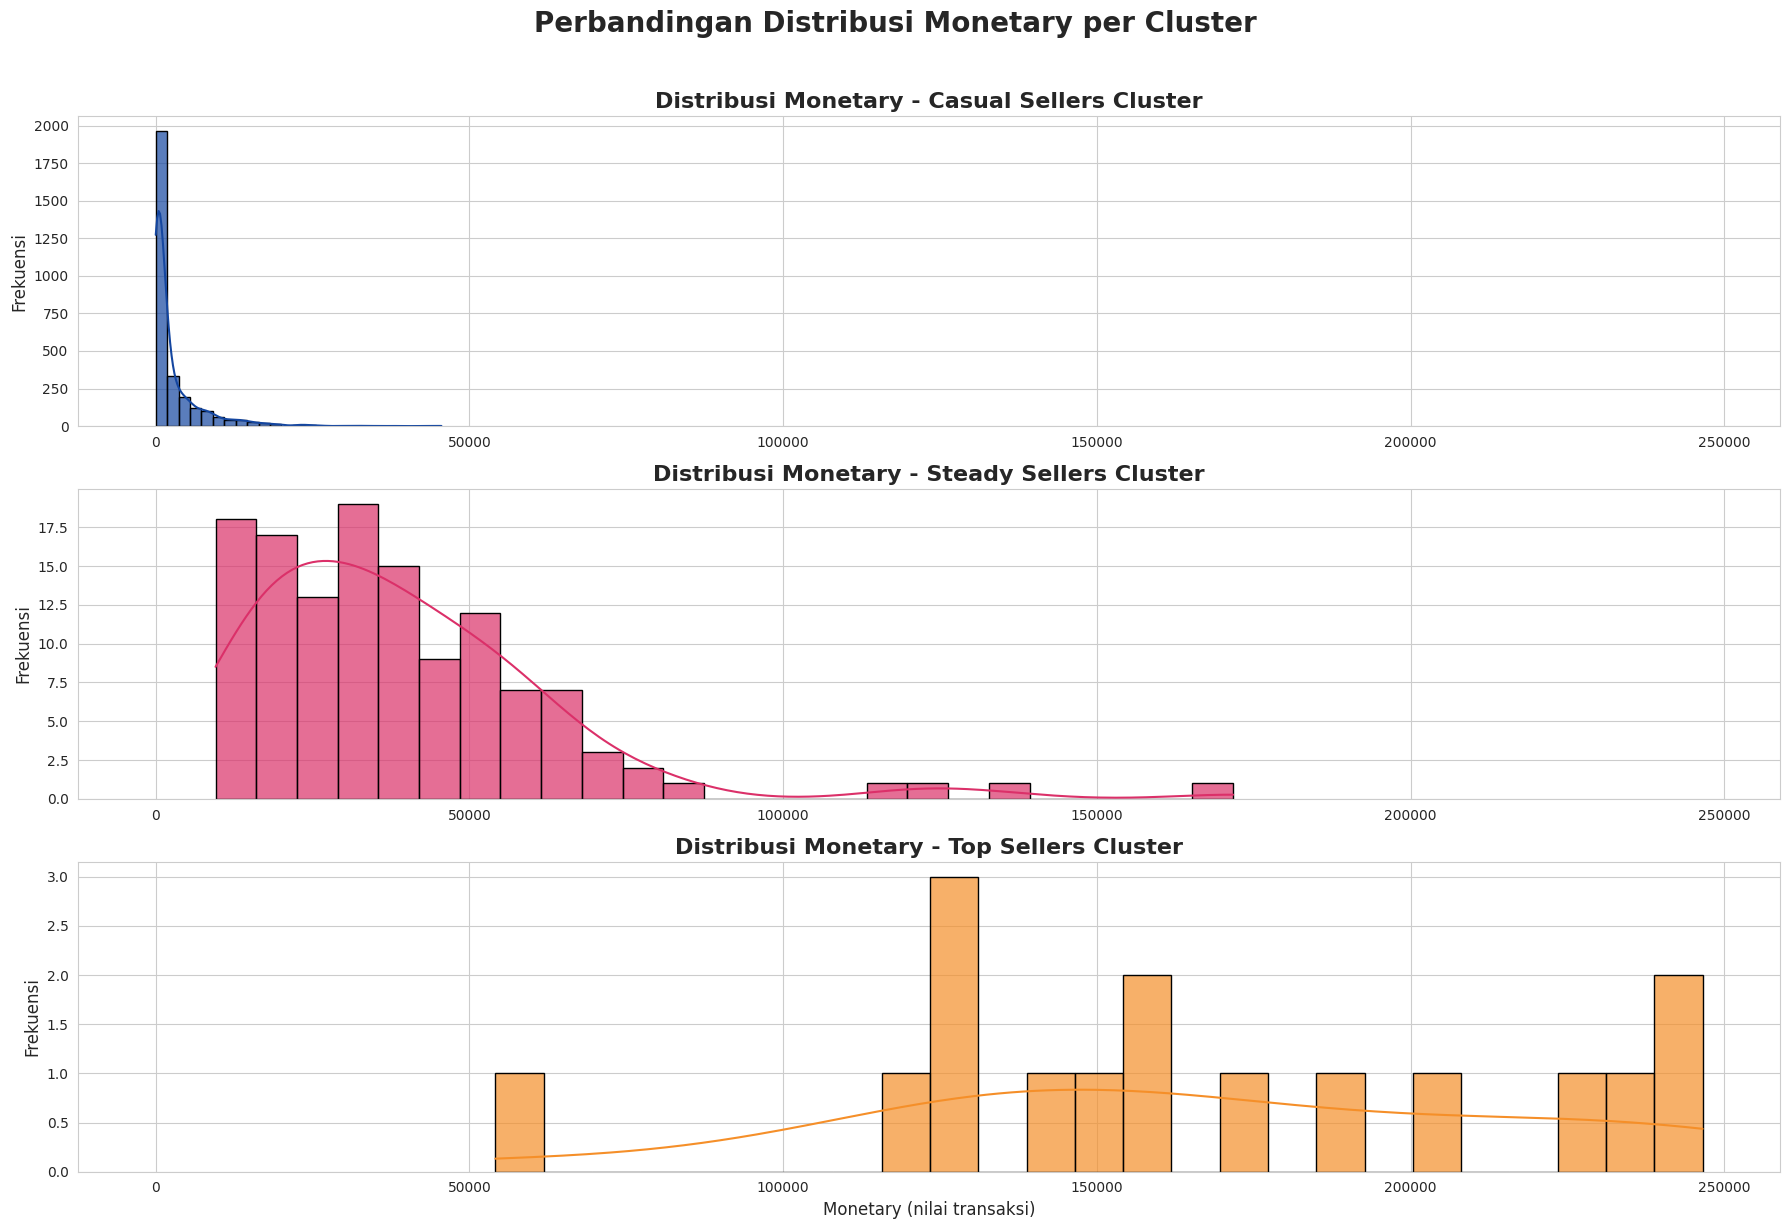

In [114]:
plt.figure(figsize=(18, 12))

# Cluster 0
ax1 = plt.subplot(3, 1, 1)
sb.histplot(data=cluster_0, x="monetary", bins=25, kde=True,
            color=COLORS[0], edgecolor="black", alpha=0.7)
ax1.set_title("Distribusi Monetary - Casual Sellers Cluster", fontsize=16, weight="bold")
ax1.set_ylabel("Frekuensi", fontsize=12)
ax1.set_xlabel("")

# Cluster 1
ax2 = plt.subplot(3, 1, 2, sharex = ax1)
sb.histplot(data=cluster_2, x="monetary", bins=25, kde=True,
            color=COLORS[1], edgecolor="black", alpha=0.7)
ax2.set_title("Distribusi Monetary - Steady Sellers Cluster", fontsize=16, weight="bold")
ax2.set_ylabel("Frekuensi", fontsize=12)
ax2.set_xlabel("")

# Cluster 2
ax3 = plt.subplot(3, 1, 3, sharex = ax1)
sb.histplot(data=cluster_1, x="monetary", bins=25, kde=True,
            color=COLORS[2], edgecolor="black", alpha=0.7)
ax3.set_title("Distribusi Monetary - Top Sellers Cluster", fontsize=16, weight="bold")
ax3.set_ylabel("Frekuensi", fontsize=12)
ax3.set_xlabel("Monetary (nilai transaksi)", fontsize=12)

plt.suptitle("Perbandingan Distribusi Monetary per Cluster", fontsize=20, weight="bold", y=1.02)

plt.tight_layout()
plt.show()

In [115]:
rating_summary = df_seller_grouped.groupby('cluster_name')['average_rating'].agg(['mean','count'])
print(rating_summary)

                    mean  count
cluster_name                   
Casual Sellers  4.002520   2952
Steady Sellers  4.139947    127
Top Sellers     4.125128     16


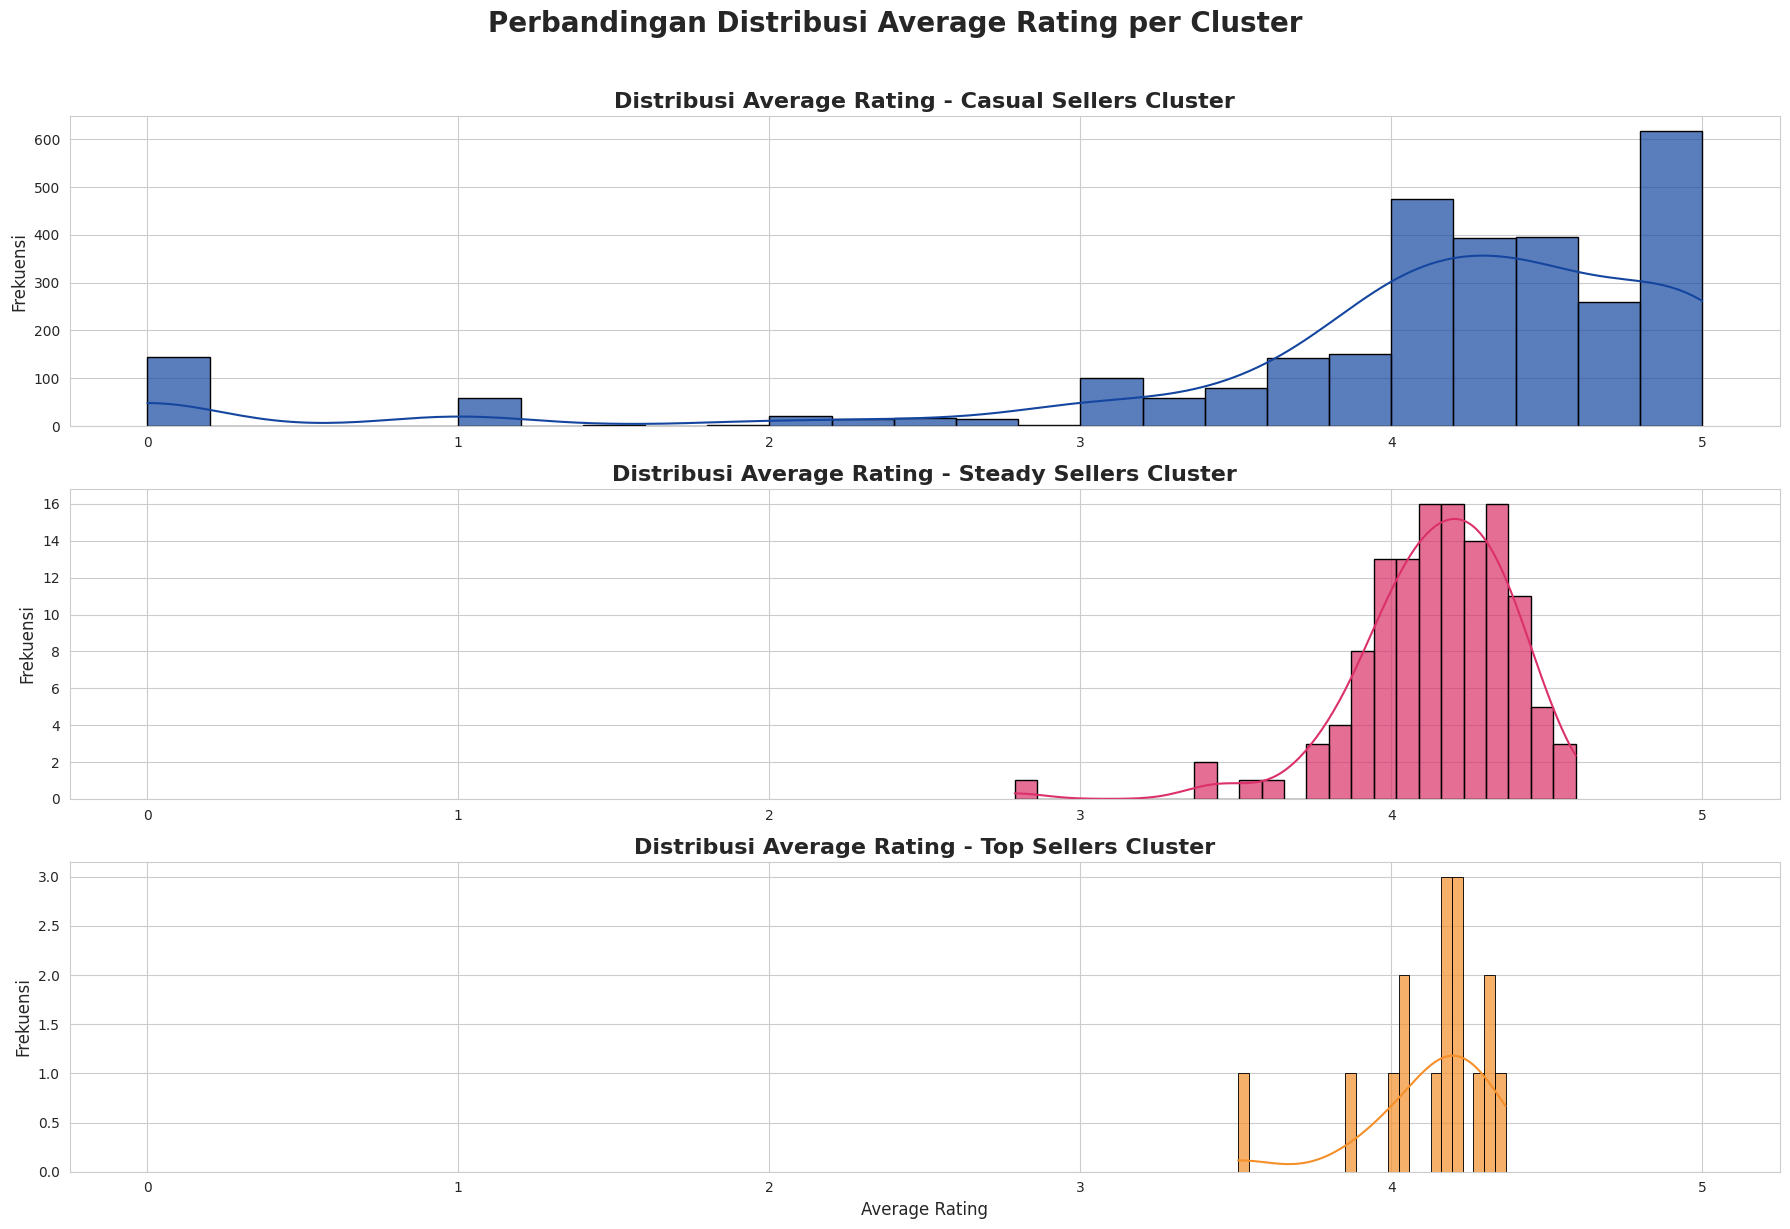

In [116]:
plt.figure(figsize=(18, 12))

# Cluster 0
ax1 = plt.subplot(3, 1, 1)
sb.histplot(data=cluster_0, x="average_rating", bins=25, kde=True,
            color=COLORS[0], edgecolor="black", alpha=0.7)
ax1.set_title("Distribusi Average Rating - Casual Sellers Cluster", fontsize=16, weight="bold")
ax1.set_ylabel("Frekuensi", fontsize=12)
ax1.set_xlabel("")

# Cluster 1
ax2 = plt.subplot(3, 1, 2, sharex = ax1)
sb.histplot(data=cluster_2, x="average_rating", bins=25, kde=True,
            color=COLORS[1], edgecolor="black", alpha=0.7)
ax2.set_title("Distribusi Average Rating - Steady Sellers Cluster", fontsize=16, weight="bold")
ax2.set_ylabel("Frekuensi", fontsize=12)
ax2.set_xlabel("")

# Cluster 2
ax3 = plt.subplot(3, 1, 3, sharex = ax1)
sb.histplot(data=cluster_1, x="average_rating", bins=25, kde=True,
            color=COLORS[2], edgecolor="black", alpha=0.7)
ax3.set_title("Distribusi Average Rating - Top Sellers Cluster", fontsize=16, weight="bold")
ax3.set_ylabel("Frekuensi", fontsize=12)
ax3.set_xlabel("Average Rating", fontsize=12)

# judul utama
plt.suptitle("Perbandingan Distribusi Average Rating per Cluster", fontsize=20, weight="bold", y=1.02)

plt.tight_layout()
plt.show()


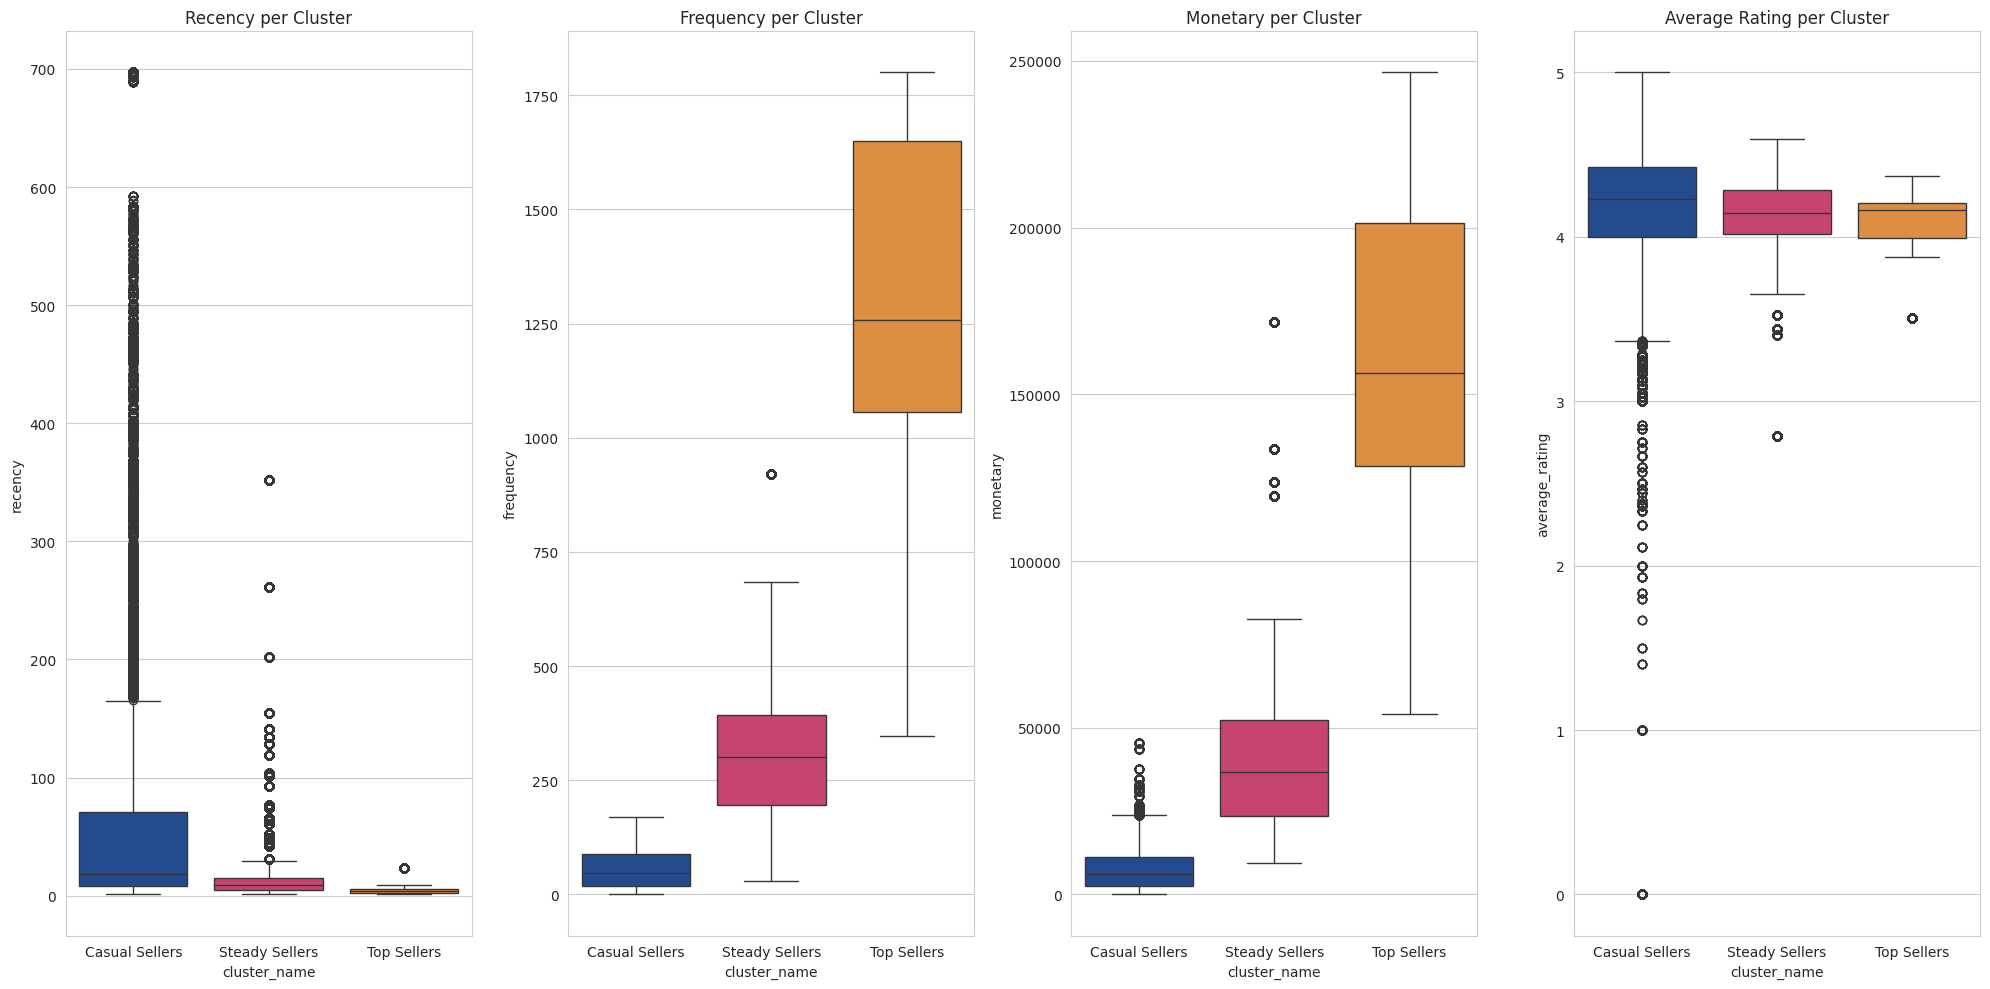

In [117]:
# --- Boxplot Recency, Frequency, Monetary ---
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

sb.boxplot(data=df_merged, x="cluster_name", y="recency", palette=COLORS, ax=axes[0])
axes[0].set_title("Recency per Cluster")

sb.boxplot(data=df_merged, x="cluster_name", y="frequency", palette=COLORS, ax=axes[1])
axes[1].set_title("Frequency per Cluster")

sb.boxplot(data=df_merged, x="cluster_name", y="monetary", palette=COLORS, ax=axes[2])
axes[2].set_title("Monetary per Cluster")

sb.boxplot(data=df_merged, x="cluster_name", y="average_rating", palette=COLORS, ax=axes[3])
axes[3].set_title("Average Rating per Cluster")
plt.tight_layout()
plt.show()


### Casual Sellers Cluster
- Recency tinggi (jarang bertransaksi, banyak yang sudah lama tidak menjual).
- Frequency dan Monetary sangat rendah.
- Rata-rata rating cukup tinggi, namun beberapa seller memiliki rating yang rendah.
- Ini adalah seller yang berisiko churn.

### Steady Sellers Cluster
- Recency relatif rendah (lebih sering bertransaksi dibanding Casual Sellers cluster).
- Frequency dan Monetary sedang.
- Rata-rata rating yang tinggi.
- Masih potensial untuk ditingkatkan performanya.

### Top Sellers Cluster
- Recency sangat rendah (sering melakukan transaksi, masih aktif).
- Frequency dan Monetary tertinggi.
- Rata-rata rating yang tinggi.
- Ini adalah seller utama (VIP/Top Sellers seller).

### Insight utama:
- Top Sellers Cluster adalah segmen seller paling bernilai yang harus dijaga loyalitasnya, sementara Casual Sellers Cluster membutuhkan strategi retensi (misalnya promo atau reaktivasi).

## Location

In [118]:
seller_location = pd.merge(df_seller_grouped, sellers, on = "seller_id", how = "left")
cluster_0 = seller_location[seller_location["k_means_cluster"] == 0]
cluster_1 = seller_location[seller_location["k_means_cluster"] == 1]
cluster_2 = seller_location[seller_location["k_means_cluster"] == 2]

In [119]:
seller_location.head()

seller_id  recency  frequency  monetary  \
0  0015a82c2db000af6aaaf3ae2ecb0532    316.0          3   2748.06   
1  001cca7ae9ae17fb1caed9dfb1094831     49.0        195  33307.42   
2  001e6ad469a905060d959994f1b41e4f    697.0          0      0.00   
3  002100f778ceb8431b7a1020ff7ab48f    140.0         49   1984.75   
4  003554e2dce176b5555353e4f3555ac8    258.0          1    139.38   

   average_rating  total_price  total_freight  cluster  k_means_cluster  \
0        3.666667      2685.00          63.06        0                0   
1        4.062500     24616.93        8690.49       -1                2   
2        0.000000         0.00           0.00        1                0   
3        4.020000      1210.50         774.25        0                0   
4        5.000000       120.00          19.38        0                0   

     cluster_name  seller_zip_code_prefix  seller_city seller_state  
0  Casual Sellers                    9080  santo andre           SP  
1  Steady Sellers                   29156    cariacica           ES  
2  Casual Sellers                   24754  sao goncalo           RJ  
3  Casual Sellers                   14405       franca           SP  
4  Casual Sellers                   74565      goiania           GO

In [120]:
loop_list = [cluster_0, cluster_2, cluster_1]
loop_name = ["Casual Sellers Cluster", "Steady Sellers Cluster", "Top Sellers Cluster"]

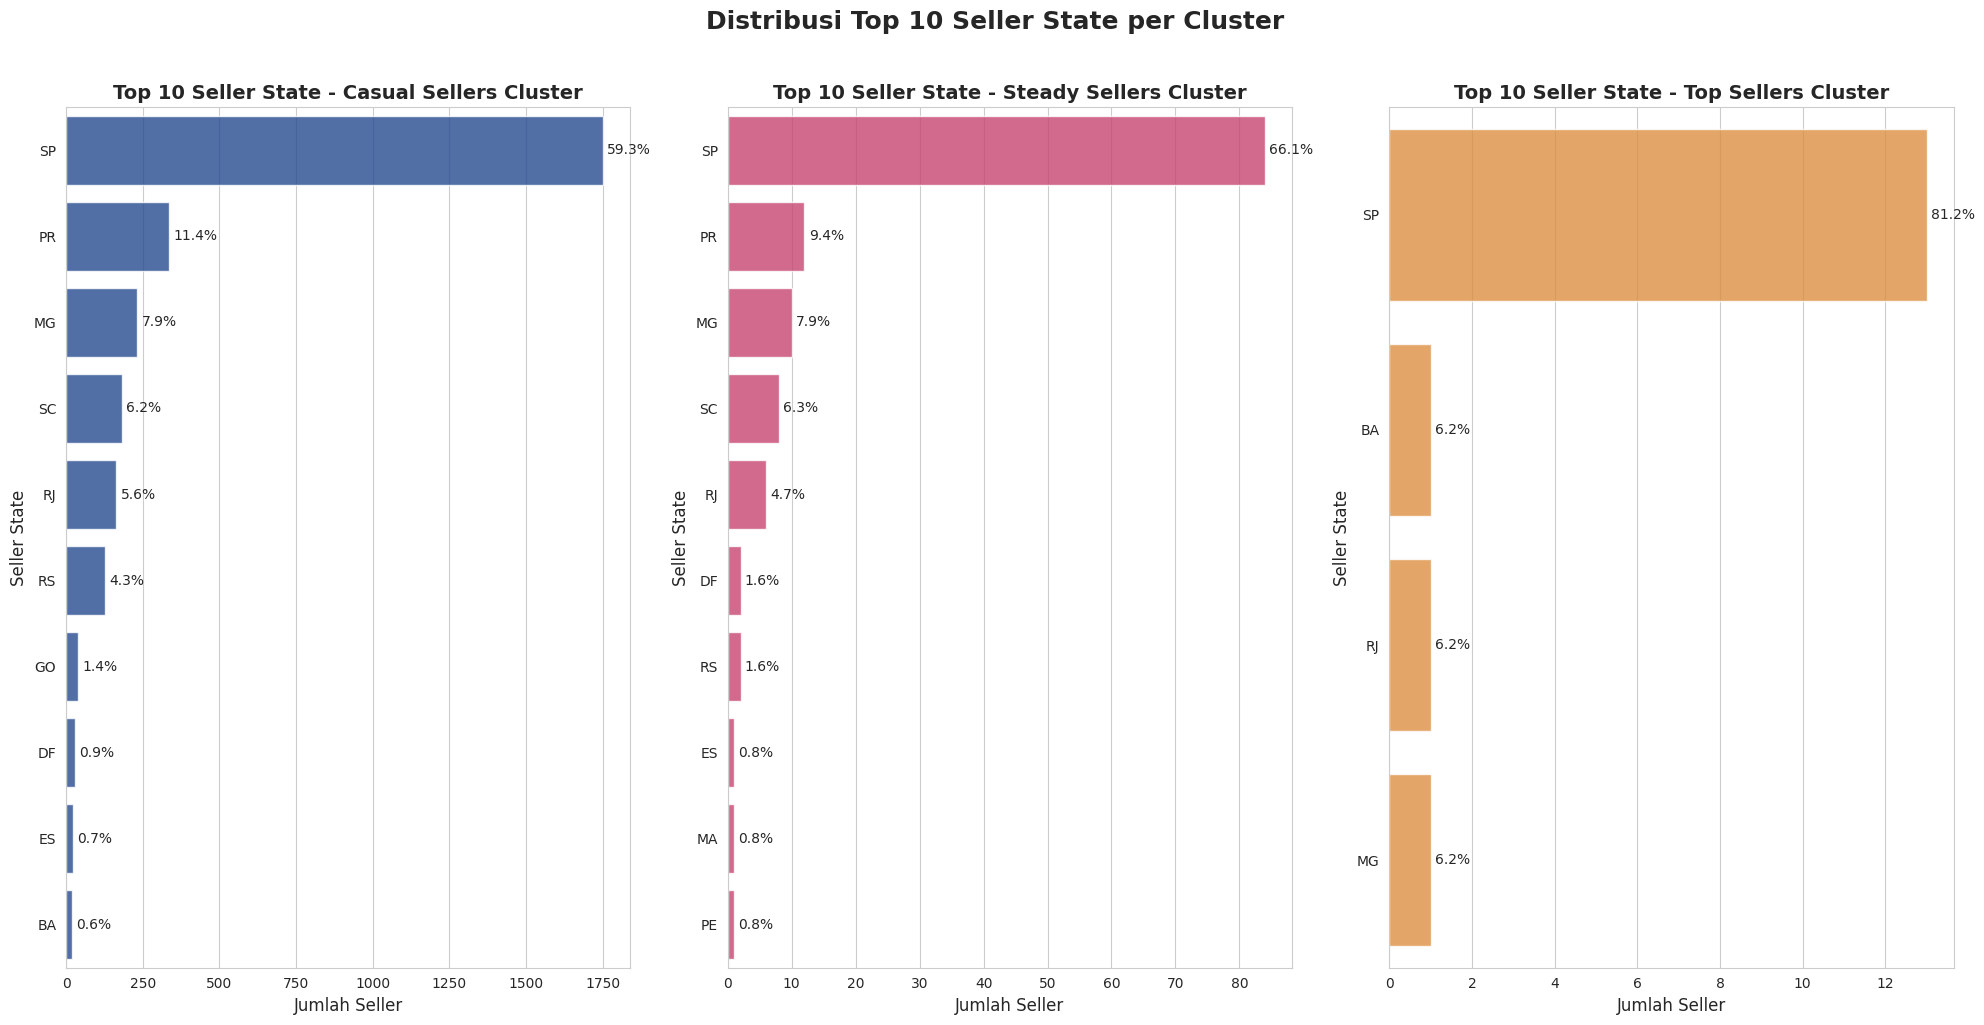

In [121]:
plt.figure(figsize=(20, 10))

for i, cluster in enumerate(loop_list):
    ax = plt.subplot(1, 3, i+1)

    counts = cluster["seller_state"].value_counts()
    order = counts.index[:10]

    sb.countplot(data=cluster,
                 y="seller_state",
                 order=order,
                 color=COLORS[i],
                 alpha=0.8)

    # Judul per plot
    ax.set_title(f"Top 10 Seller State - {loop_name[i]}", fontsize=14, weight="bold")
    ax.set_xlabel("Jumlah Seller", fontsize=12)
    ax.set_ylabel("Seller State", fontsize=12)

    total_top10 = counts.sum()

    pct_labels = [f"{v/total_top10*100:.1f}%" for v in counts.values]

    # Label di bar
    if ax.containers:
        ax.bar_label(ax.containers[0], labels=pct_labels[:10], fontsize=10, padding=3)


# Judul utama
plt.suptitle("Distribusi Top 10 Seller State per Cluster", fontsize=18, weight="bold", y=1.02)

plt.tight_layout()
plt.show()

Insight:
- Top Sellers Cluster paling terkonsentrasi di SP (Sao Paulo) (81,2%), menunjukkan pasar yang hampir eksklusif di sana.
- Steady Sellers cluster lebih beragam asalnya dibandingkan cluster Top Sellers. Seller yang berpotensi ini tidak hanya di SP, tapi juga di PR (Parana), MG (Minas Gerais), SC (Santa Catarina), dan RJ (Rio de Janeiro).
- Casual Sellers Cluster tetap terkonsentrasi di SP (59,3%), namun distribusi seller untuk setiap state lebih beragam, terutama state seperti PR, MG, SC, dan RJ.

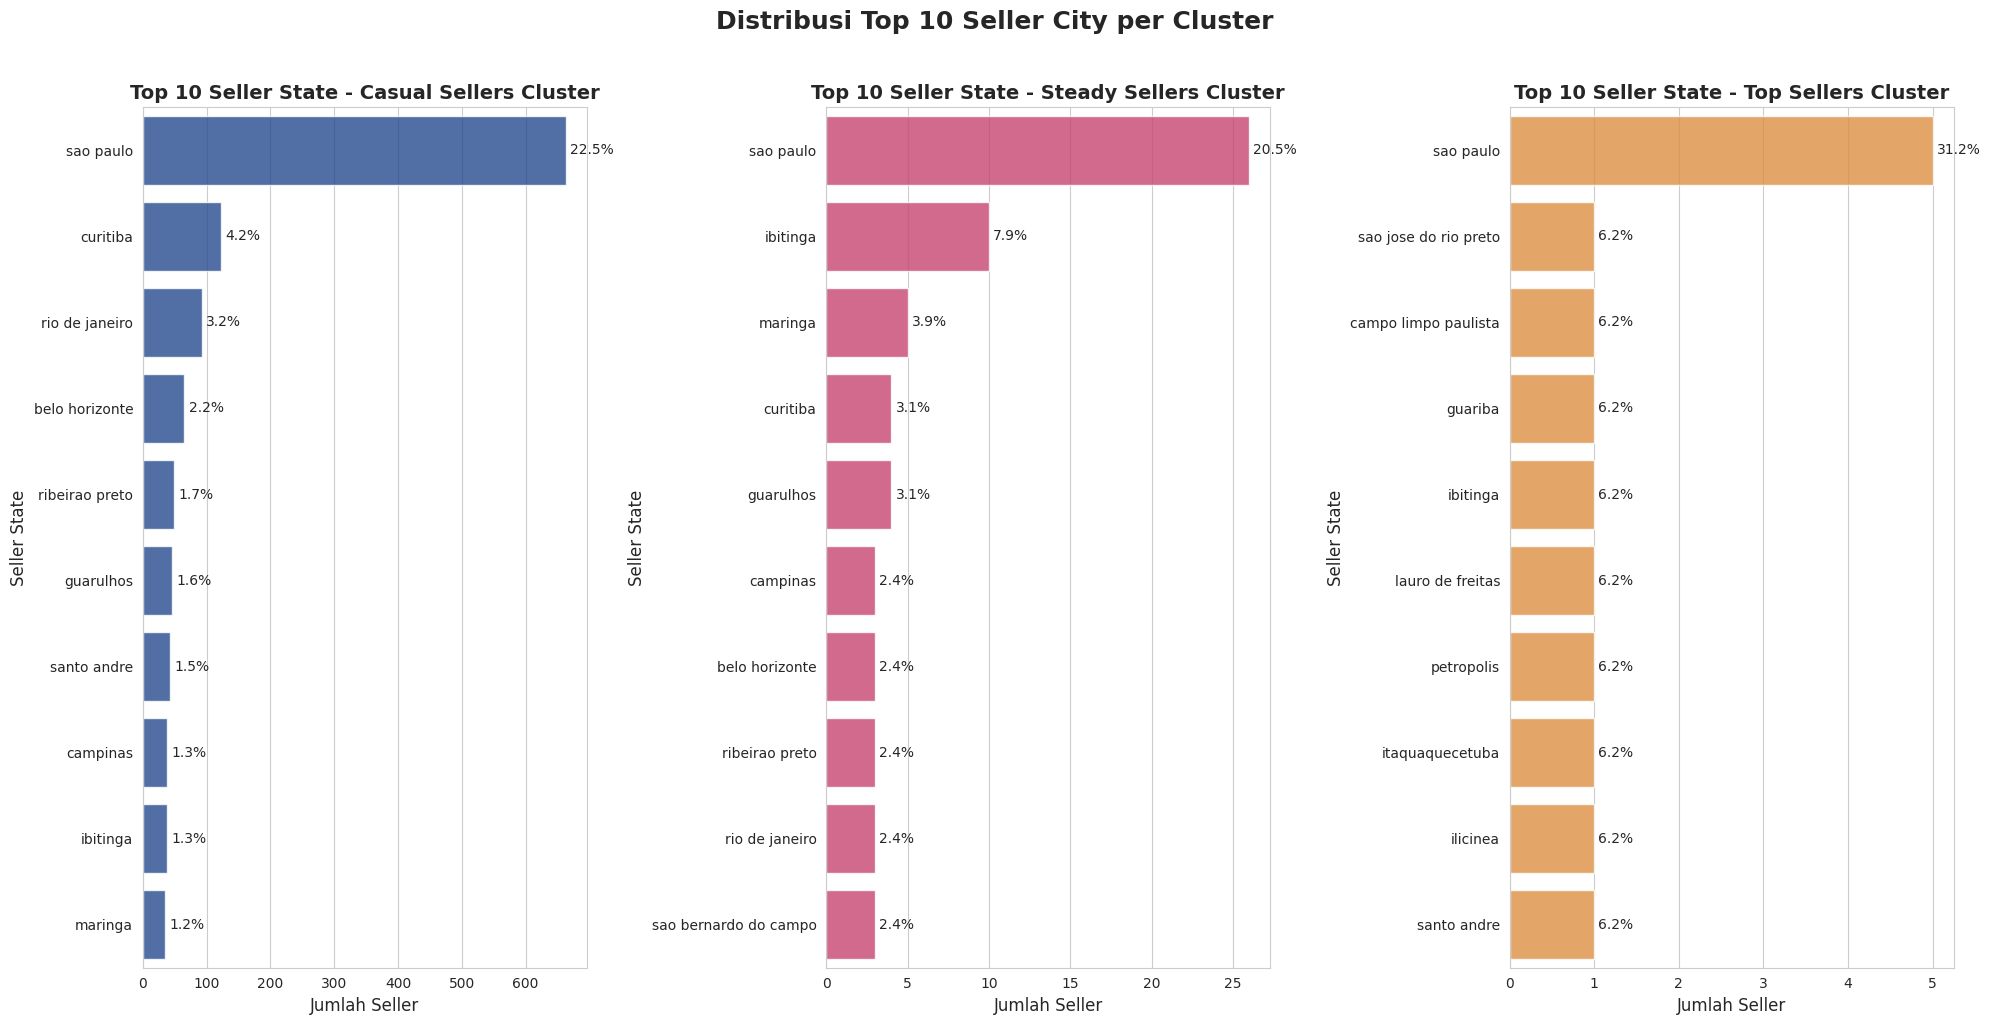

In [122]:
plt.figure(figsize=(20, 10))

for i, cluster in enumerate(loop_list):
    ax = plt.subplot(1, 3, i+1)

    counts = cluster["seller_city"].value_counts()
    order = counts.index[:10]

    sb.countplot(data=cluster,
                 y="seller_city",
                 order=order,
                 color=COLORS[i],
                 alpha=0.8)

    # Judul per plot
    ax.set_title(f"Top 10 Seller State - {loop_name[i]}", fontsize=14, weight="bold")
    ax.set_xlabel("Jumlah Seller", fontsize=12)
    ax.set_ylabel("Seller State", fontsize=12)

    # Label di bar
    total_top10 = counts.sum()

    pct_labels = [f"{v/total_top10*100:.1f}%" for v in counts.values]

    if ax.containers:
        ax.bar_label(ax.containers[0], labels=pct_labels[:10], fontsize=10, padding=3)

# Judul utama
plt.suptitle("Distribusi Top 10 Seller City per Cluster", fontsize=18, weight="bold", y=1.02)

plt.tight_layout()
plt.show()

Insight:
- Sao Paulo adalah pusat dominan di semua cluster (low, medium, high), konsisten menjadi kota dengan jumlah seller terbanyak.
- Casual Sellers sellers lebih menyebar luas ke berbagai kota, menandakan distribusi seller yang lebih luas tapi kontribusi yang minimal.
- Steady Sellers sellers lebih terdiversifikasi dibanding medium cluster. Selain SP, kota seperti Ibitinga, Maringa, Curitiba, Guarulhos, dan Campinas punya kontribusi penting bagi segmen bernilai tinggi.
- Top Sellers sellers sangat terkonsentrasi di SP, sisanya merata di kota kecil-menengah.

Insight Utama:
- SP (Sao Paulo) adalah pusat utama seller di semua cluster. Sehingga state/kota ini bisa menjadi fokus investasi lebih lanjut.
- Untuk ekspansi seller, state seperti PR (Parana), MG (Minas Gerais), SC (Santa Catarina) dan kota seperti Ibitinga, Maringa, dan Curitiba bisa jadi target menarik karena kontribusinya cukup signifikan.

## Product

In [123]:
cluster_0 = df_merged[df_merged["k_means_cluster"] == 0]
cluster_1 = df_merged[df_merged["k_means_cluster"] == 1]
cluster_2 = df_merged[df_merged["k_means_cluster"] == 2]


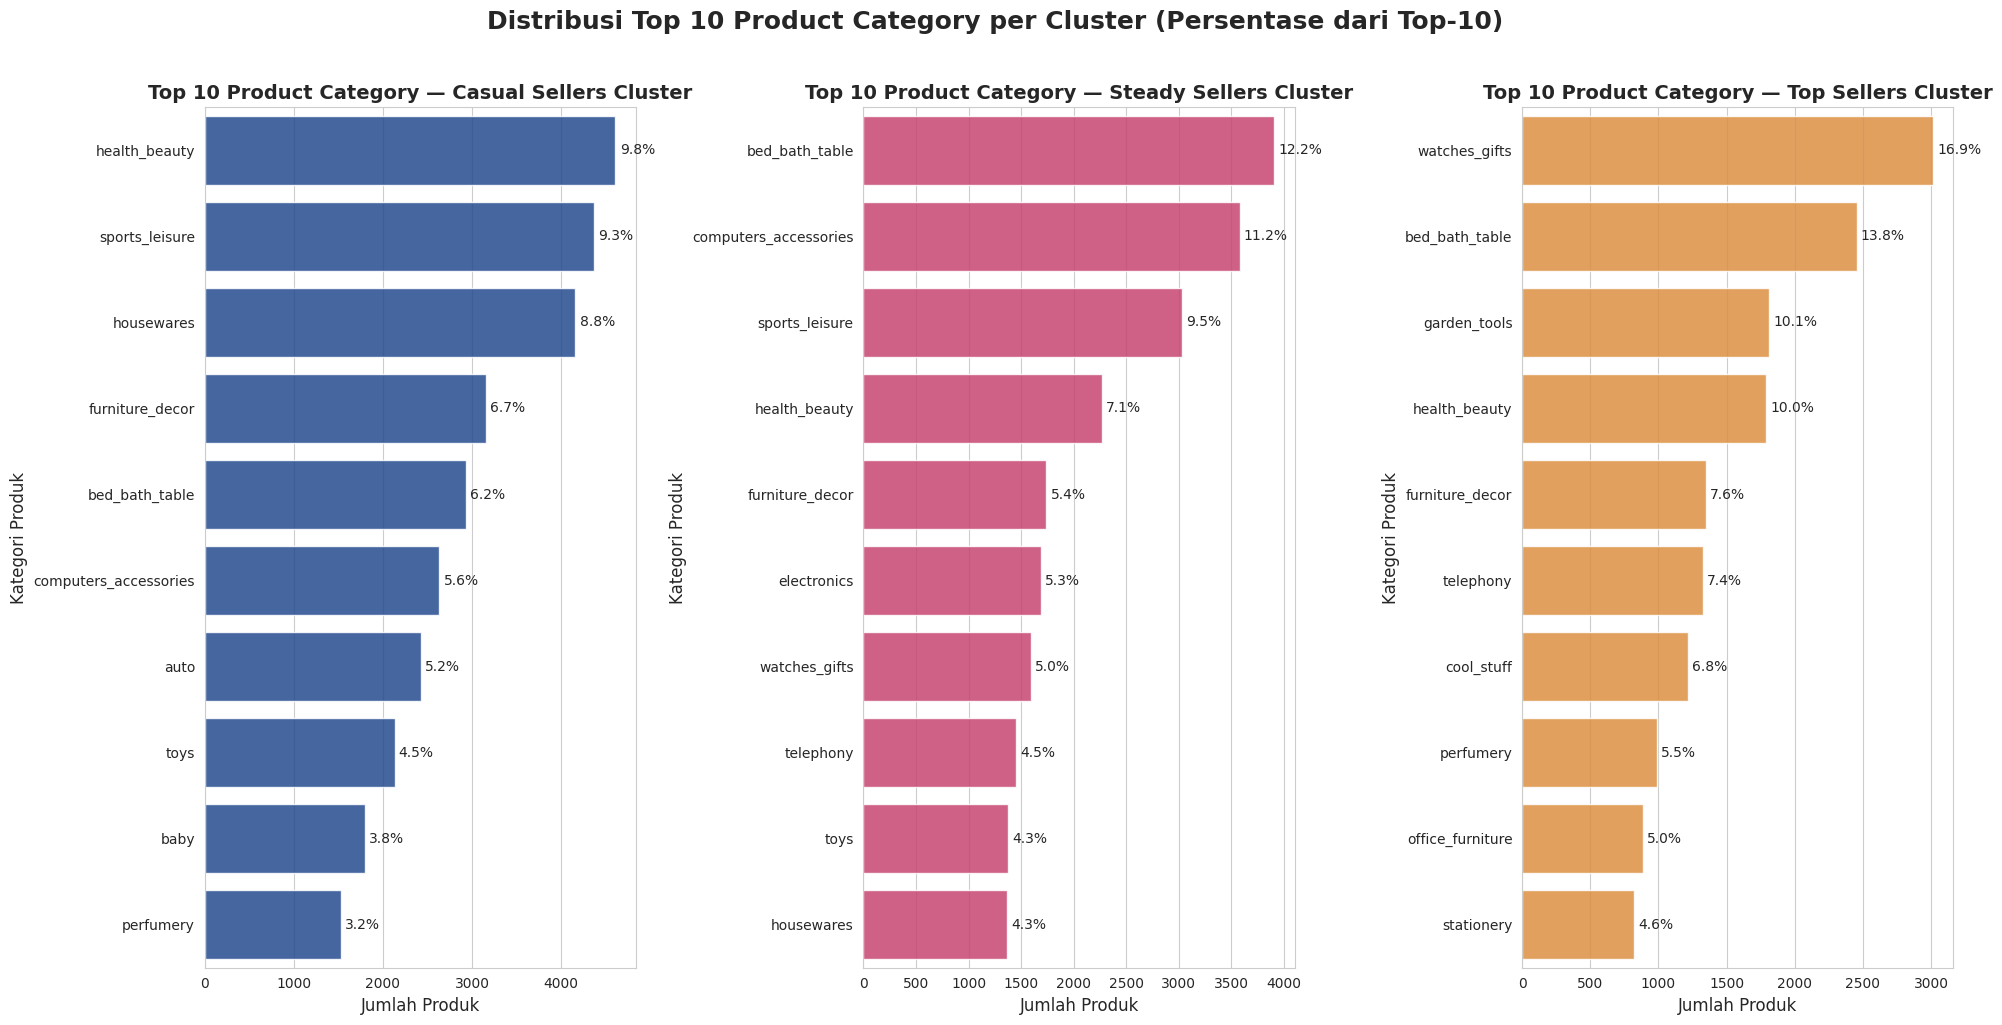

In [124]:
plt.figure(figsize=(20, 10))
loop_list = [cluster_0, cluster_2, cluster_1]

for i, cluster in enumerate(loop_list):
    ax = plt.subplot(1, 3, i+1)

    counts = cluster["product_category_name_english"].value_counts()
    order = counts.index[:10]

    sb.countplot(data=cluster,
                 y="product_category_name_english",
                 order=order,
                 color=COLORS[i],
                 alpha=0.85,
                 ax=ax)


    ax.set_title(f"Top 10 Product Category — {loop_name[i]}", fontsize=14, weight="bold")
    ax.set_xlabel("Jumlah Produk", fontsize=12)
    ax.set_ylabel("Kategori Produk", fontsize=12)

    total_top10 = counts.sum()

    pct_labels = [f"{v/total_top10*100:.1f}%" for v in counts.values]

    if ax.containers:
        ax.bar_label(ax.containers[0], labels=pct_labels[:10], fontsize=10, padding=3)

plt.suptitle("Distribusi Top 10 Product Category per Cluster (Persentase dari Top-10)", fontsize=18, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

Insight:

**Casual Sellers Cluster**
- Kategori "health_beauty" mendominasi dengan 9,8%, diikuti oleh "sports_leisure" (9,3%) dan "housewares" (8,8%).
- Cluster ini lebih banyak menjual produk konsumsi cepat (perawatan diri, olahraga, hobi). Produk semacam ini cenderung repeat purchase tinggi.

**Steady Sellers Cluster**
- Kategori "bed_bath_table" unggul dengan 12,2%, diikuti oleh "computers_accessories" (11,2%) dan "sports_leisure" (9,5%).
- Produk yang dijual bersifat utilitarian dan durable (perlengkapan rumah & gadget). Pembelian tidak sesering cluster Casual, tapi bernilai lebih tinggi

**Top Sellers Cluster**
- Kategori "watches_gifts" memimpin dengan 16,9%, diikuti oleh "bed_bath_table" (13,8%) dan "garden_tools" (10,1%).
- Cluster ini menguasai kategori gift & lifestyle yang punya margin besar dan permintaan tinggi pada momen tertentu (event-driven).

**Kesimpulan Umum**
- Casual Sellers → fokus volume & frekuensi transaksi (promosi ringan, bundle).
- Steady Sellers → fokus retensi & cross-sell produk durable (after-sales, upsell).
- Top Sellers → fokus margin & kampanye musiman (premium positioning, ads push).


In [125]:
cluster_0_agg = cluster_0.groupby("product_category_name_english").agg(
    total_seller = ("seller_id", "nunique")
)
cluster_1_agg = cluster_1.groupby("product_category_name_english").agg(
    total_seller = ("seller_id", "nunique")
)
cluster_2_agg = cluster_2.groupby("product_category_name_english").agg(
    total_seller = ("seller_id", "nunique")
)

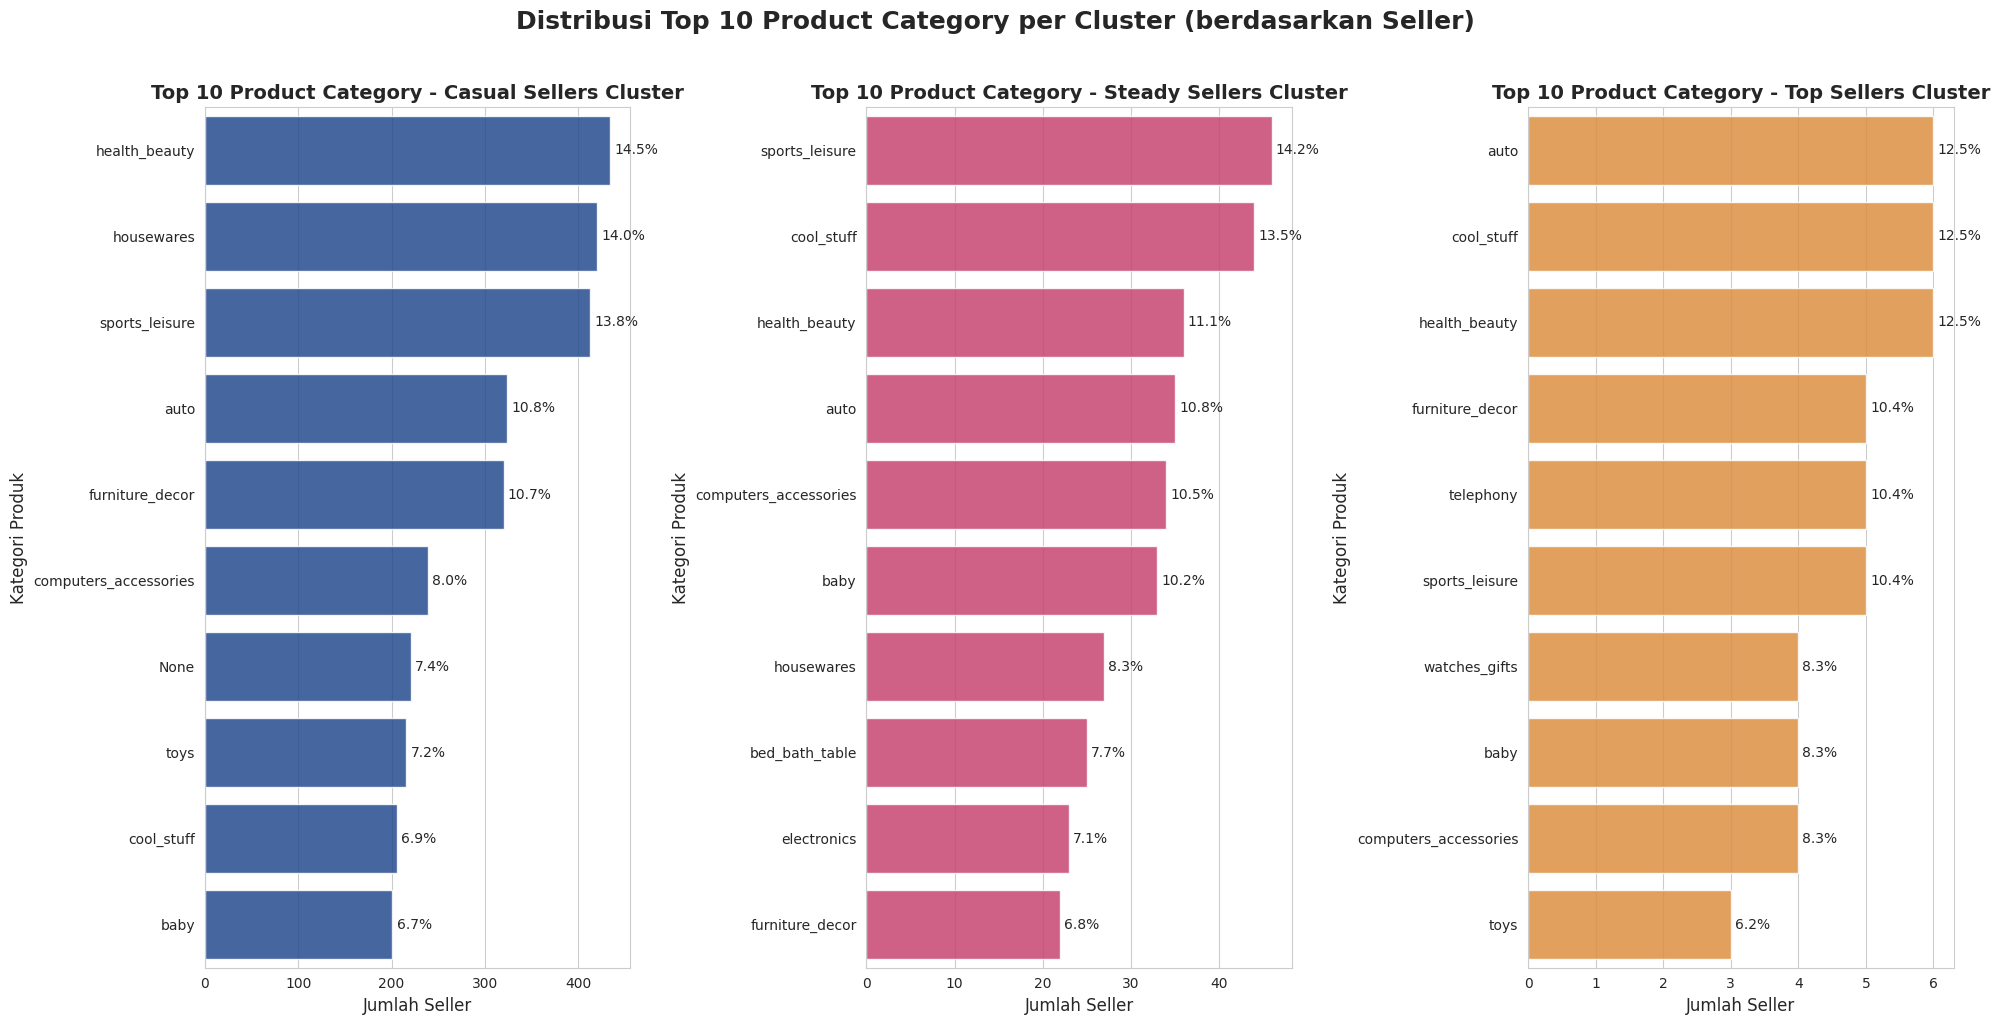

In [126]:
plt.figure(figsize=(20, 10))
loop_list = [cluster_0_agg, cluster_2_agg, cluster_1_agg]

for i, cluster in enumerate(loop_list):
    ax = plt.subplot(1, 3, i+1)

    top10 = cluster.sort_values("total_seller", ascending=False).head(10)

    sb.barplot(data=top10,
               x="total_seller",
               y="product_category_name_english",
               color=COLORS[i],
               alpha=0.85,
               ax=ax)

    ax.set_title(f"Top 10 Product Category - {loop_name[i]}", fontsize=14, weight="bold")
    ax.set_xlabel("Jumlah Seller", fontsize=12)
    ax.set_ylabel("Kategori Produk", fontsize=12)

    total_top10 = top10["total_seller"].sum()

    pct_labels = [f"{v/total_top10*100:.1f}%" for v in top10["total_seller"]]

    if ax.containers:
        ax.bar_label(ax.containers[0], labels=pct_labels, fontsize=10, padding=3)

plt.suptitle("Distribusi Top 10 Product Category per Cluster (berdasarkan Seller)", fontsize=18, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

Insight:

**Casual Sellers Cluster**
- Kategori "health_beauty" dan "housewares" sama-sama mendominasi dengan 14,5% dan 14%, diikuti oleh "sports_leisure" (13,8%).
- Banyak seller pemula masuk ke kategori mass market seperti beauty, rumah tangga, dan leisure. Artinya, kompetisi tinggi dan margin bisa lebih tipis.

**Steady Sellers Cluster**
- Kategori "sports_leisure" unggul dengan 14,2%, diikuti oleh "cool_stuff" (13,5%) dan "health_beauty" (11,1%).
- Seller di cluster ini cenderung lebih stabil & konsisten menjual kategori rekreasi, barang unik, dan perawatan diri. Ini sinyal bahwa kategori ini potensial jadi core revenue stream jangka menengah.

**Top Sellers Cluster**
- Kategori "auto", "cool_stuff" dan "health_beauty" sama-sama memimpin dengan 12,5%.
- Seller terbaik lebih tersebar di berbagai kategori, terutama otomotif, lifestyle unik, dan beauty. Kategori ini bisa jadi driver utama growth karena seller top biasanya punya jaringan & brand lebih kuat.

**Perbedaan Pola Seller**
- Health & Beauty → konsisten tinggi di Casual & Top Sellers → kategori yang kompetitif tapi stabil.
- Sports Leisure → naik di Steady Sellers → kategori sedang tumbuh dan berpotensi jadi penggerak penjualan jangka panjang.
- Auto & Cool Stuff → dominasi di Top Sellers → kategori high-value, low-volume seller → fokus rekrut seller besar/profesional.

**Kesimpulan Umum**
- Casual Sellers → crowded market, butuh diferensiasi & edukasi seller.
- Steady Sellers → kategori inti (sports & lifestyle), perlu retensi & ekspansi kategori.
- Top Sellers → kategori otomotif & lifestyle unik jadi growth engine, perlu dukungan premium.


In [127]:
cluster_0_agg = cluster_0.groupby("seller_id").agg(
    total_product = ("product_id", "nunique")
)
cluster_1_agg = cluster_1.groupby("seller_id").agg(
    total_product = ("product_id", "nunique")
)
cluster_2_agg = cluster_2.groupby("seller_id").agg(
    total_product = ("product_id", "nunique")
)

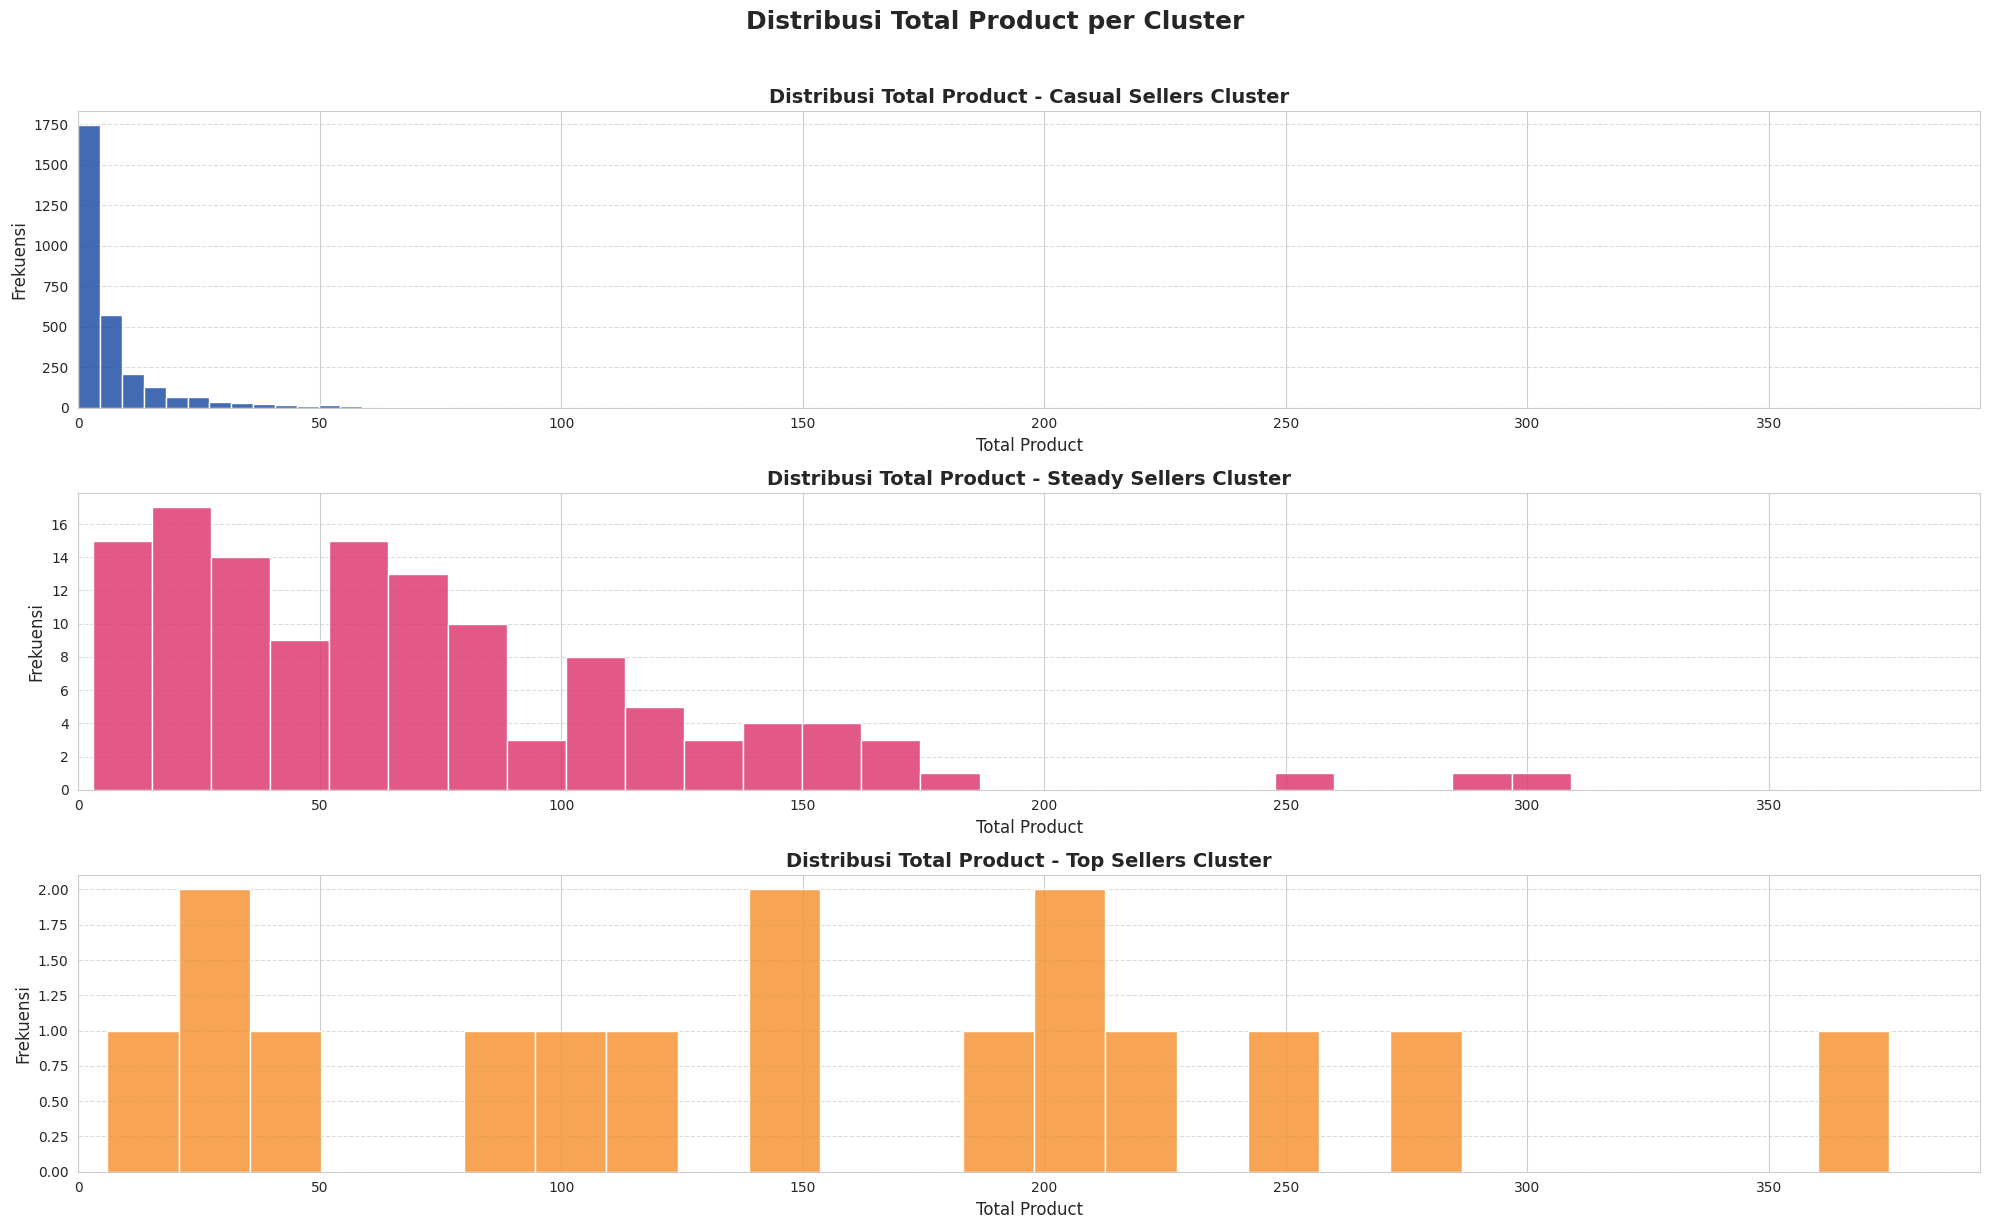

In [128]:
plt.figure(figsize=(20, 12))
loop_list = [cluster_0_agg, cluster_2_agg, cluster_1_agg]

for i, cluster in enumerate(loop_list):
    ax = plt.subplot(3, 1, i+1, sharex= ax)
    sb.histplot(data=cluster,
                x="total_product",
                bins=25,
                color=COLORS[i],
                alpha=0.8,
                ax=ax)

    ax.set_title(f"Distribusi Total Product - {loop_name[i]}", fontsize=14, weight="bold")
    ax.set_xlabel("Total Product", fontsize=12)
    ax.set_ylabel("Frekuensi", fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Distribusi Total Product per Cluster", fontsize=18, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

Insight:

**Casual Sellers Cluster**
- Distribusi sangat skew ke kanan, dengan puncak frekuensi di sekitar 0-20 produk untuk setiap seller.
- Mayoritas seller hanya menjual sedikit produk. Ini tanda mereka masih tahap awal/eksperimen dan kontribusi ke total penjualan relatif kecil.

**Steady Sellers Cluster**
- Distribusi juga skew ke kanan, dengan puncak frekuensi di 0-50 produk dan penurunan bertahap hingga 300 produk.
- Seller di sini lebih konsisten dengan jumlah produk cukup banyak, menunjukkan komitmen lebih tinggi daripada casual sellers.

**Top Sellers Cluster**:
- Distribusi lebih merata. Ini mengindikasikan variasi yang lebih besar dalam jumlah produk per seller. Ini menunjukan seller di cluster ini lebih berpotensi memiliki total product yang besar
- Seller di cluster ini jelas berorientasi bisnis besar dengan variasi produk luas. Mereka adalah penggerak utama revenue.

Insight utama:
- Jumlah variasi produk berbanding lurus dengan performa seller. Semakin beragam produk, semakin tinggi potensi menjadi steady atau top seller.

In [129]:
# Rata-rata Harga Produk per Cluster
avg_price = df_merged.groupby("cluster_name")["price"].mean().round(2)
print(avg_price)

cluster_name
Casual Sellers    130.38
Steady Sellers    123.31
Top Sellers       113.95
Name: price, dtype: float64


In [130]:
# Rata-rata Ongkir (Freight) per Cluster
avg_freight = df_merged.groupby("cluster_name")["freight_value"].mean().round(2)
print(avg_freight)

cluster_name
Casual Sellers    20.87
Steady Sellers    19.34
Top Sellers       19.57
Name: freight_value, dtype: float64


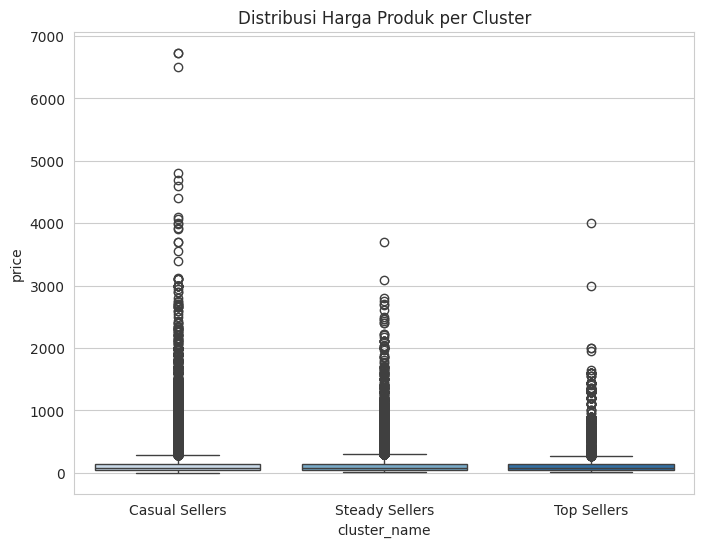

In [131]:
plt.figure(figsize=(8,6))
sb.boxplot(data=df_merged, x="cluster_name", y="price", palette="Blues")
plt.title("Distribusi Harga Produk per Cluster")
plt.show()

**Casual Sellers Cluster**
- Sebagian besar membeli produk dengan harga relatif rendah.
- Banyak outlier harga tinggi, tapi median tetap kecil. Artinya mereka jarang membeli produk mahal.

**Steady Sellers Cluster**
- Median harga sedikit lebih tinggi dibanding Casual Sellers Cluster.
- Sebagian mulai menjangkau produk dengan harga lebih mahal, meski mayoritas masih di level rendah-menengah.

**Top Sellers Cluster**
- Distribusi harga hampir sama dengan Casual & Steady Sellers Cluster (banyak produk low-mid price).
- Namun ada indikasi seller ini juga melakukan pembelian produk dengan harga lebih premium.

**Insight utama**
- Perbedaan nilai antar cluster bukan terutama karena perbedaan harga produk yang dibeli, tetapi lebih karena frekuensi dan volume pembelian. Dengan kata lain, Top Sellers Cluster tidak selalu menjual produk mahal, tetapi bertransaksi lebih sering dan dalam jumlah lebih banyak.

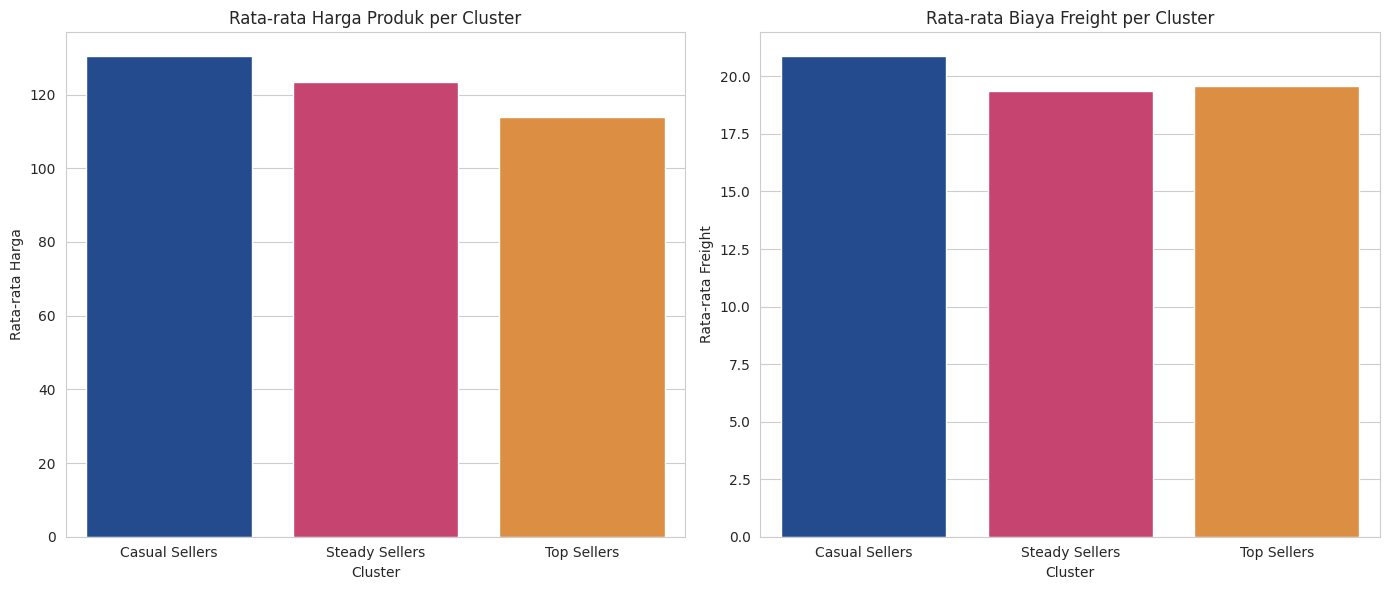

In [132]:
# --- Hitung rata-rata freight dan price per cluster ---
cluster_freight_price = df_merged.groupby('cluster_name')[['price', 'freight_value']].mean().reset_index()

# --- Plot side by side barplot ---
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sb.barplot(
    data=cluster_freight_price,
    x='cluster_name', y='price',
    palette=COLORS, ax=axes[0],
    order = order_cluster
)
axes[0].set_title("Rata-rata Harga Produk per Cluster")
axes[0].set_ylabel("Rata-rata Harga")
axes[0].set_xlabel("Cluster")

sb.barplot(
    data=cluster_freight_price,
    x='cluster_name', y='freight_value',
    palette=COLORS, ax=axes[1],
    order = order_cluster
)
axes[1].set_title("Rata-rata Biaya Freight per Cluster")
axes[1].set_ylabel("Rata-rata Freight")
axes[1].set_xlabel("Cluster")

plt.tight_layout()
plt.show()

### Rata-rata Harga Produk per Cluster
- Casual Sellers menjual produk dengan rata-rata harga lebih tinggi dibanding Steady dan Top Sellers.
- Top Sellers justru menjual produk dengan rata-rata harga lebih rendah, tapi dengan volume lebih besar.
- Ini menegaskan bahwa kinerja seller top tidak ditentukan oleh harga premium, tetapi oleh jumlah transaksi & variasi produk.
- Kesimpulan:
  - Casual Sellers → perlu diarahkan untuk menambah variasi produk agar tidak hanya bergantung pada produk mahal dengan volume rendah.
  - Top Sellers → bisa difokuskan pada strategi bundling & cross-selling untuk meningkatkan average order value (AOV).

### Rata-rata Biaya Freight per Cluster
- Ongkir relatif seragam (18–21) di semua cluster, dengan Casual Sellers sedikit lebih tinggi. Artinya, ongkir bukan faktor pembeda utama performa seller.
- Kesimpulan:
  - Karena ongkir relatif sama, diferensiasi layanan logistik tidak cukup untuk meningkatkan performa seller.
  - Lebih baik perusahaan optimalkan insentif logistik berbasis volume transaksi (contoh: subsidi ongkir hanya untuk seller dengan jumlah order tertentu).

### Kesimpulan Utama
- Top Sellers unggul bukan karena harga lebih mahal, tapi karena skala & frekuensi transaksi.
- Ongkir tidak signifikan dalam membedakan cluster seller, sehingga strategi pertumbuhan lebih efektif diarahkan pada volume & variasi produk dibanding subsidi ongkir semata.

     cluster_name  total_items  total_revenue  total_freight
0  Casual Sellers        47123     6144119.34      983507.58
1  Steady Sellers        32054     3952560.18      620076.86
2     Top Sellers        17830     2031753.98      348930.34


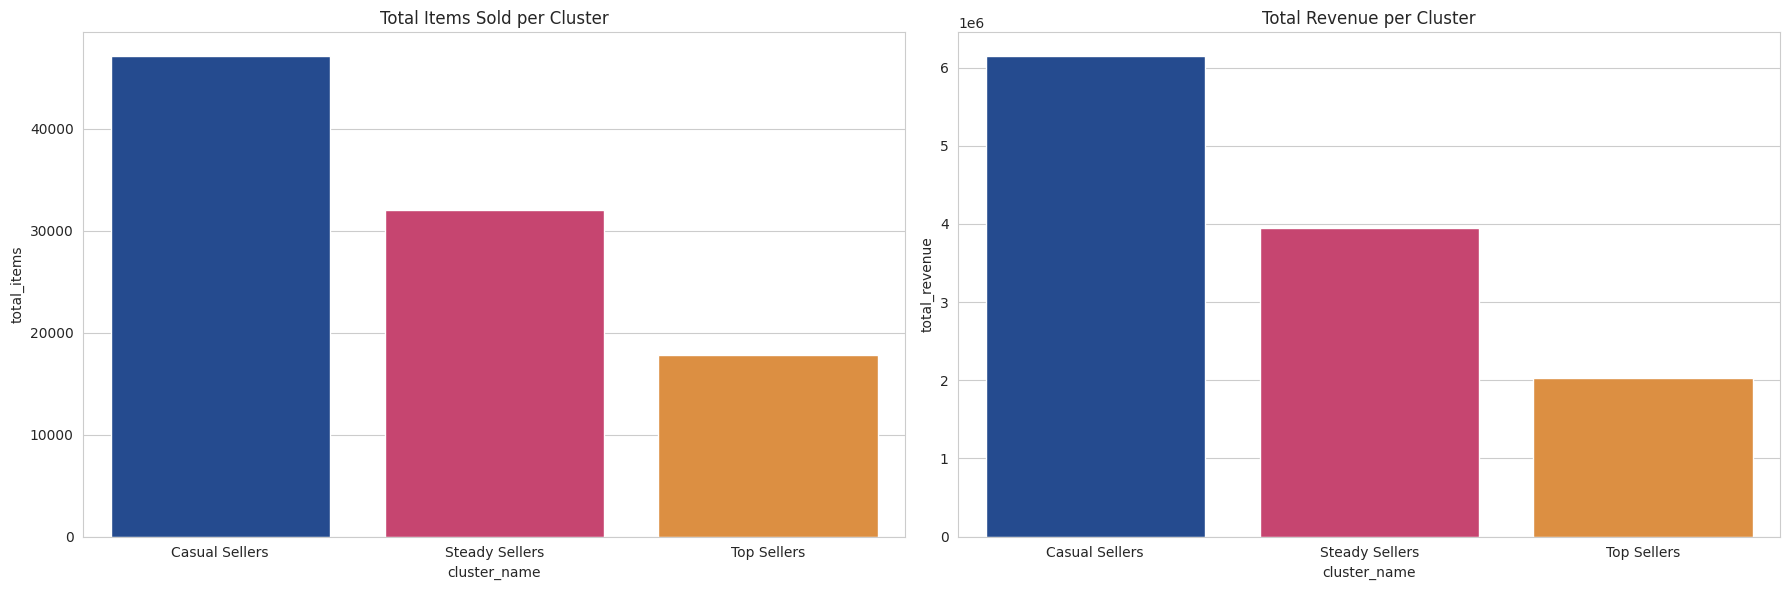

In [133]:
# --- Agregasi customer behavior per cluster ---
cluster_behavior = df_merged.groupby('cluster_name').agg({
    'order_item_id': 'count',   # jumlah item total
    'price': 'sum',             # total revenue
    'freight_value': 'sum'      # total freight
}).reset_index()

cluster_behavior.rename(columns={
    'order_item_id': 'total_items',
    'price': 'total_revenue',
    'freight_value': 'total_freight'
}, inplace=True)

print(cluster_behavior)

# --- Visualisasi ---
fig, axes = plt.subplots(1, 2, figsize=(18,6))

sb.barplot(
    data=cluster_behavior,
    x='cluster_name', y='total_items',
    palette = COLORS, ax=axes[0],
    order = order_cluster
)
axes[0].set_title("Total Items Sold per Cluster")

sb.barplot(
    data=cluster_behavior,
    x='cluster_name', y='total_revenue',
    palette = COLORS, ax=axes[1],
    order = order_cluster
)
axes[1].set_title("Total Revenue per Cluster")

plt.tight_layout()
plt.show()

### Total Items Sold per Cluster
- Casual Sellers Cluster: Jumlah item terjual paling tinggi (>55 ribu).
- Steady Sellers Cluster: Sekitar 35 ribu item.
- Top Sellers Cluster: Paling rendah (~20 ribu item).
- Kesimpulan: Pola sama dengan jumlah order, Seller di Casual Sellers cluster memiliki total transaksi yang terbesar. Namun ketergantungan yang besar pada cluster ini berisiko—Steady Sellers perlu ditingkatkan kontribusinya agar distribusi transaksi lebih seimbang.

### Total Revenue per Cluster
- Casual Sellers Cluster: Pendapatan tertinggi (~6.8 juta).
- Steady Sellers Cluster: Pendapatan menengah (~4.3 juta).
- Top Sellers Cluster: Pendapatan paling rendah (~2.2 juta).
- Kesimpulan: Casual Sellers cluster adalah kontributor utama terhadap total pendapatan perusahaan. Artinya revenue perusahaan masih terlalu bertumpu pada cluster ini; memperkuat Steady Sellers dan mengevaluasi potensi Top Sellers akan penting untuk pertumbuhan yang lebih stabil.

In [134]:
df_pay_merged = pd.merge(df_merged, order_payments_max, on="order_id", how="left")

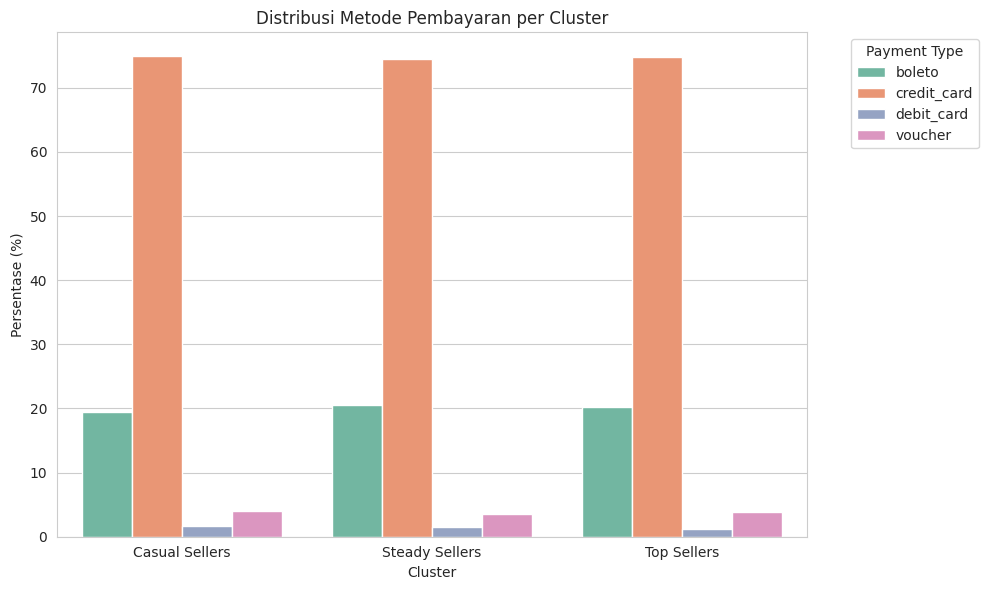

payment_type    boleto  credit_card  debit_card  voucher
cluster_name                                            
Casual Sellers   19.40        74.90        1.68     4.02
Steady Sellers   20.48        74.45        1.53     3.55
Top Sellers      20.20        74.83        1.19     3.78


In [135]:
# --- Hitung distribusi metode pembayaran per cluster ---
payment_dist = (
    df_pay_merged.groupby(['cluster_name', 'payment_type'])
    .size()
    .reset_index(name='count')
)

# Hitung persentase dalam tiap cluster
cluster_totals = payment_dist.groupby('cluster_name')['count'].transform('sum')
payment_dist['percentage'] = (payment_dist['count'] / cluster_totals) * 100

# --- Visualisasi: Stacked Bar Chart ---
plt.figure(figsize=(10,6))
sb.barplot(
    data=payment_dist,
    x='cluster_name', y='percentage', hue='payment_type',
    palette='Set2',
    order = order_cluster
)

plt.title("Distribusi Metode Pembayaran per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Persentase (%)")
plt.legend(title="Payment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Tabel ringkasan ---
payment_summary = payment_dist.pivot(
    index='cluster_name',
    columns='payment_type',
    values='percentage'
).fillna(0)

print(payment_summary.round(2))

### Insight
- Dominasi Credit Card di Semua Segmen Seller (~75%)
→ Artinya, mayoritas transaksi tetap bertumpu pada kartu kredit tanpa banyak variasi antar cluster. Ini menunjukkan bahwa infrastruktur pembayaran sudah mature di segmen credit card, tapi ketergantungan tinggi pada satu metode juga meningkatkan risiko apabila tren penggunaan kartu kredit menurun atau ada regulasi baru.

- Boleto Masih Jadi Alternatif Kuat (~20%)
→ Walaupun tidak sebesar kartu kredit, boleto masih punya porsi signifikan dan stabil di semua cluster. Ini menunjukkan adanya peluang menjaga inklusivitas untuk pelanggan non-kartu kredit (misalnya segmen menengah ke bawah atau unbanked).

- Debit Card & Voucher Sangat Rendah (<5%)
→ Kedua metode ini tidak mendapat adopsi luas, padahal voucher bisa menjadi strategi loyalty/retention tool dan debit card biasanya lebih mudah diakses pelanggan dibanding kartu kredit.

- Kesimpulan: Bisnis saat ini terlalu bergantung pada kartu kredit sebagai metode pembayaran utama. Untuk memperkuat daya saing dan retensi, perlu strategi meningkatkan adopsi metode alternatif (debit card, voucher, atau paylater) sambil tetap menjaga akses bagi pelanggan boleto yang masih signifikan.

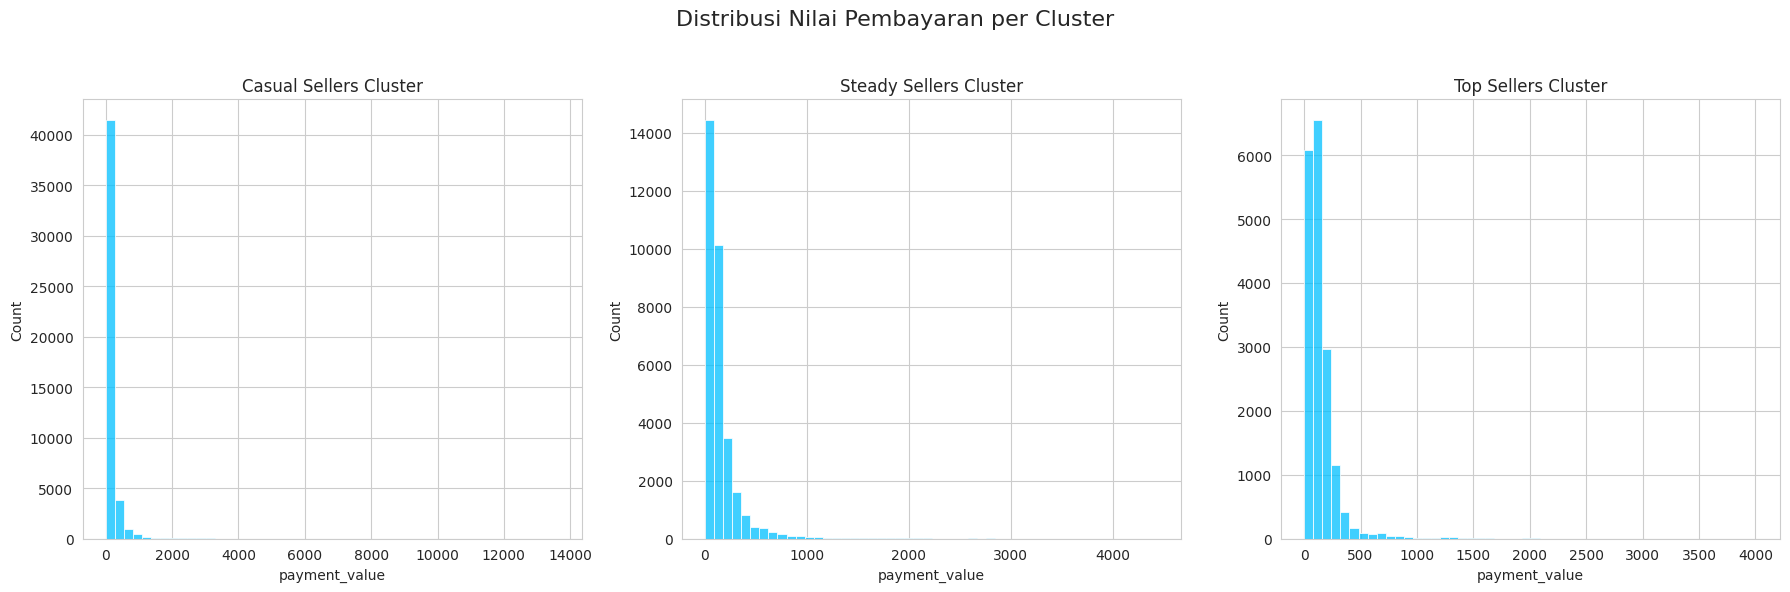

In [136]:
plt.figure(figsize=(18,6))
for i, cluster_id in enumerate([0,2,1]):
    plt.subplot(1,3,i+1)
    sb.histplot(
        data=df_pay_merged[df_pay_merged['k_means_cluster']==cluster_id],
        x='payment_value',
        bins=50,
        color='deepskyblue'
    )
    plt.title(f"{loop_name[i]}")

plt.suptitle("Distribusi Nilai Pembayaran per Cluster", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

### Insight

**Casual Sellers Cluster**
- Transaksi sangat banyak tapi hampir semuanya bernilai kecil.
- Ini menunjukkan volume tinggi tapi value rendah, sehingga kontribusi ke revenue terbatas.
- Cocok untuk strategi efisiensi biaya transaksi & program loyalitas yang mendorong peningkatan nilai rata-rata per transaksi (average order value).

**Steady Sellers Cluster**
- Nilai pembayaran lebih bervariasi, ada kombinasi transaksi kecil dan menengah.
- Potensi untuk ditingkatkan melalui cross-selling/upselling, karena mereka sudah terbiasa dengan nominal pembayaran beragam.

**Top Sellers Cluster**
- Walau jumlah transaksi lebih sedikit, proporsi transaksi bernilai menengah–besar lebih tinggi dibanding cluster lain.
- Cluster ini berperan penting sebagai penyumbang revenue terbesar.
- Strategi bisnis: berikan service premium, insentif eksklusif, dan menjaga retensi seller ini karena dampaknya langsung ke pendapatan utama.

Statistik Per Cluster
     cluster_name  count        mean  median         std   min       max  \
0  Casual Sellers  47122  163.547770  103.38  247.899883  0.00  13664.08   
1  Steady Sellers  32054  152.816178   99.90  189.861770  0.01   4445.50   
2     Top Sellers  17830  147.261593  105.70  159.301774  0.00   4016.91   

        total  
0  7706698.03  
1  4898369.77  
2  2625674.21  


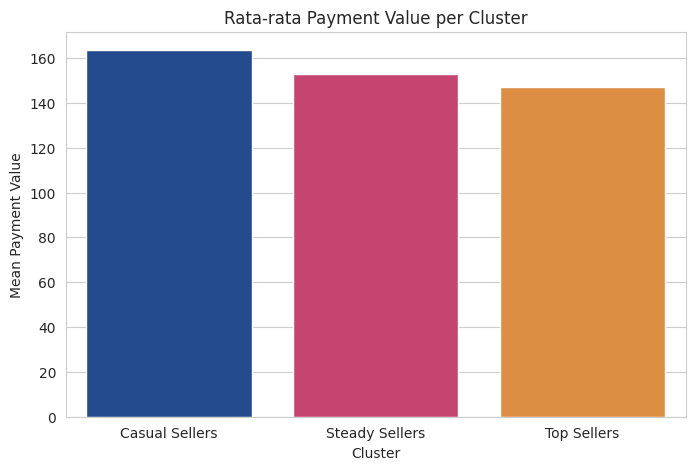

In [137]:
# --- Statistik Per Cluster ---
cluster_stats = df_pay_merged.groupby('cluster_name')['payment_value'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max',
    total='sum'
).reset_index()

print("Statistik Per Cluster")
print(cluster_stats)

# --- Visualisasi: Rata-rata Payment Value per Cluster ---
plt.figure(figsize=(8,5))
sb.barplot(data = cluster_stats,
           x = cluster_stats['cluster_name'],
           y = cluster_stats['mean'], palette=COLORS,
           order = order_cluster)
plt.title("Rata-rata Payment Value per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Payment Value")
plt.show()

### Rata-rata Payment Value per Cluster
- Casual Sellers (163 per transaksi – tertinggi)
  - Walaupun jumlah transaksinya sedikit, nilai per transaksi rata-rata 10–16 poin lebih tinggi dibanding cluster lain.
  - Mereka cenderung menjual produk bernilai tinggi (high-ticket items) tapi frekuensinya rendah.
  - Jika frekuensi transaksi mereka bisa dinaikkan 20–30%, potensi kontribusi revenue dari segmen ini akan naik signifikan.

- Steady Sellers (152 per transaksi – menengah)
  - Nilainya lebih rendah 7% dibanding Casual Sellers.
  - Mereka relatif stabil, menjual produk harga menengah, tapi tidak menonjol di sisi nilai maupun volume.
  - Dengan insentif/loyalty, mereka bisa diarahkan naik ke arah Top Sellers (volume tinggi) atau diarahkan menjual produk bernilai lebih tinggi (naikkan ticket size).

- Top Sellers (147 per transaksi – terendah)
  - Nilainya lebih rendah 16 poin (−10%) dibanding Casual Sellers.
  - Mereka lebih mengandalkan volume transaksi dengan produk harga rendah-menengah (mass-market strategy).
  - Ada peluang menaikkan ticket size melalui bundling, upselling, atau rekomendasi produk premium. Jika rata-rata bisa dinaikkan dari 147 → 155, tambahan revenue akan sangat besar karena basis transaksinya sudah tinggi.

In [138]:
df_orders_merged = df_merged.copy()

df_orders_merged.head()

order_id                       customer_id  \
0  9dc8d1a6f16f1b89874c29c9d8d30447  d9442164acf4b03109425633efaa0cfc   
1  d455a8cb295653b55abda06d434ab492  944b72539d7e1f7f7fc6e46639ef1fe3   
2  7f39ba4c9052be115350065d07583cac  d7fc82cbeafea77bd0a8fbbf6296e387   
3  e6ce16cb79ec1d90b1da9085a6118aeb  494dded5b201313c64ed7f100595b95c   
4  6ebaec694d7025e2ad4a05dba887c032  4f28355e5c17a4a42d3ce2439a1d4501   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered               2017-10-12        2017-10-12   
1    delivered               2017-09-26        2017-09-27   
2    delivered               2017-10-18        2017-10-18   
3    delivered               2017-05-16        2017-05-16   
4    delivered               2017-05-18        2017-05-18   

  order_delivered_carrier_date order_delivered_customer_date  \
0                   2017-10-17                    2017-10-24   
1                   2017-09-29                    2017-10-07   
2                   2017-10-20                    2017-10-27   
3                   2017-05-18                    2017-05-29   
4                   2017-05-19                    2017-05-29   

  order_estimated_delivery_date  order_item_id  \
0                    2017-11-06            1.0   
1                    2017-10-30            1.0   
2                    2017-11-09            1.0   
3                    2017-06-07            2.0   
4                    2017-06-09            1.0   

                         product_id  ... order_month recency  frequency  \
0  a2ff5a97bf95719e38ea2e3b4105bce8  ...     2017-10   316.0          3   
1  a2ff5a97bf95719e38ea2e3b4105bce8  ...     2017-09   316.0          3   
2  a2ff5a97bf95719e38ea2e3b4105bce8  ...     2017-10   316.0          3   
3  08574b074924071f4e201e151b152b4e  ...     2017-05    49.0        195   
4  e251ebd2858be1aa7d9b2087a6992580  ...     2017-05    49.0        195   

   monetary average_rating  total_price_y total_freight_y cluster  \
0   2748.06       3.666667        2685.00           63.06       0   
1   2748.06       3.666667        2685.00           63.06       0   
2   2748.06       3.666667        2685.00           63.06       0   
3  33307.42       4.062500       24616.93         8690.49      -1   
4  33307.42       4.062500       24616.93         8690.49      -1   

   k_means_cluster    cluster_name  
0                0  Casual Sellers  
1                0  Casual Sellers  
2                0  Casual Sellers  
3                2  Steady Sellers  
4                2  Steady Sellers  

[5 rows x 31 columns]

In [139]:
date_cols = [
    "order_purchase_timestamp",
    "order_delivered_carrier_date",
    "order_approved_at",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df_orders_merged[col] = pd.to_datetime(df_orders_merged[col], errors="coerce")

In [140]:
df_orders_merged["processing_time"] = (
    df_orders_merged["order_delivered_carrier_date"] - df_orders_merged["order_approved_at"]
).dt.days

In [141]:
processing_summary = (
    df_orders_merged.groupby("cluster_name")["processing_time"]
    .agg(["mean", "median", "std", "min", "max", "count"])
)
print(processing_summary)

                    mean  median       std    min    max  count
cluster_name                                                   
Casual Sellers  2.692384     2.0  3.891004 -171.0  126.0  47114
Steady Sellers  2.709080     2.0  3.238420   -9.0   64.0  32050
Top Sellers     2.718573     2.0  3.133543   -9.0   43.0  17827


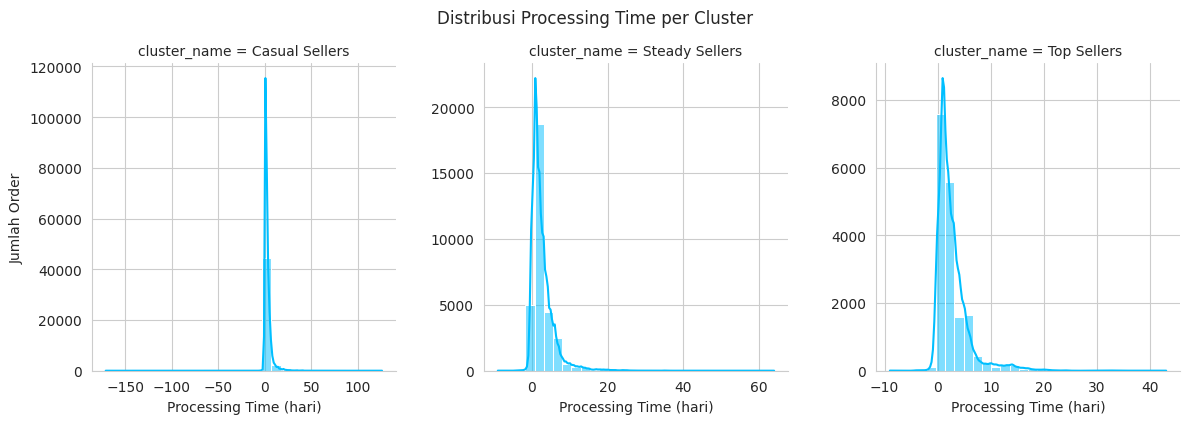

In [142]:
#Distribusi Processing Time Per Cluster
g = sb.FacetGrid(df_orders_merged, col="cluster_name", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sb.histplot, "processing_time", bins=30, kde=True, color="deepskyblue")
g.set_axis_labels("Processing Time (hari)", "Jumlah Order")
g.fig.suptitle("Distribusi Processing Time per Cluster", y=1.05)
plt.show()

### Distribusi Processing Time per Cluster (Histogram)
- Casual Sellers Cluster
  - Mayoritas pesanan diproses sangat cepat, hampir semua terkonsentrasi di bawah 2 hari.
  - Ada sedikit outlier dengan keterlambatan >50 hari, tapi jumlahnya sangat kecil dibanding total order.
  - Implikasi bisnis: Casual Sellers unggul di speed & consistency. Kecepatan ini bisa dijadikan best practice atau role model untuk meningkatkan standar seller lain.
  
- Steady Sellers Cluster
  - Distribusi lebih melebar; banyak pesanan tetap diproses cepat (<5 hari), tetapi ada long tail order hingga 30 hari.
  - Variasi yang tinggi menandakan kurang konsisten. Sebagian seller stabil, sebagian lain sering terlambat. Dibutuhkan program monitoring dan pelatihan agar gap performa antar seller menyempit.

- Top Sellers Cluster
  - Pola serupa dengan Steady Sellers, namun volume order lebih kecil.
  - Masih terdapat variasi signifikan dengan sebagian order yang terlambat >10 hari.
  - Keterlambatan ini bisa berdampak lebih besar ke customer experience, karena Top Sellers punya basis pembeli yang lebih loyal. Penanganan khusus (misalnya SLA lebih ketat atau sistem otomatisasi pengiriman) akan meningkatkan kepuasan pembeli.

In [143]:
time_df = df_merged.copy()
time_df["seller_to_carrier_day"] = pd.to_timedelta(time_df["order_delivered_carrier_date"] - time_df["order_approved_at"]).dt.days

time_df_group = time_df.groupby("seller_id").agg(
    avg_seller_to_carrier_day = ("seller_to_carrier_day", "mean"),
    cluster = ("k_means_cluster", "first")
)

cluster_0 = time_df_group[time_df_group["cluster"] == 0]
cluster_1 = time_df_group[time_df_group["cluster"] == 1]
cluster_2 = time_df_group[time_df_group["cluster"] == 2]

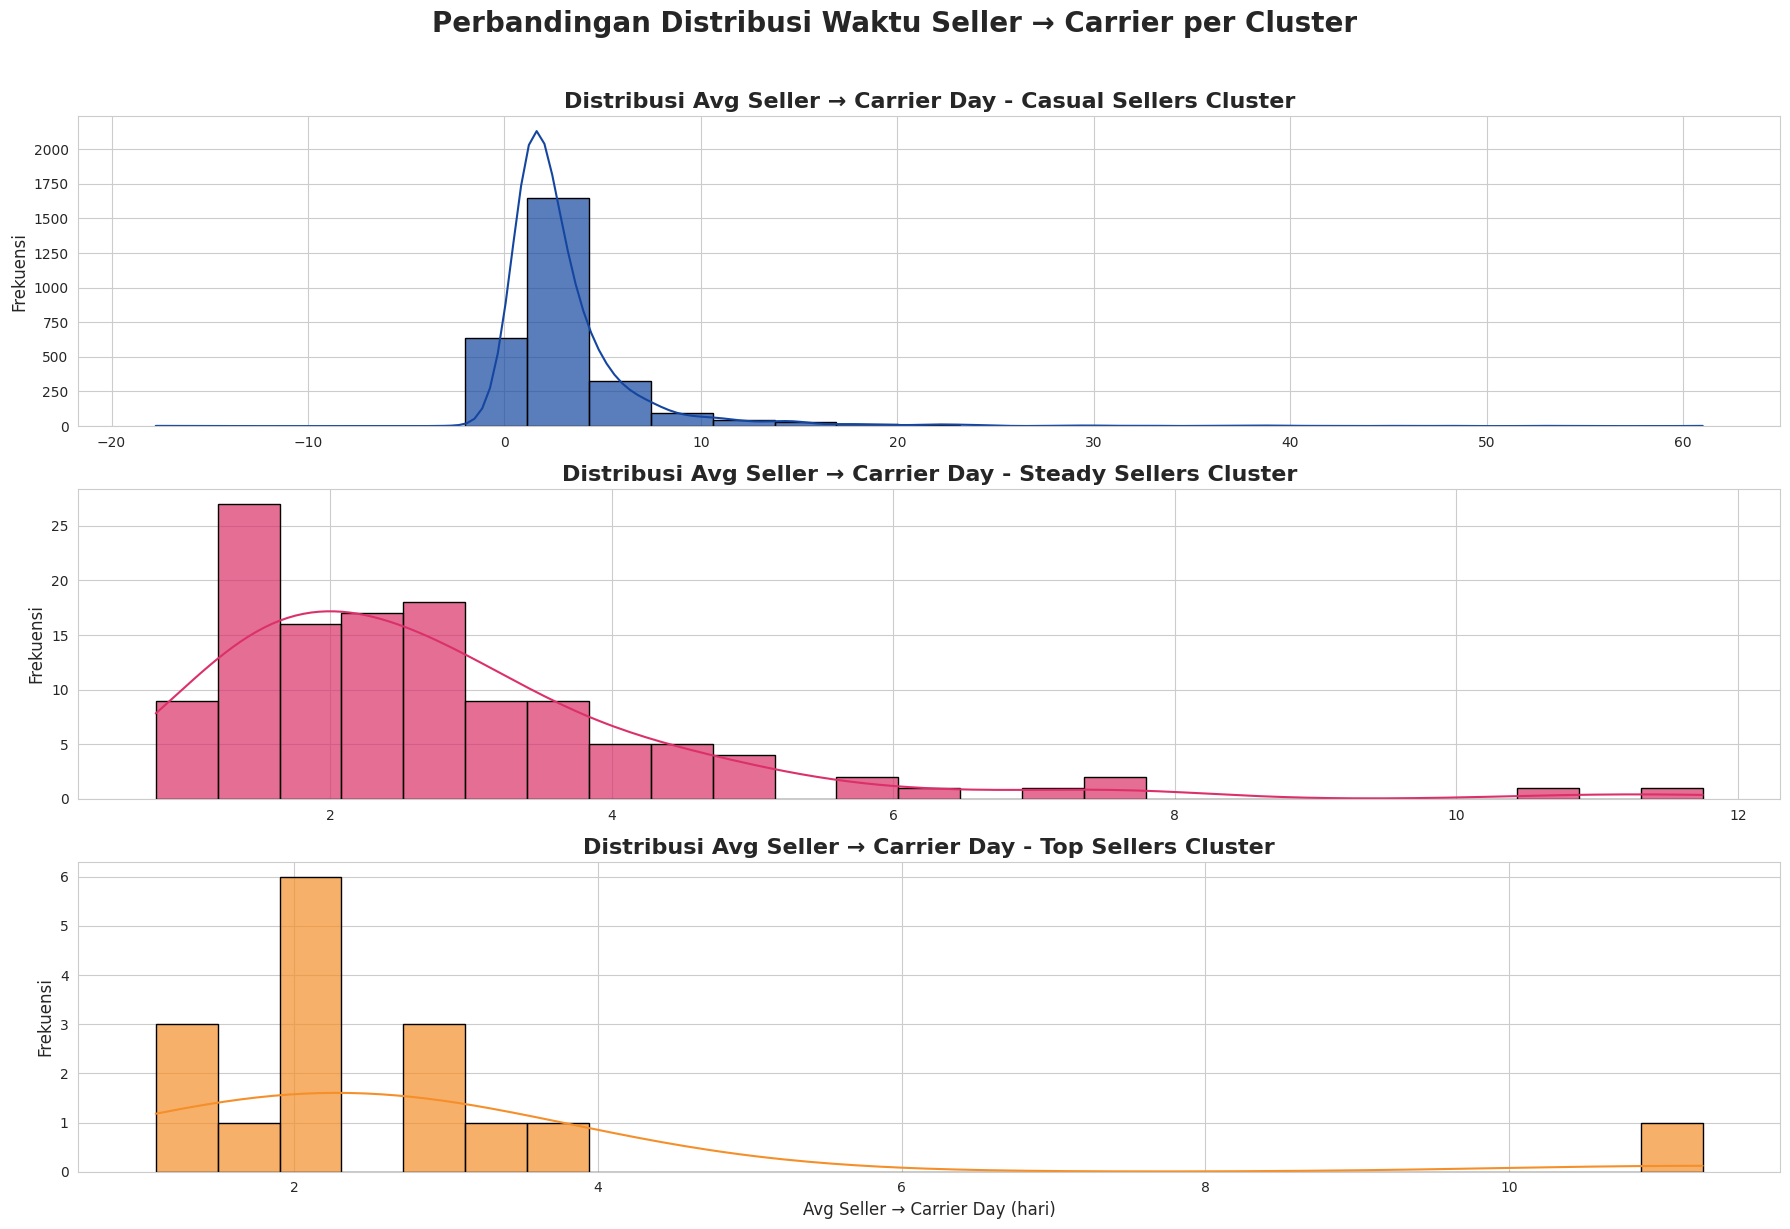

In [144]:
plt.figure(figsize=(18, 12))

# Cluster 0
ax1 = plt.subplot(3, 1, 1)
sb.histplot(data=cluster_0, x="avg_seller_to_carrier_day", bins=25, kde=True,
            color=COLORS[0], edgecolor="black", alpha=0.7)
ax1.set_title("Distribusi Avg Seller → Carrier Day - Casual Sellers Cluster", fontsize=16, weight="bold")
ax1.set_ylabel("Frekuensi", fontsize=12)
ax1.set_xlabel("")

# Cluster 1
ax2 = plt.subplot(3, 1, 2)
sb.histplot(data=cluster_2, x="avg_seller_to_carrier_day", bins=25, kde=True,
            color=COLORS[1], edgecolor="black", alpha=0.7)
ax2.set_title("Distribusi Avg Seller → Carrier Day - Steady Sellers Cluster", fontsize=16, weight="bold")
ax2.set_ylabel("Frekuensi", fontsize=12)
ax2.set_xlabel("")

# Cluster 2
ax3 = plt.subplot(3, 1, 3)
sb.histplot(data=cluster_1, x="avg_seller_to_carrier_day", bins=25, kde=True,
            color=COLORS[2], edgecolor="black", alpha=0.7)
ax3.set_title("Distribusi Avg Seller → Carrier Day - Top Sellers Cluster", fontsize=16, weight="bold")
ax3.set_ylabel("Frekuensi", fontsize=12)
ax3.set_xlabel("Avg Seller → Carrier Day (hari)", fontsize=12)

# Judul besar
plt.suptitle("Perbandingan Distribusi Waktu Seller → Carrier per Cluster",
             fontsize=20, weight="bold", y=1.02)

plt.tight_layout()
plt.show()


### Distribusi  Rata-rata Processing Time per Seller per Cluster
- Casual Sellers (paling cepat & terkonsentrasi di 0–2 hari)
  - Distribusi sangat rapat di sekitar 1–2 hari, menunjukkan mayoritas seller ini cepat menyerahkan barang ke carrier.
  - Ada outlier yang sangat lama (>30 hari), tapi jumlahnya kecil.
  - Segmen ini unggul dalam operational responsiveness. Kecepatan mereka bisa dijadikan benchmark untuk meningkatkan standar seller lain.

- Steady Sellers (lebih menyebar, rata-rata 2–4 hari)
  - Distribusi cenderung lebih rata dengan puncak di 2–3 hari, namun ada ekor panjang hingga 8–10 hari.
  - Menandakan adanya seller yang lambat menyerahkan barang, meskipun sebagian cukup cepat.
  - Variasi tinggi → perlu ada program consistency enforcement. Jika keterlambatan bisa dipangkas 1–2 hari, maka customer experience akan meningkat signifikan.

- Top Sellers (distribusi rendah volume, rata-rata 2–3 hari, ada keterlambatan ekstrim)
  - Rata-rata waktu serah ke carrier sekitar 2–3 hari, mirip Steady Sellers.
  - Namun ada beberapa kasus ekstrim (outlier hingga >10 hari), walaupun jumlahnya kecil.
  - Karena Top Sellers punya volume order tinggi, keterlambatan walaupun kecil bisa berdampak besar ke tingkat kepuasan pelanggan.

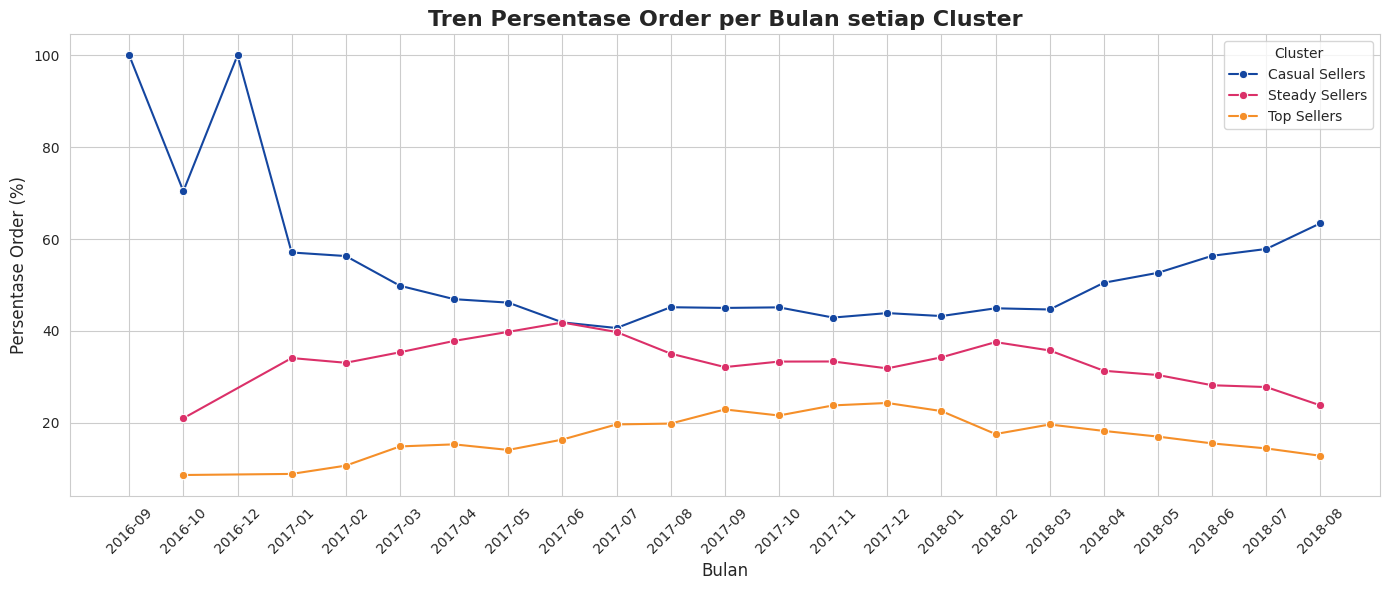

In [145]:
# Hitung jumlah order per bulan per cluster
orders_cluster_time = (
    df_orders_merged.groupby(["order_month", "cluster_name"])
    .size()
    .reset_index(name="order_count")
)

# Hitung total order per bulan
orders_cluster_time["total_order_month"] = orders_cluster_time.groupby("order_month")["order_count"].transform("sum")

# Hitung persentase order per cluster
orders_cluster_time["order_pct"] = orders_cluster_time["order_count"] / orders_cluster_time["total_order_month"] * 100

# Lineplot persentase
plt.figure(figsize=(14,6))
sb.lineplot(
    data=orders_cluster_time,
    x="order_month",
    y="order_pct",
    hue="cluster_name",
    marker="o",
    palette=COLORS
)

plt.title("Tren Persentase Order per Bulan setiap Cluster", fontsize=16, weight="bold")
plt.xlabel("Bulan", fontsize=12)
plt.ylabel("Persentase Order (%)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Cluster",)
plt.tight_layout()
plt.show()

### Tren Persentase Order per Bulan per Cluster
- Casual Sellers Cluster:
    - Selalu mendominasi dengan kontribusi terbesar (40-65%).
    - Meskipun sempat turun drastis setelah awal 2017, proporsinya tetap paling tinggi dan bahkan cenderung meningkat kembali di 2018.
    - Menandakan mayoritas seller masuk ke cluster ini dan menjadi segmen utama bisnis.

- Steady Sellers Cluster:
    - Berada di posisi kedua (sekitar 25-40%).
    - Tren relatif stabil, meskipun terlihat sedikit menurun sejak pertengahan 2017.
    - Ini menunjukkan cluster 1 konsisten menyumbang bagian signifikan dari order, tapi perannya mulai menurun dibanding Casual Sellers cluster.

- Top Sellers Cluster:
    - Proporsi paling kecil (sekitar 10-25%).
    - Ada kenaikan di 2017, namun setelah itu stagnan dan cenderung turun di 2018.
    - Menunjukkan bahwa segmen ini tidak berkembang pesat dan kurang berkontribusi terhadap total order.

In [146]:
df_orders_merged["order_purchase_timestamp"] = pd.to_datetime(df_orders_merged["order_purchase_timestamp"])

df_orders_merged["order_month"] = df_orders_merged["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()


In [147]:
monthly_processing_cluster = (
    df_orders_merged.groupby(["order_month", "cluster_name"])["processing_time"]
    .mean()
    .reset_index()
)

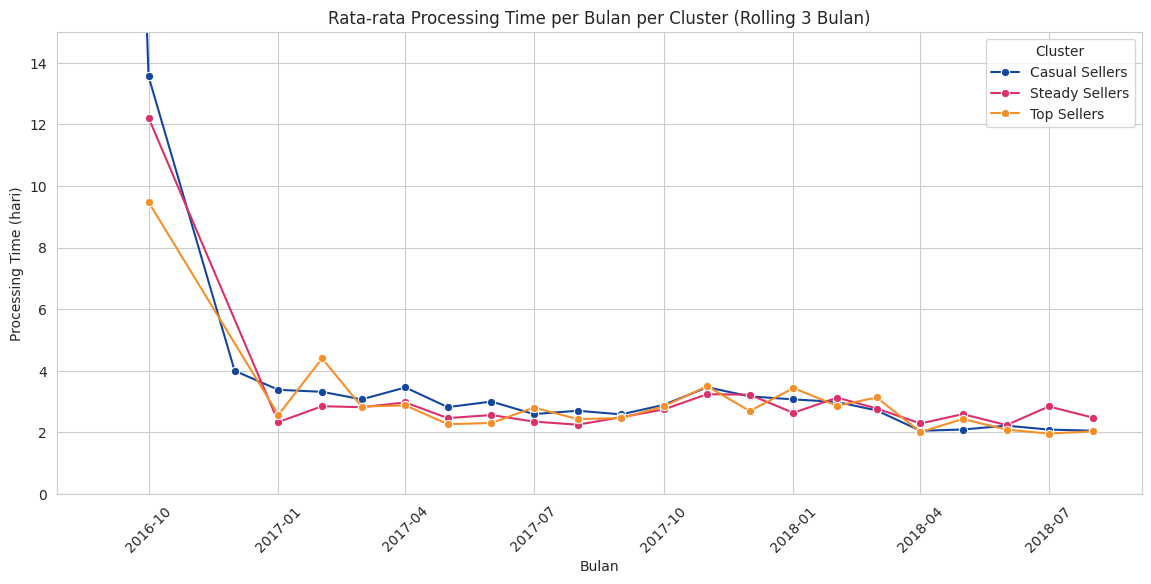

In [148]:
plt.figure(figsize=(14,6))
sb.lineplot(
    data=monthly_processing_cluster,
    x="order_month",
    y="processing_time",
    hue="cluster_name",
    marker="o",
    palette=COLORS
)
plt.title("Rata-rata Processing Time per Bulan per Cluster (Rolling 3 Bulan)")
plt.xlabel("Bulan")
plt.ylabel("Processing Time (hari)")
plt.ylim(0, 15)
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.show()


### Rata-rata Processing Time per Bulan per Cluster (Line Chart bawah)
- Awal periode (2016-09/2016-10)
  - Processing time sangat tinggi:
    - Casual Sellers ~15 hari
    - Steady Sellers ~12 hari
    - Top Sellers ~9–10 hari
  - Menunjukkan bahwa di awal operasional, ada ketidakstabilan atau keterlambatan besar dalam pemrosesan order

- Transisi 2016 Q4 → 2017 Q1
  - Processing time turun drastis ke kisaran 2–4 hari untuk semua cluster.
  - Penurunan ini konsisten lintas cluster → indikasi adanya perbaikan sistem/logistik signifikan

- Periode Stabil (2017 → 2018)
  - Rata-rata processing time stabil di 2–3 hari dengan sedikit fluktuasi musiman.
  - Tidak ada perbedaan signifikan antar cluster setelah 2017 → performa seller relatif homogen, artinya standar operasional sudah tercapai secara menyeluruh.


In [149]:
customer_cluster = pd.merge(df_merged, customers,how="left",on="customer_id")

In [150]:
customer_cluster_0 = customer_cluster[customer_cluster["k_means_cluster"] == 0]
customer_cluster_1 = customer_cluster[customer_cluster["k_means_cluster"] == 1]
customer_cluster_2 = customer_cluster[customer_cluster["k_means_cluster"] == 2]

customer_0_agg = customer_cluster_0.groupby("seller_id").agg(
    total_customer = ("customer_unique_id", "nunique"),
    frequency = ("frequency", "mean")
)
customer_1_agg = customer_cluster_1.groupby("seller_id").agg(
    total_customer = ("customer_unique_id", "nunique"),
    frequency = ("frequency", "mean")
)
customer_2_agg = customer_cluster_2.groupby("seller_id").agg(
    total_customer = ("customer_unique_id", "nunique"),
    frequency = ("frequency", "mean")
)

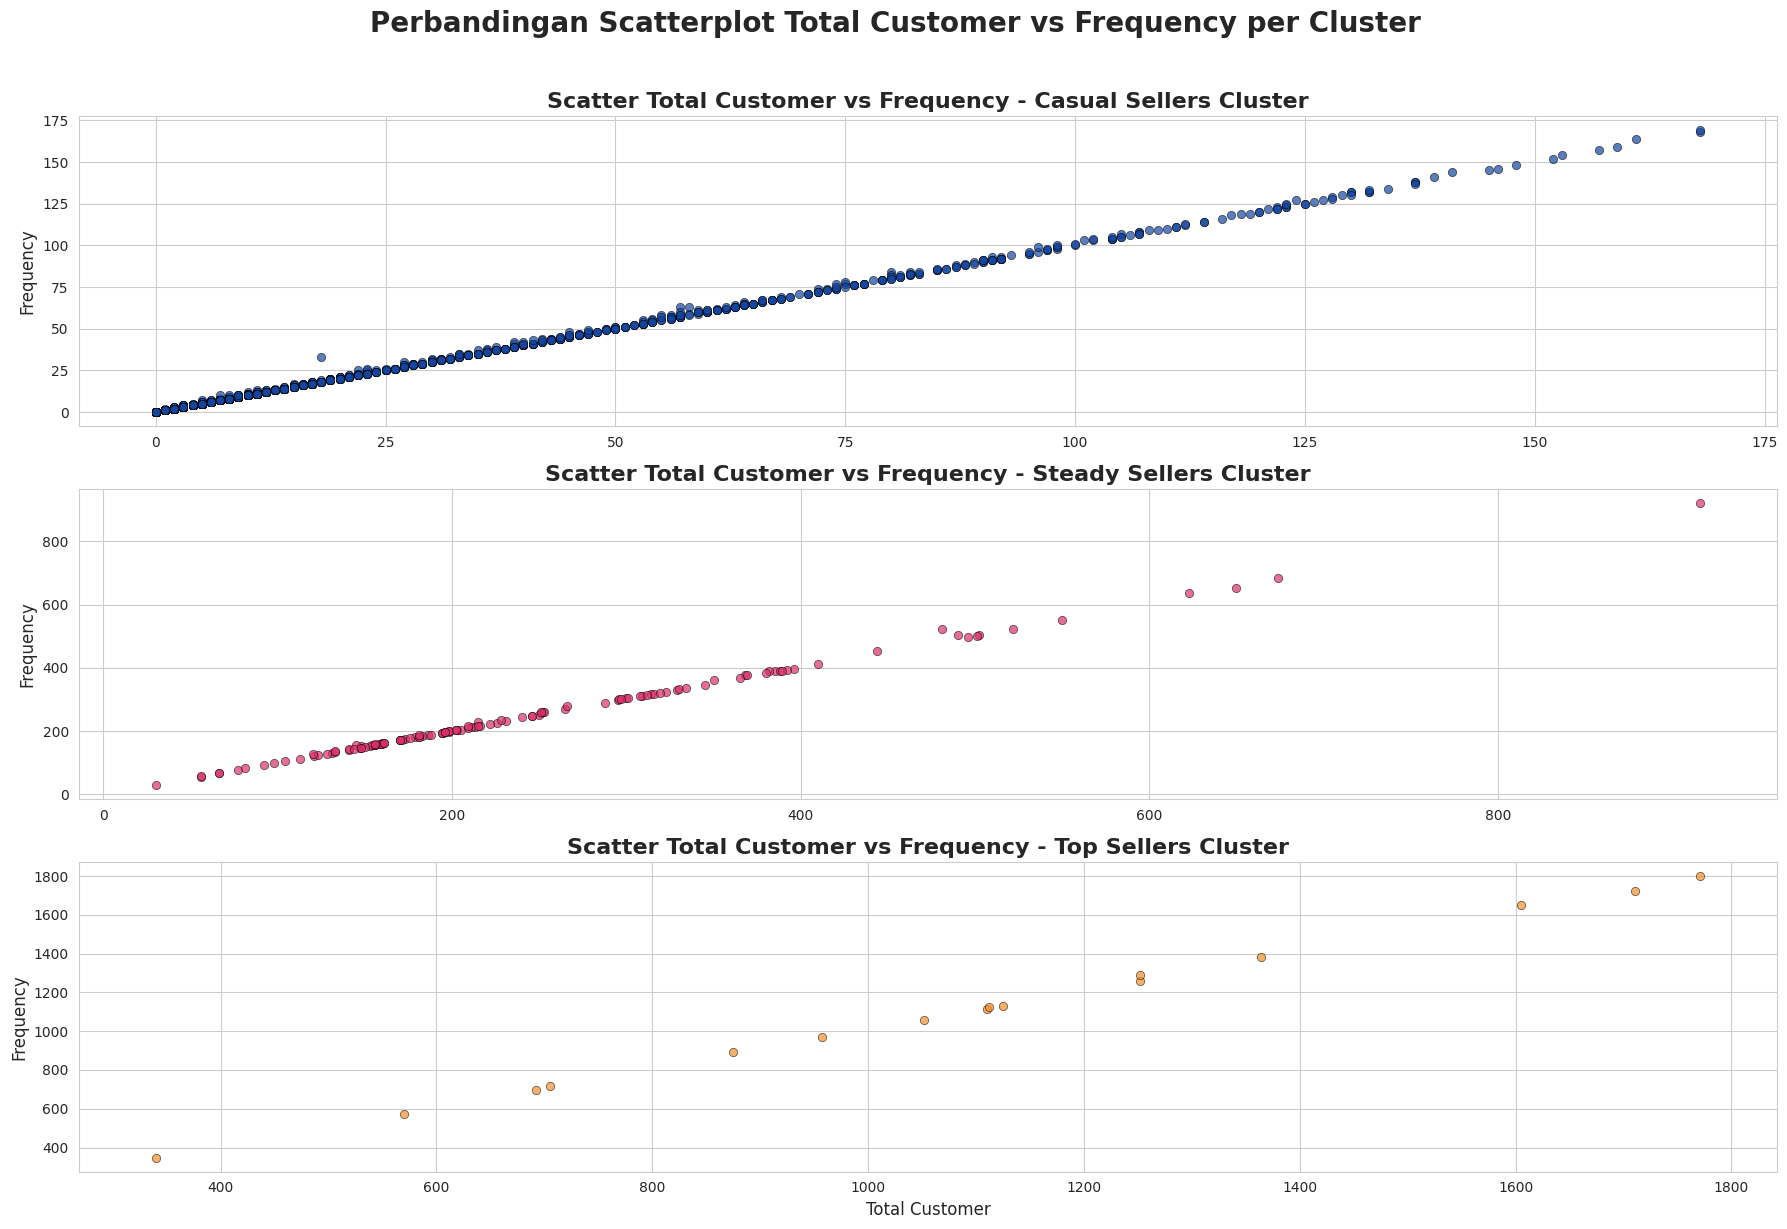

In [151]:
plt.figure(figsize=(18, 12))

# Cluster 0
ax1 = plt.subplot(3, 1, 1)
sb.scatterplot(
    data=customer_0_agg,
    x="total_customer",
    y="frequency",
    color=COLORS[0],
    alpha=0.7,
    edgecolor="black"
)
ax1.set_title("Scatter Total Customer vs Frequency - Casual Sellers Cluster", fontsize=16, weight="bold")
ax1.set_ylabel("Frequency", fontsize=12)
ax1.set_xlabel("")

# Cluster 1
ax2 = plt.subplot(3, 1, 2)
sb.scatterplot(
    data=customer_2_agg,
    x="total_customer",
    y="frequency",
    color=COLORS[1],
    alpha=0.7,
    edgecolor="black"
)
ax2.set_title("Scatter Total Customer vs Frequency - Steady Sellers Cluster", fontsize=16, weight="bold")
ax2.set_ylabel("Frequency", fontsize=12)
ax2.set_xlabel("")

# Cluster 2
ax3 = plt.subplot(3, 1, 3)
sb.scatterplot(
    data=customer_1_agg,
    x="total_customer",
    y="frequency",
    color=COLORS[2],
    alpha=0.7,
    edgecolor="black"
)
ax3.set_title("Scatter Total Customer vs Frequency - Top Sellers Cluster", fontsize=16, weight="bold")
ax3.set_ylabel("Frequency", fontsize=12)
ax3.set_xlabel("Total Customer", fontsize=12)

# Judul besar
plt.suptitle("Perbandingan Scatterplot Total Customer vs Frequency per Cluster", fontsize=20, weight="bold", y=1.02)

plt.tight_layout()
plt.show()


**Casual Sellers Cluster**
- Terlihat korelasi positif yang kuat antara total customer dan frequency, dengan data tersebar merata dari 0 hingga 175 customer dan frequency hingga 175. Ini menunjukkan bahwa semakin banyak seller, semakin tinggi frekuensi pembelian di segmen nilai rendah.

**Steady Sellers Cluster**
- Distribusi lebih jarang dan tidak seragam, dengan total customer mencapai hingga 1800 dan frequency hingga 1400. Ada beberapa titik outlier dengan frekuensi tinggi (di atas 1000) untuk jumlah seller yang lebih rendah, menunjukkan variasi besar dalam perilaku pembelian di segmen ini.

**Top Sellers Cluster**
- Korelasi positif juga terlihat, tetapi dengan data lebih terpusat di rentang 0-800 customer dan 0-800 frequency. Tidak ada titik ekstrem seperti di Steady Sellers, menunjukkan konsistensi yang lebih tinggi dalam pola pembelian di segmen nilai tinggi.

**Perbandingan Cluster**
- Casual Sellers cluster menunjukkan hubungan linier yang jelas dengan volume seller dan frekuensi yang lebih rendah secara absolut dibandingkan medium dan Top Sellers. Steady Sellers memiliki potensi seller dan frekuensi yang jauh lebih tinggi, namun dengan distribusi yang tidak merata, sementara Top Sellers menunjukkan pertumbuhan yang lebih terkontrol.


## Perbandingan Antara Sebelum Menggunakan Analysis RFM + Rt dan Machine Learning dan Sesudah

**Estimasi Biaya Jika Tidak Ada Treatment Seller**

Dengan estimasi bahwa 33% dari total seller akan churn.

| Jenis Biaya                                                | Estimasi (BRL)|
| ---------------------------------------------------------- | ----------------------------------- |
| Kehilangan revenue dari seller churn (1021 seller x 49) | **50.029**     |
| Cost akuisisi seller baru (1021 seller × 375)           | **382.875**   |
| **TOTAL**                                             | **432.904**   |

**Biaya Treatment Seller Berdasarkan Segmentasi RFM + Rt**

1. Top Sellers Seller

| Strategi                          | Deskripsi                                      | Estimasi Biaya / Seller (BRL) |
|-----------------------------------|------------------------------------------------|--------------------------|
| Loyalty Program                   | Poin reward, cashback, hadiah eksklusif        |  120                  |
| Insentif Transaksi                | Potongan komisi/bonus tiap pencapaian target   | 80                   |
| Promosi VIP                       | Eksposur lebih tinggi di platform              | 50                   |
| **Total per Seller (Top Sellers)** |                                                | **250**              |

2. Steady Sellers Seller

| Strategi                          | Deskripsi                                      | Estimasi Biaya / Seller (BRL) |
|-----------------------------------|------------------------------------------------|--------------------------|
| Training & Edukasi                | Webinar, workshop, modul online                | 40                   |
| Subsidi Promosi                   | Diskon iklan & biaya campaign                  | 60                   |
| Reward Target                     | Insentif jika naik ke kategori Top Sellers      | 30                   |
| **Total per Seller (Steady Sellers)** |                                              | **130**              |

3. Casual Sellers Seller

| Strategi                          | Deskripsi                                      | Estimasi Biaya / Seller (BRL) |
|-----------------------------------|------------------------------------------------|--------------------------|
| Reaktivasi Marketing              | Email, SMS, push notification khusus           | 20                   |
| Voucher Transaksi                  | Kupon diskon untuk memicu transaksi pertama    | 30                   |
| Seleksi & Evaluasi                 | Monitoring, potensi offboarding seller pasif   | 10                   |
| **Total per Seller (Casual Sellers)**   |                                                | **60**               |

**Biaya yang dikeluarkan berdasarkan Algoritma Machine Learning Terbaik (KMeans)**

Casual Sellers : 2815 * 60 = R\$ 168,900

Steady Sellers : 125 * 130 = R\$ 16,250

Top Sellers : 16 * 250 = R\$ 4,000

Total Cost : R\$ 189,150

**Perbandingan Biaya**
| Jenis Biaya                                                | Estimasi (BRL)|
| ---------------------------------------------------------- | -------------------------------- |
| Biaya Jika Tidak Ada Treatment Seller (33% sellers akan churn)                | **432.904**   |
| Biaya yang dikeluarkan berdasarkan Algoritma Machine Learning Terbaik (KMeans)| **189.150**   |

Insight:
- Berdasarkan perbandingan biaya di atas, dapat dilihat bahwa biaya yang perlu dikeluarkan jika menggunakan Analysis & Machine Learning (dalam hal ini algoritma KMeans yang merupakan terbaik di antara ketiganya) merupakan biaya yang paling rendah, sebesar BRL 189.150.
- Jika dibandingkan dengan **Biaya Jika Tidak Ada Treatment Seller (dengan estimasi 33% seller akan churn)**, menggunakan Machine Learning dapat menghemat pengeluaran sebesar BRL 243.754 (sekitar 56%).
- Personalized Treatment memungkinkan perusahaan untuk lebih fokus pada seller yang benar-benar membutuhkan perhatian, mengoptimalkan seller yang perform, serta mengurangi pengeluaran pada seller yang tidak terlalu aktif atau yang tidak lagi berpotensi.
- Seller yang sudah top, seperti Top Sellers, mendapat lebih banyak insentif untuk mempertahankan hubungan jangka panjang dan meningkatkan loyalitas. Sementara itu, Casual Sellers mendapatkan treatment untuk mendorong mereka untuk lebih aktif, dan dengan biaya treatment yang lebih rendah.

## Limitasi

**Keterbatasan Metodologi Clustering**
- KMeans mengasumsikan cluster berbentuk bulat dan memiliki variansi serupa → bisa kurang akurat jika pola perilaku seller lebih kompleks.

**Algoritma sensitif terhadap outlier**,
- Methode KMeans sensitif terhadap outlier, sehingga seller dengan transaksi ekstrem bisa mendistorsi hasil cluster.

**Generalisasi & Skalabilitas**
- Model hanya berlaku pada dataset Olist saat ini. Ketika ada pertumbuhan seller baru atau perubahan tren pasar, hasil segmentasi perlu diperbarui.
- Skalabilitas bisa menjadi isu jika jumlah seller bertambah jauh lebih besar (jutaan), sehingga perlu arsitektur big data & algoritma lebih efisien.


## Kesimpulan & Saran

**Kesimpulan**
1. **Variabilitas Tinggi pada Seller Olist**

    Seller Olist memiliki perilaku yang sangat beragam, dari top sellers, steady sellers, hingga casual sellers.

    Berdasarkan analisis RFM (Recency, Frequency, Monetary) + Rating pada dataset seller Olist, kita berhasil mengidentifikasi pola perilaku seller yang bervariasi dan mengelompokkannya menjadi tiga segmen utama menggunakan algoritma KMeans. Hasil clustering menunjukkan distribusi sebagai berikut:

- **Casual Sellers**:

  Segmen terbesar dengan recency tinggi (jarang aktif), frequency rendah (rata-rata <60 order), monetary rendah (rata-rata <8000 BRL), dan rating sedang (~4.0).
  
- **Steady Sellers**:
  
  Seller dengan recency sedang, frequency moderat (rata-rata 200-500 order), monetary sedang (rata-rata 20.000-50.000 BRL), dan rating cukup baik (~4.0-4.5).

- **Top Sellers**:

  Segmen elit dengan recency rendah (sangat aktif), frequency tinggi (rata-rata >1000 order), monetary tinggi (rata-rata >100.000 BRL), dan rating baik (~4-5).

2. **RFM + Review Score Sebagai Indikator**
- Recency mengungkap seller yang berpotensi churn jika tidak ditangani.
- Frequency & Monetary memetakan kontribusi seller.
- Review Score menjadi cerminan kualitas pelayanan, yang pada gilirannya berdampak langsung pada customer retention.

3. **Insight Strategis untuk Bisnis**
- Top sellers → perlu dipertahankan dengan dukungan premium.
- Steady sellers → bisa ditingkatkan dengan pelatihan & promosi.
- At-risk sellers → butuh intervensi khusus agar tidak churn.

Secara keseluruhan, analisis ini mengonfirmasi bahwa mayoritas seller (~95%) berada di segmen rendah (Casual), sementara segmen atas (Top) memiliki revenue per seller yang sangat tinggi. Pendekatan ML meningkatkan akurasi segmentasi dibandingkan manual, dengan potensi mengurangi churn hingga 20-30% jika diterapkan dalam strategi retensi. Namun, limitasi seperti sensitivitas terhadap outlier dan asumsi bentuk cluster bulat menekankan perlunya validasi lanjutan.

### Saran/Rekomendasi

1. **Strategi Retensi & Pengembangan Seller**

Untuk memaksimalkan nilai dari segmentasi ini, Olist dapat menerapkan strategi targeted berikut, disesuaikan dengan karakteristik cluster:

    1. **Untuk Casual Sellers**:
       - **Program Reaktivasi**: Kirim email atau notifikasi personal dengan insentif seperti diskon onboarding ulang (misalnya, gratis biaya listing untuk 3 bulan pertama) atau tutorial cepat untuk meningkatkan visibilitas produk.
       - **Voucher Transaksi**: Memberikan voucher/diskon untuk memicu transaksi dengan seller.
       - **Monitoring Churn**: Monitor seller berisiko churn. Hal ini membantu mencegah seller churn dan berpotensi meningkatkan level mereka ke Steady.

    2. **Untuk Steady Sellers**:
       - **Training dan Edukasi**: Berikan pelatihan eksklusif (webinar tentang optimalisasi listing atau SEO marketplace)
       - **Subsidi Promosi**: Memberikan subsidi promosi (misalnya, 20% diskon iklan di marketplace mitra) agar Steady seller dapat meningkatkan performanya.
       - **Insentif Berbasis Performa**: Reward berupa komisi lebih rendah jika naik ke kategori Top seller.

    3. **Untuk Top Sellers**:
       - **Loyalitas Program**: Tawarkan akses prioritas ke fitur premium seperti analitik real-time atau partnership eksklusif dengan marketplace besar. Hindari over-insentif untuk menjaga profitabilitas.
       - **Insentif Transaksi**: Memberikan potongan komisi dan bonus setiap pencapaian target revenue.
       - **Promosi VIP**: Memberikan eksposur lebih tinggi (prioritas) di platform mitra.
       
2. Strategi Teknologi & Data Science
- Uji metode clustering alternatif (misalnya Hierarchical Clustering) untuk validasi hasil.
- Tambahkan dimensi data baru (kategori produk, margin, logistik) agar segmentasi lebih kaya.
- Kembangkan model prediktif churn untuk seller, sehingga Olist bisa bertindak proaktif.

Secara umum:
- **Integrasi dengan Sistem Olist**: Bangun dashboard otomatis untuk monitoring cluster secara real-time, dengan update model setiap 3-6 bulan untuk menangkap tren baru (misalnya, tambah fitur seperti jumlah produk atau kategori jualan).
- **Pengujian A/B**: Uji efektivitas program dengan split testing (misalnya, 50% seller di segmen Casual dapat insentif vs. kontrol grup) untuk hitung ROI.
- **Ekspansi Analisis**: Tambah variabel seperti geolokasi seller atau waktu pengiriman untuk clustering lebih akurat, dan integrasikan dengan model prediksi churn menggunakan Decision Tree untuk deteksi dini.

Rekomendasi ini berbasis langsung pada hasil analisis notebook, dengan fokus pada actionable insights untuk mendukung objectives seperti retensi dan revenue optimization.

---
Author:
- [Reyhan Kurniawan](https://github.com/ReyhanKurniawan10)
- [Patrick Jonathan](https://github.com/patrickjoo)
- [Bernando Virto Gunawan](https://github.com/bernandogunawan)